
# Bias Analysis: Response Changes Before and After Article Exposure

This notebook analyzes the impact of exposure to biased articles (left and right-wing) on user responses. The analysis covers multiple dimensions, including overall changes, differences by political groups, and significance testing.


# 1. Introduction and Imports
This section imports the necessary libraries and sets up the environment for the analysis.


In [1]:
import pandas as pd
import json
import re
from scipy.stats import wilcoxon
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.colors as clr


In [2]:
before_responses_path = "../data/processed/before_responses.json"
after_responses_path = "../data/processed/after_responses.json"
persona_prompts_path = '../data/processed/persona_prompts.json'
question_codes_path = '../data/raw/question_codes.json'
user_ranks_path = "../data/processed/user_ranks.csv"


In [3]:
class PublicationStyle:
    """
    A class to maintain consistent styling across scientific publication visualizations.
    """
    
    # Color palettes
    MAIN_COLORS = {
        'primary': '#4F1787',
        'secondary': '#FB773C',
        'tertiary': '#7A24A1',
        'quaternary': '#FB4E56',
        'accent1': '#180161',
        'accent2': '#FDAA62',
        'accent3': '#B73AB3',
        'accent4': '#EB3678'
    }
    
    PALETTE = list(MAIN_COLORS.values())
    
    GRADIENT_COLORS = ['#FDAA62', '#FB773C', '#FB4E56', '#EB3678', 
                      '#B73AB3', '#7A24A1', '#4F1787', '#180161']
    
    GRADIENT_CMAP = clr.LinearSegmentedColormap.from_list('custom', GRADIENT_COLORS)
    
    # Font sizes
    FONT_SIZES = {
        'tiny': 8,
        'small': 10,
        'medium': 12,
        'large': 14,
        'xlarge': 16,
        'title': 16,
        'subtitle': 14,
        'axis_label': 12,
        'tick_label': 10,
        'legend': 10,
        'annotation': 9
    }
    
    @classmethod
    def set_style(cls):
        """Set the default style for all visualizations."""
        # Set basic seaborn style
        sns.set_theme(style="whitegrid", font='Arial')
        
        # Set default parameters
        plt.rcParams.update({
            # Font settings
            'font.size': cls.FONT_SIZES['medium'],
            
            # Figure settings
            'figure.figsize': (8, 6),
            'figure.dpi': 300,
            
            # Axes settings
            'axes.titlesize': cls.FONT_SIZES['title'],
            'axes.labelsize': cls.FONT_SIZES['axis_label'],
            'axes.grid': True,
            'grid.alpha': 0.3,
            
            # Tick settings
            'xtick.labelsize': cls.FONT_SIZES['tick_label'],
            'ytick.labelsize': cls.FONT_SIZES['tick_label'],
            
            # Legend settings
            'legend.fontsize': cls.FONT_SIZES['legend'],
            'legend.title_fontsize': cls.FONT_SIZES['legend'],
            'legend.frameon': True,
            'legend.framealpha': 0.8,
            'legend.edgecolor': 'black',
            
            # Lines and markers
            'lines.linewidth': 2,
            'lines.markersize': 8
        })
    
    @classmethod
    def format_axis(cls, ax, title=None, xlabel=None, ylabel=None, 
                   xticks=None, yticks=None, rotation=0):
        """Format a single axis with consistent styling."""
        if title:
            ax.set_title(title, pad=20, fontweight='bold')
        if xlabel:
            ax.set_xlabel(xlabel)
        if ylabel:
            ax.set_ylabel(ylabel)
        if xticks is not None:
            ax.set_xticks(xticks[0])
            ax.set_xticklabels(xticks[1], rotation=rotation)
        if yticks is not None:
            ax.set_yticks(yticks[0])
            ax.set_yticklabels(yticks[1])
        
        # Add subtle grid
        ax.grid(True, alpha=0.3)
        
        # Style spines
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')
    
    @classmethod
    def add_figure_labels(cls, fig, labels=None):
        """Add subplot labels (a, b, c, etc.) to figure."""
        if labels is None:
            labels = list('abcdefghijklmnopqrstuvwxyz')
        
        for n, ax in enumerate(fig.axes):
            if n < len(labels):
                ax.text(-0.1, 1.1, f'({labels[n]})', transform=ax.transAxes, 
                       size=14, weight='bold')

    @classmethod
    def save_figure(cls, fig, filename, dpi=300, bbox_inches='tight'):
        """Save figure with consistent settings."""
        fig.savefig(filename, dpi=dpi, bbox_inches=bbox_inches)

# 2. Loading and Preprocessing Data
This section handles the loading and initial preprocessing of user responses and persona data.


In [4]:
def load_json_data(filepath):
    """Loads JSON data from the provided file path and attempts to fix malformed sections."""
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            content = f.read()

        try:
            return json.loads(content)  
        except json.JSONDecodeError as e:
            print(f"Malformed JSON detected: {str(e)}")
            print("Attempting to fix...")

            content_fixed = content.replace("][", "],[")

            try:
                return json.loads(f"[{content_fixed}]")  
            except json.JSONDecodeError as e:
                print(f"Error: Unable to decode JSON after attempt to fix. {str(e)}")
                return None

    except FileNotFoundError:
        print(f"Error: File {filepath} not found.")
        return None
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON from {filepath}. {str(e)}")
        return None


In [5]:
def flatten_after_responses(response_data):
    flattened_data = []
    
    for user_responses in response_data:
        for entry in user_responses:
            user_id = entry['user_id']
            question_code = entry['question_code']
            bias = entry['bias']  # Assuming bias always exists
            selected_option = entry['response'].get('selected_option')

            flattened_data.append({
                'user_id': user_id,
                'question_code': question_code,
                'bias': bias,
                'selected_option': selected_option,
                'question': entry.get('question')
            })
    return flattened_data



In [6]:
def load_question_code_mapping(question_codes_path):
    """Load and filter the question-to-code mapping from the question_codes.json file."""
    question_codes_data = load_json_data(question_codes_path)
    
    # List of valid question codes relevant to the analysis
    valid_question_codes = ['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1', 'F3A8_1']
    
    # Filter only questions that are in the valid_question_codes list
    filtered_data = [entry for entry in question_codes_data if entry['code'] in valid_question_codes]

    # Create a mapping for each question from text to numerical codes
    question_code_mapping = {}
    for entry in filtered_data:
        question = entry['question']
        code = entry['code']
        options = entry['options']
        
        # Reverse the options dictionary to map response text to numerical values
        reversed_options = {v: k for k, v in options.items()}
        question_code_mapping[question] = {'code': code, 'options': reversed_options}

    return question_code_mapping


In [7]:
def create_after_responses_dataframe(flattened_data):
    """
    Converts the flattened after responses into a structured DataFrame.
    """
    df = pd.DataFrame(flattened_data)
    
    # Set a multi-index using user_id, question_code, and bias
    df.set_index(['user_id', 'question_code', 'bias'], inplace=True)
    
    return df

In [8]:
def extract_actual_question(full_prompt):
    """Extracts the actual question from the full prompt in the 'question' field and cleans it."""
    
    # Use regex to find text between **Question**: and **Options**:
    match = re.search(r'\*\*Question\*\*[:\s]*(.*?)\*\*Options\*\*', full_prompt, re.DOTALL)
    
    if match:
        question = match.group(1).strip()  # Extracted question
        # Clean the question: remove extra spaces and newlines
        question_cleaned = re.sub(r'\s+', ' ', question).strip()
        return question_cleaned
    
    # If no structured question is found, return the full prompt (fallback)
    return full_prompt.strip()


In [9]:

def create_clean_dataframe_with_codes(response_data, question_code_mapping, has_bias=False):
    """
    Converts a list of response data dictionaries into a structured DataFrame with question codes.
    Handles optional fields like bias if present in the data (for after_responses).
    Parameters:
    - response_data: List of dictionaries containing the response data.
    - question_code_mapping: A dictionary that maps question texts to their corresponding codes.
    - has_bias: Boolean flag to indicate if the data includes bias (for after_responses).
    """
    cleaned_data = []
    
    for entry in response_data:
        user_id = entry['user_id']
        full_prompt = entry['question']  
        selected_option = entry['response']['selected_option']
        bias = entry.get('bias', None) if has_bias else None

        question = extract_actual_question(full_prompt)
        
        if question is None:
            print(f"Warning: Could not extract question from prompt for user {user_id}. Skipping entry.")
            continue

        question_code = question_code_mapping.get(question, {}).get('code')
        
        if question_code is None:
            print(f"Warning: No question_code found for question '{question}' for user {user_id}. Skipping entry.")
            continue

        cleaned_entry = {
            'user_id': user_id,
            'question_code': question_code,
            'bias': bias,
            'selected_option': selected_option,
            'question': question
        }
        
        cleaned_data.append(cleaned_entry)
    
    df = pd.DataFrame(cleaned_data)
    if has_bias:
        df.set_index(['user_id', 'question_code', 'bias'], inplace=True)
    else:
        df.set_index(['user_id', 'question_code'], inplace=True)
    
    return df


In [10]:
def map_responses_to_numeric(df, question_code_mapping):
    """
    Maps the string-based responses to their corresponding numerical values using the question code mapping, so we can measure the change in responses in later steps.
    """
    def map_response(row):
        question_text = row['question']  
        selected_option = row['selected_option']  
        
       
        if question_text in question_code_mapping:
            mapping = question_code_mapping[question_text]['options']
       
            return mapping.get(selected_option, None)  
        return None
    
   
    df['numeric_response'] = df.apply(map_response, axis=1)
    return df


In [11]:
def extract_political_stance(persona_prompt):
    """Extracts the political stance from the persona prompt text."""
    match = re.search(r"\*\*Your Own Political Position\*\*:\s*You consider your political position to be\s*'(.*?)'\s*on the political scale", persona_prompt)
    
    if match:
        return match.group(1).strip()  # Extract the political position (e.g., 'Extreme Left')
    return None


# Load the persona prompts
def load_persona_prompts(filepath):
    """Loads the persona prompts data and creates a mapping of user_id to political stance."""
    persona_data = load_json_data(filepath)  # Reusing load_json_data to load the file
    if persona_data is None:
        return {}

    # Create a mapping of user_id to political stance
    persona_mapping = {}
    for entry in persona_data:
        user_id = entry['user_id']
        political_stance = extract_political_stance(entry['persona_prompt'])
        persona_mapping[user_id] = political_stance
    
    return persona_mapping

def add_political_stance_to_df(df, persona_mapping):
    """Adds political stance column to the given DataFrame based on user_id, and combines Far Left and Extreme Left, since these 2 groups were already combined prior to inference."""
    # Map political stance from persona_mapping to the DataFrame
    df['political_stance'] = df.index.get_level_values('user_id').map(persona_mapping)

    # Merge Far Left and Extreme Left into a single group: Extreme Left
    df['political_stance'] = df['political_stance'].replace({'Far Left': 'Extreme Left'})

    # Debug: Check for missing political stance mappings
    missing_stance_df = df[df['political_stance'].isna()]
    if not missing_stance_df.empty:
        print("These user_ids have no political stance mapped:")
        print(missing_stance_df.index.get_level_values('user_id').unique())

    return df



In [12]:
user_ranks = pd.read_csv(user_ranks_path)

# Load the question code mapping for both before and after responses
question_code_mapping = load_question_code_mapping(question_codes_path)
persona_mapping = load_persona_prompts(persona_prompts_path)

## Process the BEFORE data

before_responses = load_json_data(before_responses_path)
before_responses_df = create_clean_dataframe_with_codes(before_responses, question_code_mapping)
before_responses_df = map_responses_to_numeric(before_responses_df, question_code_mapping)
before_responses_df = add_political_stance_to_df(before_responses_df, persona_mapping)

## Process the AFTER data

after_responses = load_json_data(after_responses_path)
flattened_after_responses = flatten_after_responses(after_responses)
after_responses_df = create_after_responses_dataframe(flattened_after_responses)
after_responses_df = map_responses_to_numeric(after_responses_df, question_code_mapping)
after_responses_df = add_political_stance_to_df(after_responses_df, persona_mapping)



Malformed JSON detected: Extra data: line 178 column 2 (char 5656)
Attempting to fix...


In [13]:
# Ensure that 'bias' is a column and not part of the index
after_responses_df = after_responses_df.reset_index()



In [14]:
after_responses_df.head()

user_id question_code   bias          selected_option  \
0  IDUS103408       F1A10_1   left  Disagree to some extent   
1  IDUS103408       F1A10_1  right         Completely agree   
2  IDUS103408          F2A6   left          quite concerned   
3  IDUS103408          F2A6  right           very concerned   
4  IDUS103408          F2A7   left           very concerned   

                                            question numeric_response  \
0    I feel like I am treated fairly by politicians.                5   
1    I feel like I am treated fairly by politicians.                1   
2  To what degree does this concern you: The fact...                4   
3  To what degree does this concern you: The fact...                5   
4  To what degree does this concern you: The situ...                5   

  political_stance  
0    Extreme Right  
1    Extreme Right  
2    Extreme Right  
3    Extreme Right  
4    Extreme Right

**Agreement and Concern: 2 scales in different directions**

To address the problem of the 2 different scales, we are applying a normalization step.

The direction of change takes into account the 2 different scales, i.e. 1-7 (1 = completely agree, 7 = completely disagree) and 1-5 (1 = not concerned at all, 5 = extremely concerned). These scales display 2 opposing directions, that can be summarized into a positive (signalising the **increase** of a dimension, such as agreement and concern), and one negative (signalising a **decrease** in a dimension, such as agreement and concern).
We therefore treat these 2 scalas in 2 different ways: in the agreement scale, an increase of agreement is identified in cases where "numeric_response_before" > "numeric_response_after", e.g. if the before response code was a 7, indicating a very strong disagreement with the statement or question, an after response with the code 3 will indicate a sensible increase in agreement. 

The opposite is true for the 1-5 scale, where moving from a low value code in the numeric_before_responses to a higher value code in the numeric_after_responses indicates an increase in the concern dimension.

In [15]:
def ensure_numeric_format(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

before_responses_df = ensure_numeric_format(before_responses_df, 'numeric_response')
after_responses_df = ensure_numeric_format(after_responses_df, 'numeric_response')

# Merge the before and after responses DataFrames on user_id and question_code, so we can use only one dataframe for analysis
def merge_before_after_responses(before_df, after_df):
    # Reset the index to bring 'user_id' and 'question_code' back as columns
    before_df = before_df.reset_index()
    after_df = after_df.reset_index()

    merged_df = pd.merge(
        before_df[['user_id', 'question_code', 'numeric_response', 'political_stance']],
        after_df[['user_id', 'question_code', 'numeric_response', 'bias', 'political_stance']],
        on=['user_id', 'question_code', 'political_stance'],  # Merge on user_id, question_code, and political_stance
        suffixes=('_before', '_after')
    )

    def change_increase_or_decrease(row):
        """Takes the different scales into account and determines if the response increased, decreased, or stayed the same."""
        abs_change = row["response_change"]
        if row["question_code"].startswith("F2"):  # the starting code indicates the 1-5 scale
            if row['numeric_response_after'] > row['numeric_response_before']:
                return abs_change
            elif row['numeric_response_after'] < row['numeric_response_before']:
                return - abs_change
            return abs_change
        else:  # the starting code indicates the 1-7 scale
            if row['numeric_response_after'] < row['numeric_response_before']:
                return abs_change
            elif row['numeric_response_after'] > row['numeric_response_before']:
                return - abs_change
            return abs_change
    # Calculate the change in response (after - before)
    # conditionals to measure the direction of change for the 2 different scales
    # get the absolute value, and use the change increase or decrease function to determine the direction, i.e. the artithmetic sign of the change.

    merged_df['response_change'] = merged_df['numeric_response_after'] - merged_df['numeric_response_before'].abs()
    merged_df['response_change'] = merged_df.apply(change_increase_or_decrease, axis=1)

    return merged_df


# Merge the reliability scores with the merged responses DataFrame
def merge_reliability_scores(merged_df, reliability_df):
    merged_df = pd.merge(
        merged_df,
        reliability_df[['user_id', 'reliability_score']],  # Ensure we only bring in the relevant columns
        on='user_id',
        how='left'  # Ensure we don't drop any data if reliability scores are missing
    )
    return merged_df

def normalize_response_change(row):
    if row['question_code'].startswith('F2'):  # 1-5 scale
        return row['response_change'] / 4.0  # Maximum change is 4
    else:  # 1-7 scale
        return row['response_change'] / 6.0  # Maximum change is 6

merged_responses_df = merge_before_after_responses(before_responses_df, after_responses_df)
# Merge reliability scores into merged_responses_df
merged_responses_with_reliability = merge_reliability_scores(merged_responses_df, user_ranks)
# adds a column to the merged_responses_df to indicate the change in response scaled by the reliability score
merged_responses_with_reliability['normalized_response_change'] = merged_responses_with_reliability.apply(normalize_response_change, axis=1)
merged_responses_with_reliability['weighted_response_change'] = merged_responses_with_reliability['normalized_response_change'] * merged_responses_with_reliability['reliability_score']

# print(merged_responses_with_reliability.head())
print(merged_responses_with_reliability.sort_values(by='reliability_score', ascending=False).head(10))




         user_id question_code  numeric_response_before political_stance  \
1552  IDUS127802       F1A10_1                        6    Extreme Right   
1553  IDUS127802       F1A10_1                        6    Extreme Right   
1554  IDUS127802          F2A6                        5    Extreme Right   
1555  IDUS127802          F2A6                        5    Extreme Right   
1556  IDUS127802          F2A7                        2    Extreme Right   
1557  IDUS127802          F2A7                        2    Extreme Right   
1558  IDUS127802          F2A9                        5    Extreme Right   
1559  IDUS127802          F2A9                        5    Extreme Right   
1560  IDUS127802        F3A3_1                        6    Extreme Right   
1561  IDUS127802        F3A3_1                        6    Extreme Right   

      numeric_response_after   bias  response_change  reliability_score  \
1552                       7   left               -1           0.727273   
1553         

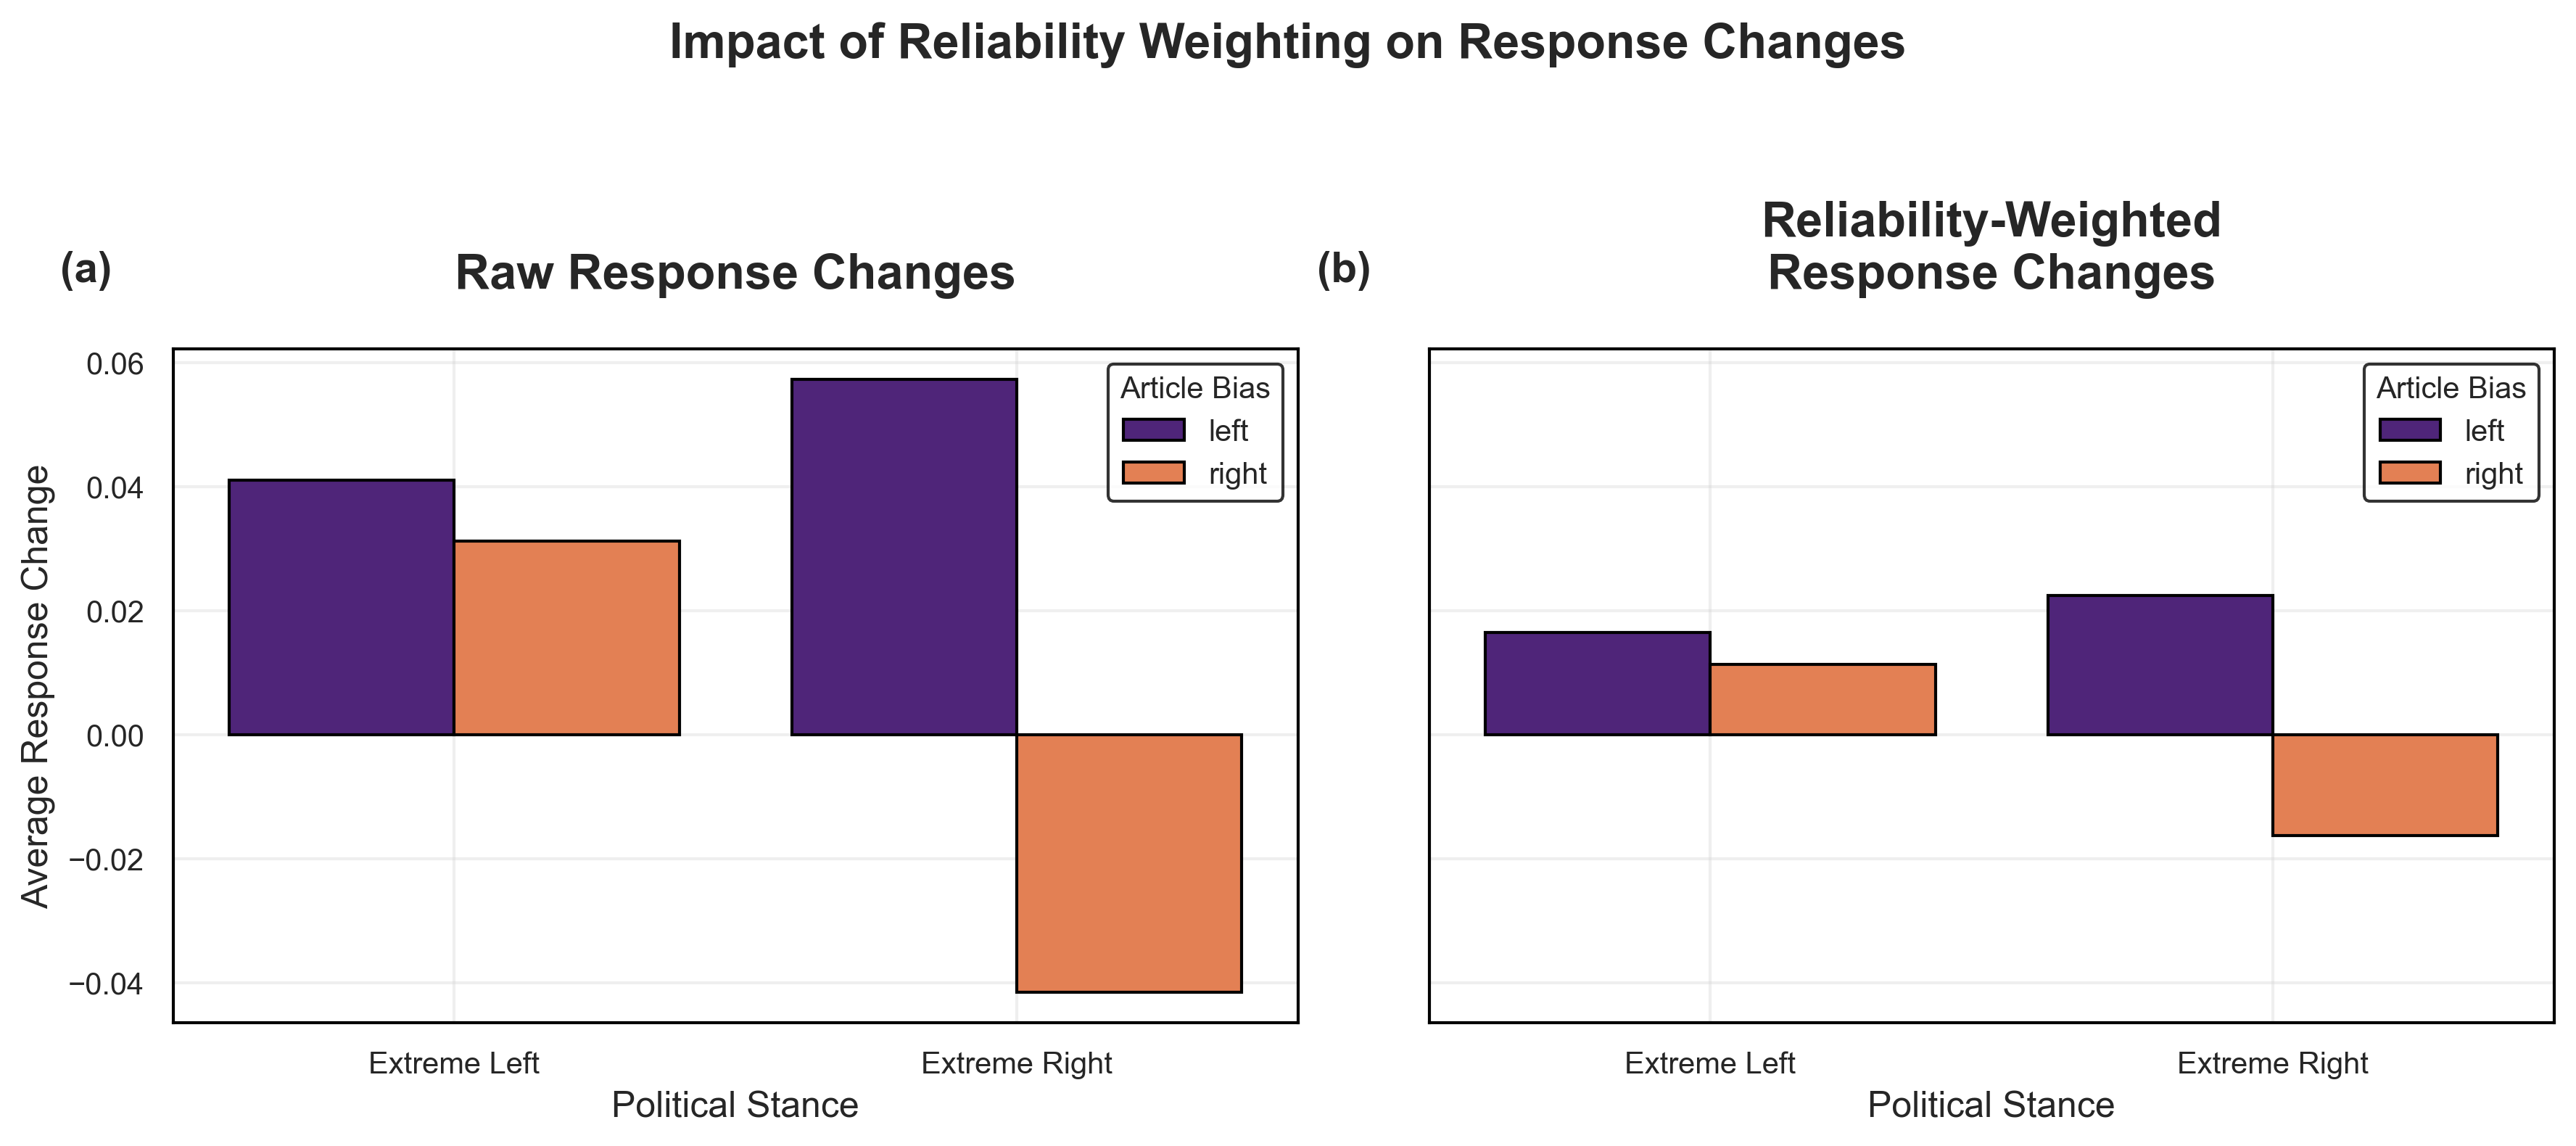

In [16]:
def plot_combined_average_response_change_by_group(merged_df):
    """
    Creates publication-ready side-by-side subplots showing average response changes.
    """
    PublicationStyle.set_style()
    
    # Prepare data
    mean_response_change_raw = merged_df.groupby(
        ['political_stance', 'bias'])['normalized_response_change'].mean().reset_index()
    mean_response_change_scaled = merged_df.groupby(
        ['political_stance', 'bias'])['weighted_response_change'].mean().reset_index()
    
    political_stance_order = ['Extreme Left', 'Extreme Right']
    bias_order = ['left', 'right']
    
    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    # Plot raw average response change
    sns.barplot(ax=axes[0], 
               data=mean_response_change_raw, 
               x='political_stance', 
               y='normalized_response_change', 
               hue='bias', 
               palette=[PublicationStyle.MAIN_COLORS['primary'], 
                       PublicationStyle.MAIN_COLORS['secondary']],
               order=political_stance_order,
               hue_order=bias_order,
               edgecolor='black')
    
    # Plot scaled average response change
    sns.barplot(ax=axes[1], 
               data=mean_response_change_scaled, 
               x='political_stance', 
               y='weighted_response_change', 
               hue='bias', 
               palette=[PublicationStyle.MAIN_COLORS['primary'], 
                       PublicationStyle.MAIN_COLORS['secondary']],
               order=political_stance_order,
               hue_order=bias_order,
               edgecolor='black'
               )
    
    # Format axes
    for ax, title in zip(axes, ['Raw Response Changes', 'Reliability-Weighted\nResponse Changes']):
        PublicationStyle.format_axis(
            ax,
            title=title,
            xlabel='Political Stance',
            ylabel='Average Response Change'
        )
        legend = ax.legend(title='Article Bias', frameon=True)
        legend.get_frame().set_edgecolor('black')
    
    # Add subplot labels
    PublicationStyle.add_figure_labels(fig)
    
    # Add main title
    plt.suptitle('Impact of Reliability Weighting on Response Changes', 
                fontsize=PublicationStyle.FONT_SIZES['title'],
                fontweight='bold',
                y=1.05)
    
    plt.tight_layout()
    return fig, axes

fig, axes = plot_combined_average_response_change_by_group(merged_responses_with_reliability)
PublicationStyle.save_figure(fig, 'response_changes.png')

In [17]:
# Creating complete data
merged_responses_with_reliability.to_csv("../data/processed/complete_data.csv", index=False)

# 3. Changes in Responses Analysis
All the steps take the reliability of the agent into account, i.e. how well its original responses (before exposure to biased articles) matched those of the human participant it was instructed to mimic.

## 3.1 Visualising the Responses Distribution

The two different kinds of responses (agreement vs disagreement, and concerned vs not concerned) are plotted separately.

**NOTE** USE IT WITH THE RIGHT DATAFRAME

In [18]:
def plot_response_distributions_by_scale(ax_agreement, ax_concern, data, title):
    """
    Creates distribution plots for agreement and concern scales on separate axes
    using histograms for discrete response values.
    """
    # Split data by scale type
    agreement_questions = ['F1A10_1', 'F3A3_1', 'F3A6_1', 'F3A7_1', 'F3A8_1']
    concern_questions = ['F2A6', 'F2A7', 'F2A9']
    
    agreement_data = data[data['question_code'].isin(agreement_questions)]
    concern_data = data[data['question_code'].isin(concern_questions)]
    
    # Plot histograms for agreement scale
    ax_agreement.hist(agreement_data['numeric_response_before'], 
                     bins=range(1, 9), # from 1 to 8 to create 7 bins
                     alpha=0.6,
                     color=PublicationStyle.MAIN_COLORS['primary'],
                     label='Before Exposure',
                     align='left')
    ax_agreement.hist(agreement_data['numeric_response_after'],
                     bins=range(1, 9),
                     alpha=0.6,
                     color=PublicationStyle.MAIN_COLORS['secondary'],
                     label='After Exposure',
                     align='left')
    
    # Plot histograms for concern scale
    ax_concern.hist(concern_data['numeric_response_before'],
                   bins=range(1, 7), # from 1 to 6 to create 5 bins
                   alpha=0.6,
                   color=PublicationStyle.MAIN_COLORS['primary'],
                   align='left')
    ax_concern.hist(concern_data['numeric_response_after'],
                   bins=range(1, 7),
                   alpha=0.6,
                   color=PublicationStyle.MAIN_COLORS['secondary'],
                   align='left')
    
    # Customize agreement scale subplot
    ax_agreement.set_title(f"{title}\nAgreement Scale (1-7)", 
                          fontsize=PublicationStyle.FONT_SIZES['subtitle'])
    ax_agreement.set_xlabel("Response Value")
    ax_agreement.set_ylabel("Count")
    ax_agreement.set_xlim(0.5, 7.5)
    ax_agreement.set_xticks(range(1, 8))
    
    # Customize concern scale subplot
    ax_concern.set_title(f"{title}\nConcern Scale (1-5)", 
                        fontsize=PublicationStyle.FONT_SIZES['subtitle'])
    ax_concern.set_xlabel("Response Value")
    ax_concern.set_ylabel("Count")
    ax_concern.set_xlim(0.5, 5.5)
    ax_concern.set_xticks(range(1, 6))
    
    # Add grid with lower opacity
    ax_agreement.grid(True, alpha=0.3)
    ax_concern.grid(True, alpha=0.3)

# The rest of your code remains the same
def plot_response_distributions_all_groups_with_scales(df_left_right, df_left_left, 
                                                     df_right_right, df_right_left):
    """
    Creates a publication-ready figure showing response distributions for all groups
    with higher positioned suptitle.
    """
    PublicationStyle.set_style()
    
    # Create figure with more height and explicit figure-level spacing
    fig = plt.figure(figsize=(12, 20), constrained_layout=False)
    
    # Create subplot grid with more space at top for suptitle
    gs = fig.add_gridspec(4, 2, top=0.88,
                         bottom=0.15,
                         left=0.1, 
                         right=0.95,
                         hspace=0.5, 
                         wspace=0.3)
    axes = gs.subplots()
    
    # Add main title higher up
    fig.suptitle("Response Distribution Before and After Article Exposure", 
                fontsize=PublicationStyle.FONT_SIZES['title'],
                fontweight='bold',
                y=0.93)
    
    plot_groups = [
        (df_left_right, "Extreme Left - Right-Biased Articles"),
        (df_left_left, "Extreme Left - Left-Biased Articles"),
        (df_right_right, "Extreme Right - Right-Biased Articles"),
        (df_right_left, "Extreme Right - Left-Biased Articles")
    ]
    
    for idx, (data, title) in enumerate(plot_groups):
        plot_response_distributions_by_scale(axes[idx, 0], axes[idx, 1], data, title)
    
    # Add a single legend for all subplots at the bottom
    handles = [
        plt.Rectangle((0,0), 1, 1, color=PublicationStyle.MAIN_COLORS['primary'], 
                     alpha=0.6, label='Before Exposure'),
        plt.Rectangle((0,0), 1, 1, color=PublicationStyle.MAIN_COLORS['secondary'], 
                     alpha=0.6, label='After Exposure')
    ]
    
    fig.legend(handles=handles, 
              loc='center',
              bbox_to_anchor=(0.5, 0.05),
              ncol=2, 
              fontsize=PublicationStyle.FONT_SIZES['legend'],
              frameon=True,
              edgecolor='black')
    
    # Add subplot labels
    for n, ax in enumerate(fig.axes):
        ax.text(-0.1, 1.1, f'({chr(97+n)})', transform=ax.transAxes, 
               size=14, weight='bold')
    
    return fig, axes

In [19]:
# separate the data based on the political stance: "Extreme Left", "Extreme Right". create 2 separate dataframes based on the merged_responses_with_reliability dataframe
df_left_left = merged_responses_with_reliability[(merged_responses_with_reliability['political_stance'] == 'Extreme Left') & (merged_responses_with_reliability['bias'] == 'left')]
df_left_right = merged_responses_with_reliability[(merged_responses_with_reliability['political_stance'] == 'Extreme Left') & (merged_responses_with_reliability['bias'] == 'right')]
df_right_left = merged_responses_with_reliability[(merged_responses_with_reliability['political_stance'] == 'Extreme Right') & (merged_responses_with_reliability['bias'] == 'left')]
df_right_right = merged_responses_with_reliability[(merged_responses_with_reliability['political_stance'] == 'Extreme Right') & (merged_responses_with_reliability['bias'] == 'right')]

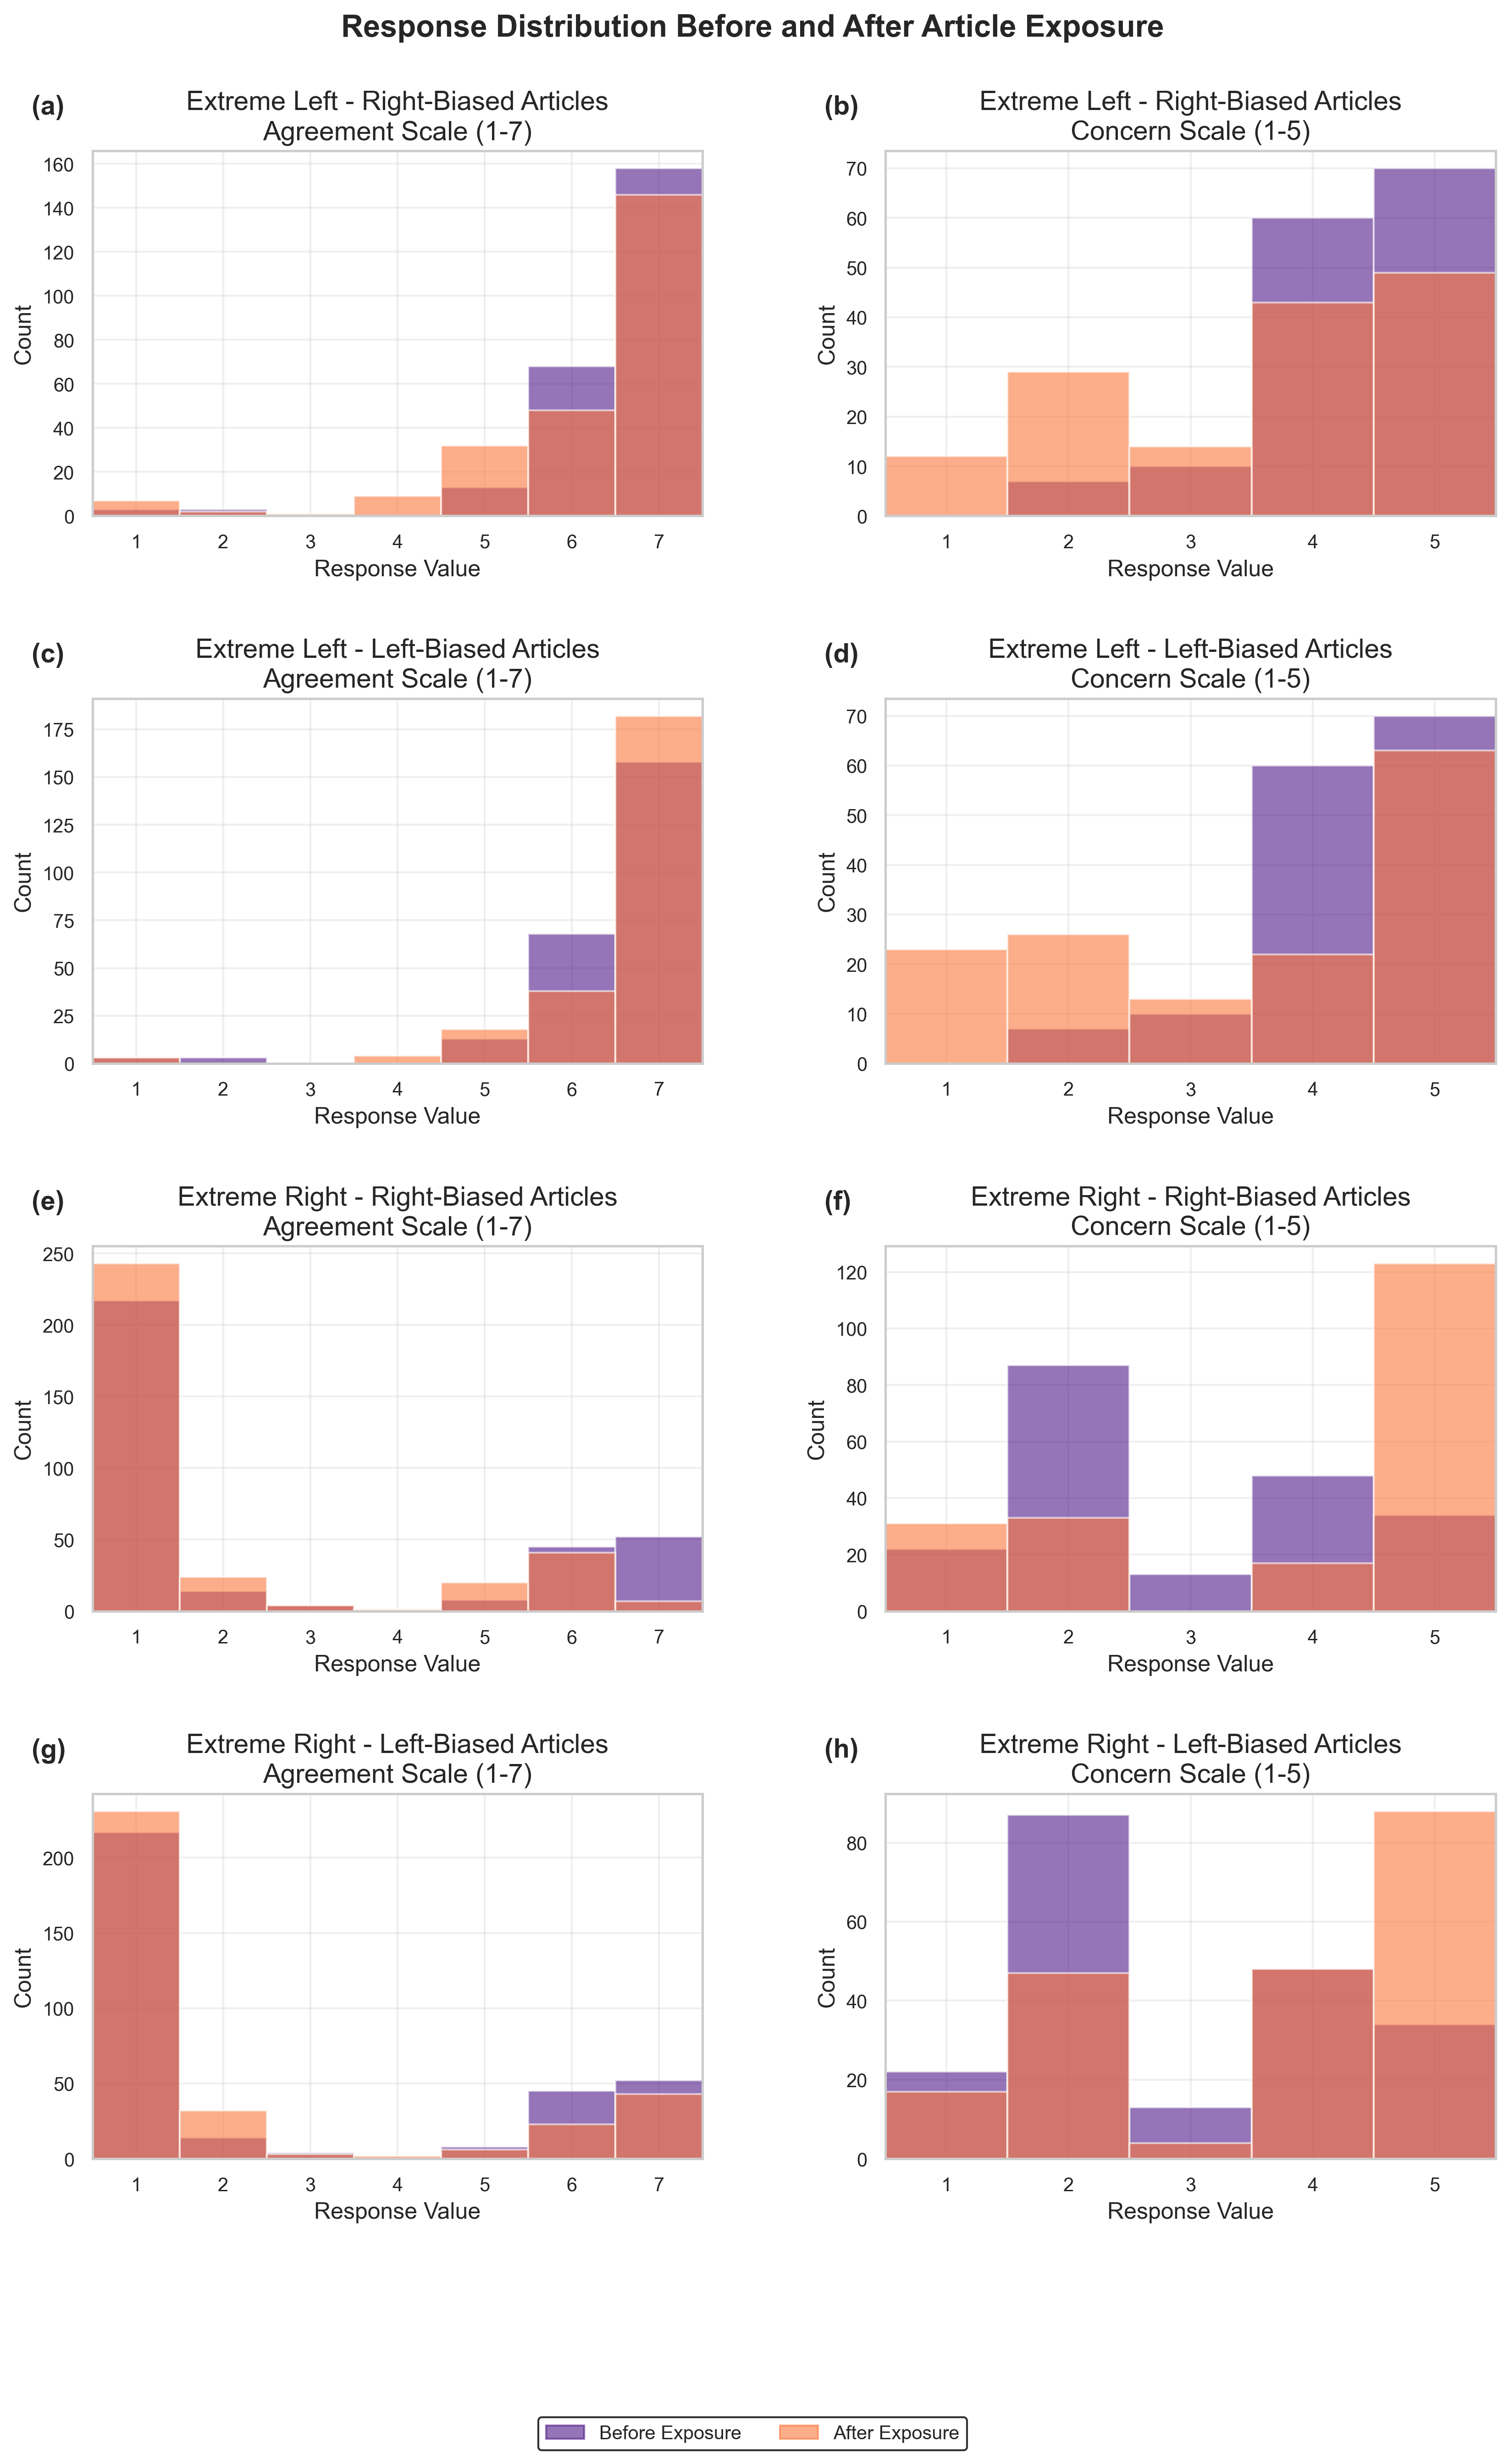

In [20]:
# Create the plots
fig, axes = plot_response_distributions_all_groups_with_scales(
    df_left_right, df_left_left, df_right_right, df_right_left
)

## 3.2 Overall Change in Responses 
This step aims to assess how much the responses changed in general after exposure to articles, regardless of the bias of the article. This involves calculating the average of the response_change across all agents and questions, and summarizing the overall shifts. One aspect to notice is that, in calculating summary statistics involving averages, positive and negative changes will cancel out.

In [21]:
# Summary of overall changes in responses, weighted by reliability score
def overall_changes_analysis_with_reliability(merged_df):
    # Calculate the overall weighted average change using normalized weighted response change
    weighted_avg_change = merged_df['weighted_response_change'].sum() / merged_df['reliability_score'].sum() if merged_df['reliability_score'].sum() != 0 else 0

    # Calculate counts of positive, negative, and no changes using the raw response change
    positive_changes = (merged_df['response_change'] > 0).sum()
    negative_changes = (merged_df['response_change'] < 0).sum()
    no_changes = (merged_df['response_change'] == 0).sum()

    return {
        'overall_weighted_avg_change': weighted_avg_change,
        'positive_changes': positive_changes,
        'negative_changes': negative_changes,
        'no_changes': no_changes
    }



# Generic function to print analysis results in a more readable format
def print_analysis_results(title, results):
    print(f"\n{title}:")
    
    for key, value in results.items():
        # Handle pandas Series and other complex types
        if isinstance(value, pd.Series):
            print(f"  - {key.replace('_', ' ').capitalize()}:")
            for idx, val in value.items():  # Use 'items()' instead of 'iteritems()'
                print(f"    - {idx}: {val}")
        
        # Handle the case where a descriptive statistics table (from .describe()) is included
        elif isinstance(value, pd.DataFrame) or isinstance(value, pd.Series) and 'count' in value.index:
            print(f"  - {key.replace('_', ' ').capitalize()} summary:")
            # Print descriptive stats in a readable format
            for stat_key, stat_val in value.items():
                print(f"    - {stat_key.capitalize()}: {stat_val:.3f}")
        
        # Format float values to 3 decimal places, otherwise print as-is
        elif isinstance(value, (float, np.float64)):
            print(f"  - {key.replace('_', ' ').capitalize()}: {value:.3f}")
        
        # Handle general integer or string cases
        else:
            print(f"  - {key.replace('_', ' ').capitalize()}: {value}")

# Perform the overall changes analysis with reliability
overall_changes_with_reliability = overall_changes_analysis_with_reliability(merged_responses_with_reliability)
print_analysis_results("Overall Changes in Responses (Normalized and Weighted by Reliability)", overall_changes_with_reliability)



Overall Changes in Responses (Normalized and Weighted by Reliability):
  - Overall weighted avg change: 0.020
  - Positive changes: 471
  - Negative changes: 442
  - No changes: 959


Positive changes, as explained above, indicate an increase of agreement or concern. 

## 3.3 Overall Change in Responses Given Left or Right Bias
Here, we include the bias of the articles and therefore analyze the overall differences in user responses after exposure to left-wing versus right-wing biased articles, regardless of the political position of the agents.
In other words, which changes have the biases produced?

In [22]:
# Function to compare response changes between left- and right-biased articles, weighted by reliability
def compare_left_right_bias_with_reliability(merged_df):
    """
    Compare response changes between left- and right-biased articles,
    using the pre-calculated weighted response change that accounts
    for scale differences and reliability scores.

    Parameters:
    - merged_df (DataFrame): A DataFrame containing:
        - 'bias': Bias type of article exposure ('left' or 'right').
        - 'weighted_response_change': Normalized and weighted change in response.
        - 'response_change': Raw change in user responses before and after exposure.

    Returns:
    - dict: {
        'weighted_avg_left_change': Weighted avg. response change for left-biased articles.
        'weighted_avg_right_change': Weighted avg. response change for right-biased articles.
        'left_summary': Summary statistics of response changes for left-biased articles.
        'right_summary': Summary statistics of response changes for right-biased articles.
    }

    Notes:
    - This function now directly uses `weighted_response_change`.
    - The summary statistics are based on the raw `response_change`.
    """
    
    # Calculate weighted average response changes for left and right biases
    weighted_avg_left_change = merged_df[merged_df['bias'] == 'left']['weighted_response_change'].mean()
    weighted_avg_right_change = merged_df[merged_df['bias'] == 'right']['weighted_response_change'].mean()

    # Summary statistics for left and right biases (using raw response changes)
    left_summary = merged_df[merged_df['bias'] == 'left']['response_change'].describe()
    right_summary = merged_df[merged_df['bias'] == 'right']['response_change'].describe()

    return {
        'weighted_avg_left_change': weighted_avg_left_change,
        'weighted_avg_right_change': weighted_avg_right_change,
        'left_summary': left_summary,
        'right_summary': right_summary
    }


# Perform the bias comparison with reliability
# Perform the bias comparison with reliability
bias_comparison_with_reliability = compare_left_right_bias_with_reliability(merged_responses_with_reliability)
print_analysis_results("Comparison of Response Changes Between Left and Right Bias (Weighted by Reliability):", bias_comparison_with_reliability)




Comparison of Response Changes Between Left and Right Bias (Weighted by Reliability)::
  - Weighted avg left change: 0.020
  - Weighted avg right change: -0.005
  - Left summary:
    - count: 936.0
    - mean: 0.0405982905982906
    - std: 1.7306476995181144
    - min: -6.0
    - 25%: 0.0
    - 50%: 0.0
    - 75%: 1.0
    - max: 4.0
  - Right summary:
    - count: 936.0
    - mean: -0.27884615384615385
    - std: 1.9562654462245515
    - min: -6.0
    - 25%: 0.0
    - 50%: 0.0
    - 75%: 0.0
    - max: 4.0


C:\Users\miria\AppData\Local\Temp\ipykernel_31156\553063524.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax,
C:\Users\miria\AppData\Local\Temp\ipykernel_31156\553063524.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Left-Biased', 'Right-Biased'])


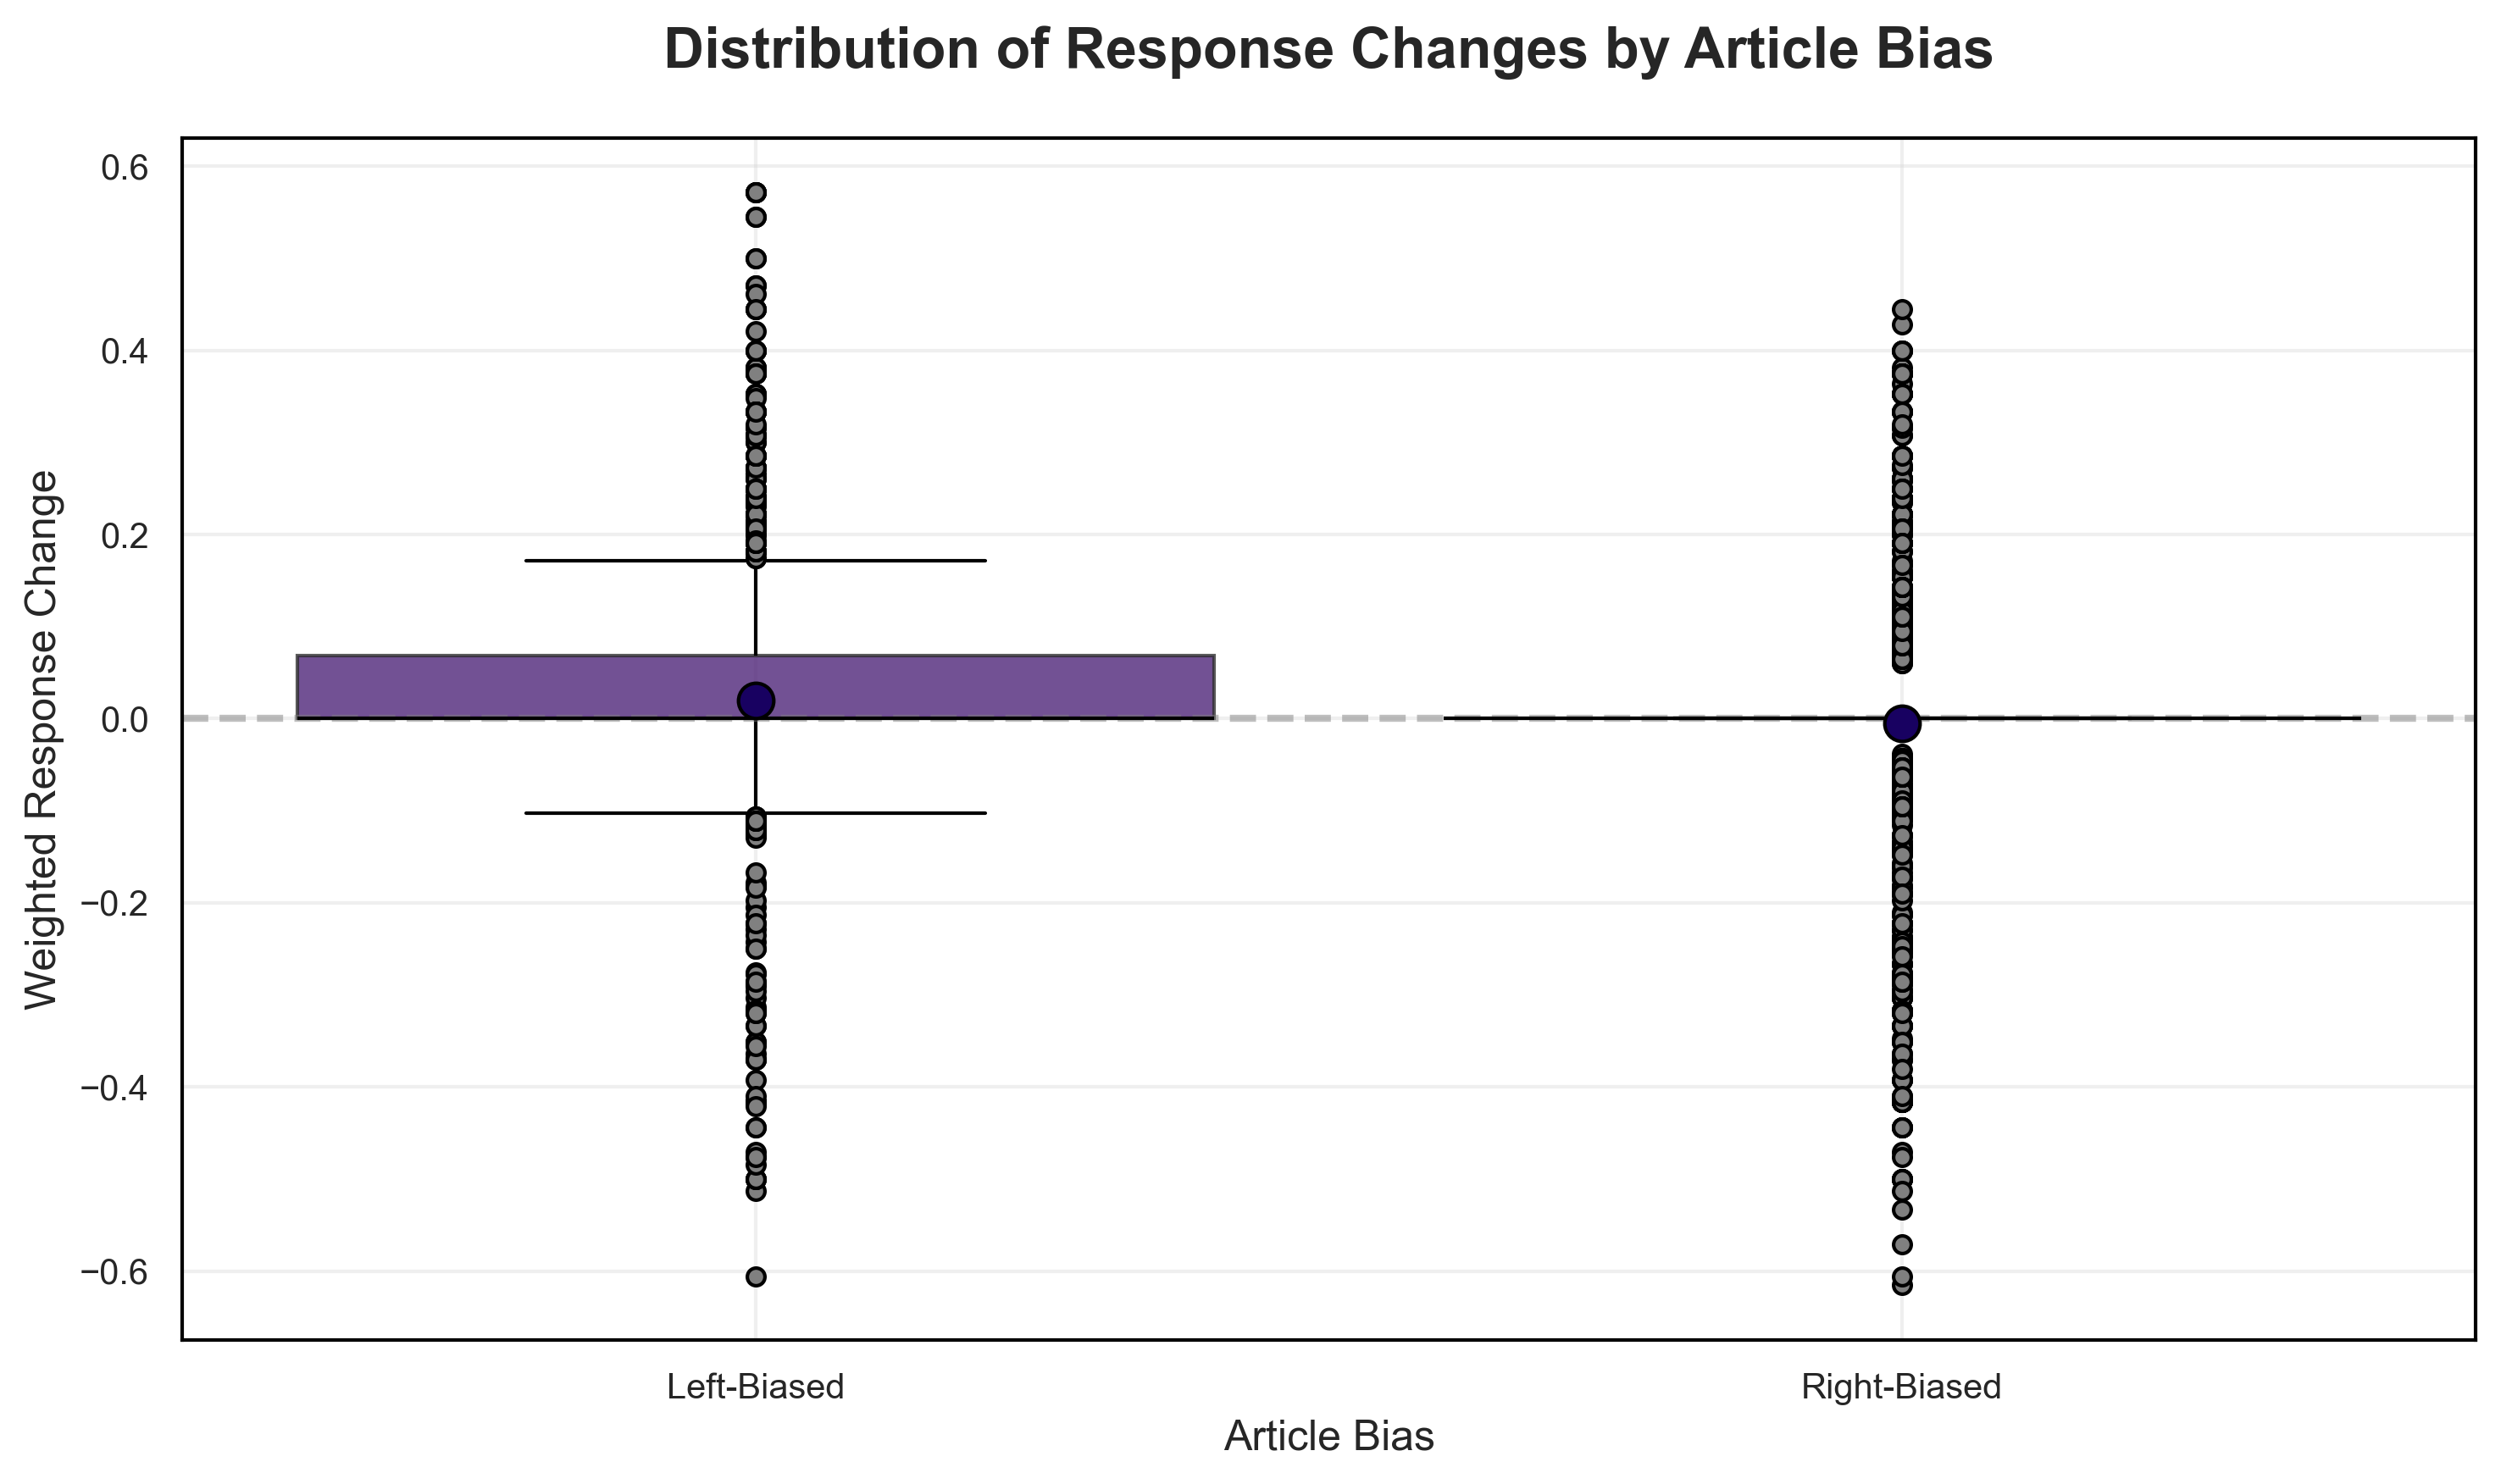

In [23]:
def plot_response_changes_boxplot(merged_responses_with_reliability):
    """
    Creates a publication-ready boxplot showing the distribution of weighted response
    changes by article bias.
    """
    PublicationStyle.set_style()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create enhanced box plot
    sns.boxplot(ax=ax,
                x='bias', 
                y='weighted_response_change', 
                data=merged_responses_with_reliability, 
                palette=[PublicationStyle.MAIN_COLORS['primary'], 
                        PublicationStyle.MAIN_COLORS['secondary']],
                showmeans=True,
                meanprops={"marker": "o", 
                          "markerfacecolor": PublicationStyle.MAIN_COLORS['accent1'],
                          "markeredgecolor": "black",
                          "markersize": "10"},
                medianprops={"color": "black"},
                flierprops={"marker": "o",
                           "markerfacecolor": "gray",
                           "markeredgecolor": "black",
                           "markersize": "5"},
                boxprops={"alpha": 0.8},
                whiskerprops={"color": "black"},
                capprops={"color": "black"})
    
    # Format axis
    PublicationStyle.format_axis(
        ax,
        title='Distribution of Response Changes by Article Bias',
        xlabel='Article Bias',
        ylabel='Weighted Response Change'
    )
    
    # Customize box appearance
    ax.set_xticklabels(['Left-Biased', 'Right-Biased'])
    
    # Add horizontal line at y=0 for reference
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Optional: Add subtle grid only for y-axis
    ax.grid(axis='y', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

# Example usage:
fig, ax = plot_response_changes_boxplot(merged_responses_with_reliability)


## 3.4 Overall Difference in Responses Between by Question
Here, we analyze how each question changed after exposure to biased content (regardless of the type of bias introduced) and also regardless of the political stance of the users.

In [24]:
# Function to analyze overall differences in responses by question, using scaled change
def analyze_differences_by_question_with_reliability(merged_df):
    # Group by question_code and calculate statistics for each question using weighted_response_change
    question_analysis = merged_df.groupby('question_code').agg(
        # Calculate weighted average directly using weighted_response_change
        weighted_avg_change=('weighted_response_change', 'mean'),  # Since weighted_response_change is already weighted
        count=('response_change', 'count'),
        std_change=('response_change', 'std'),
        min_change=('response_change', 'min'),
        max_change=('response_change', 'max'),
        median_change=('response_change', 'median')
    ).reset_index()

    # Divide by the total reliability score to get the proper weighted average
    question_analysis['weighted_avg_change'] /= merged_df.groupby('question_code')['reliability_score'].sum().values

    # Sort the results by the weighted average change to identify the most impacted questions
    question_analysis = question_analysis.sort_values(by='weighted_avg_change', ascending=False)

    return question_analysis

analyze_differences_by_question_with_reliability(merged_responses_with_reliability)

question_code  weighted_avg_change  count  std_change  min_change  \
2          F2A7             0.001565    234    1.277448           0   
3          F2A9             0.001392    234    1.184039           0   
1          F2A6             0.001139    234    1.139712           0   
5        F3A6_1            -0.000095    234    0.661086          -6   
6        F3A7_1            -0.000187    234    0.645419          -3   
7        F3A8_1            -0.000373    234    1.208387          -6   
4        F3A3_1            -0.001350    234    1.835580          -6   
0       F1A10_1            -0.001421    234    2.294553          -6   

   max_change  median_change  
2           4            1.0  
3           4            1.0  
1           4            1.0  
5           0            0.0  
6           0            0.0  
7           0            0.0  
4           0           -1.0  
0           0           -1.0

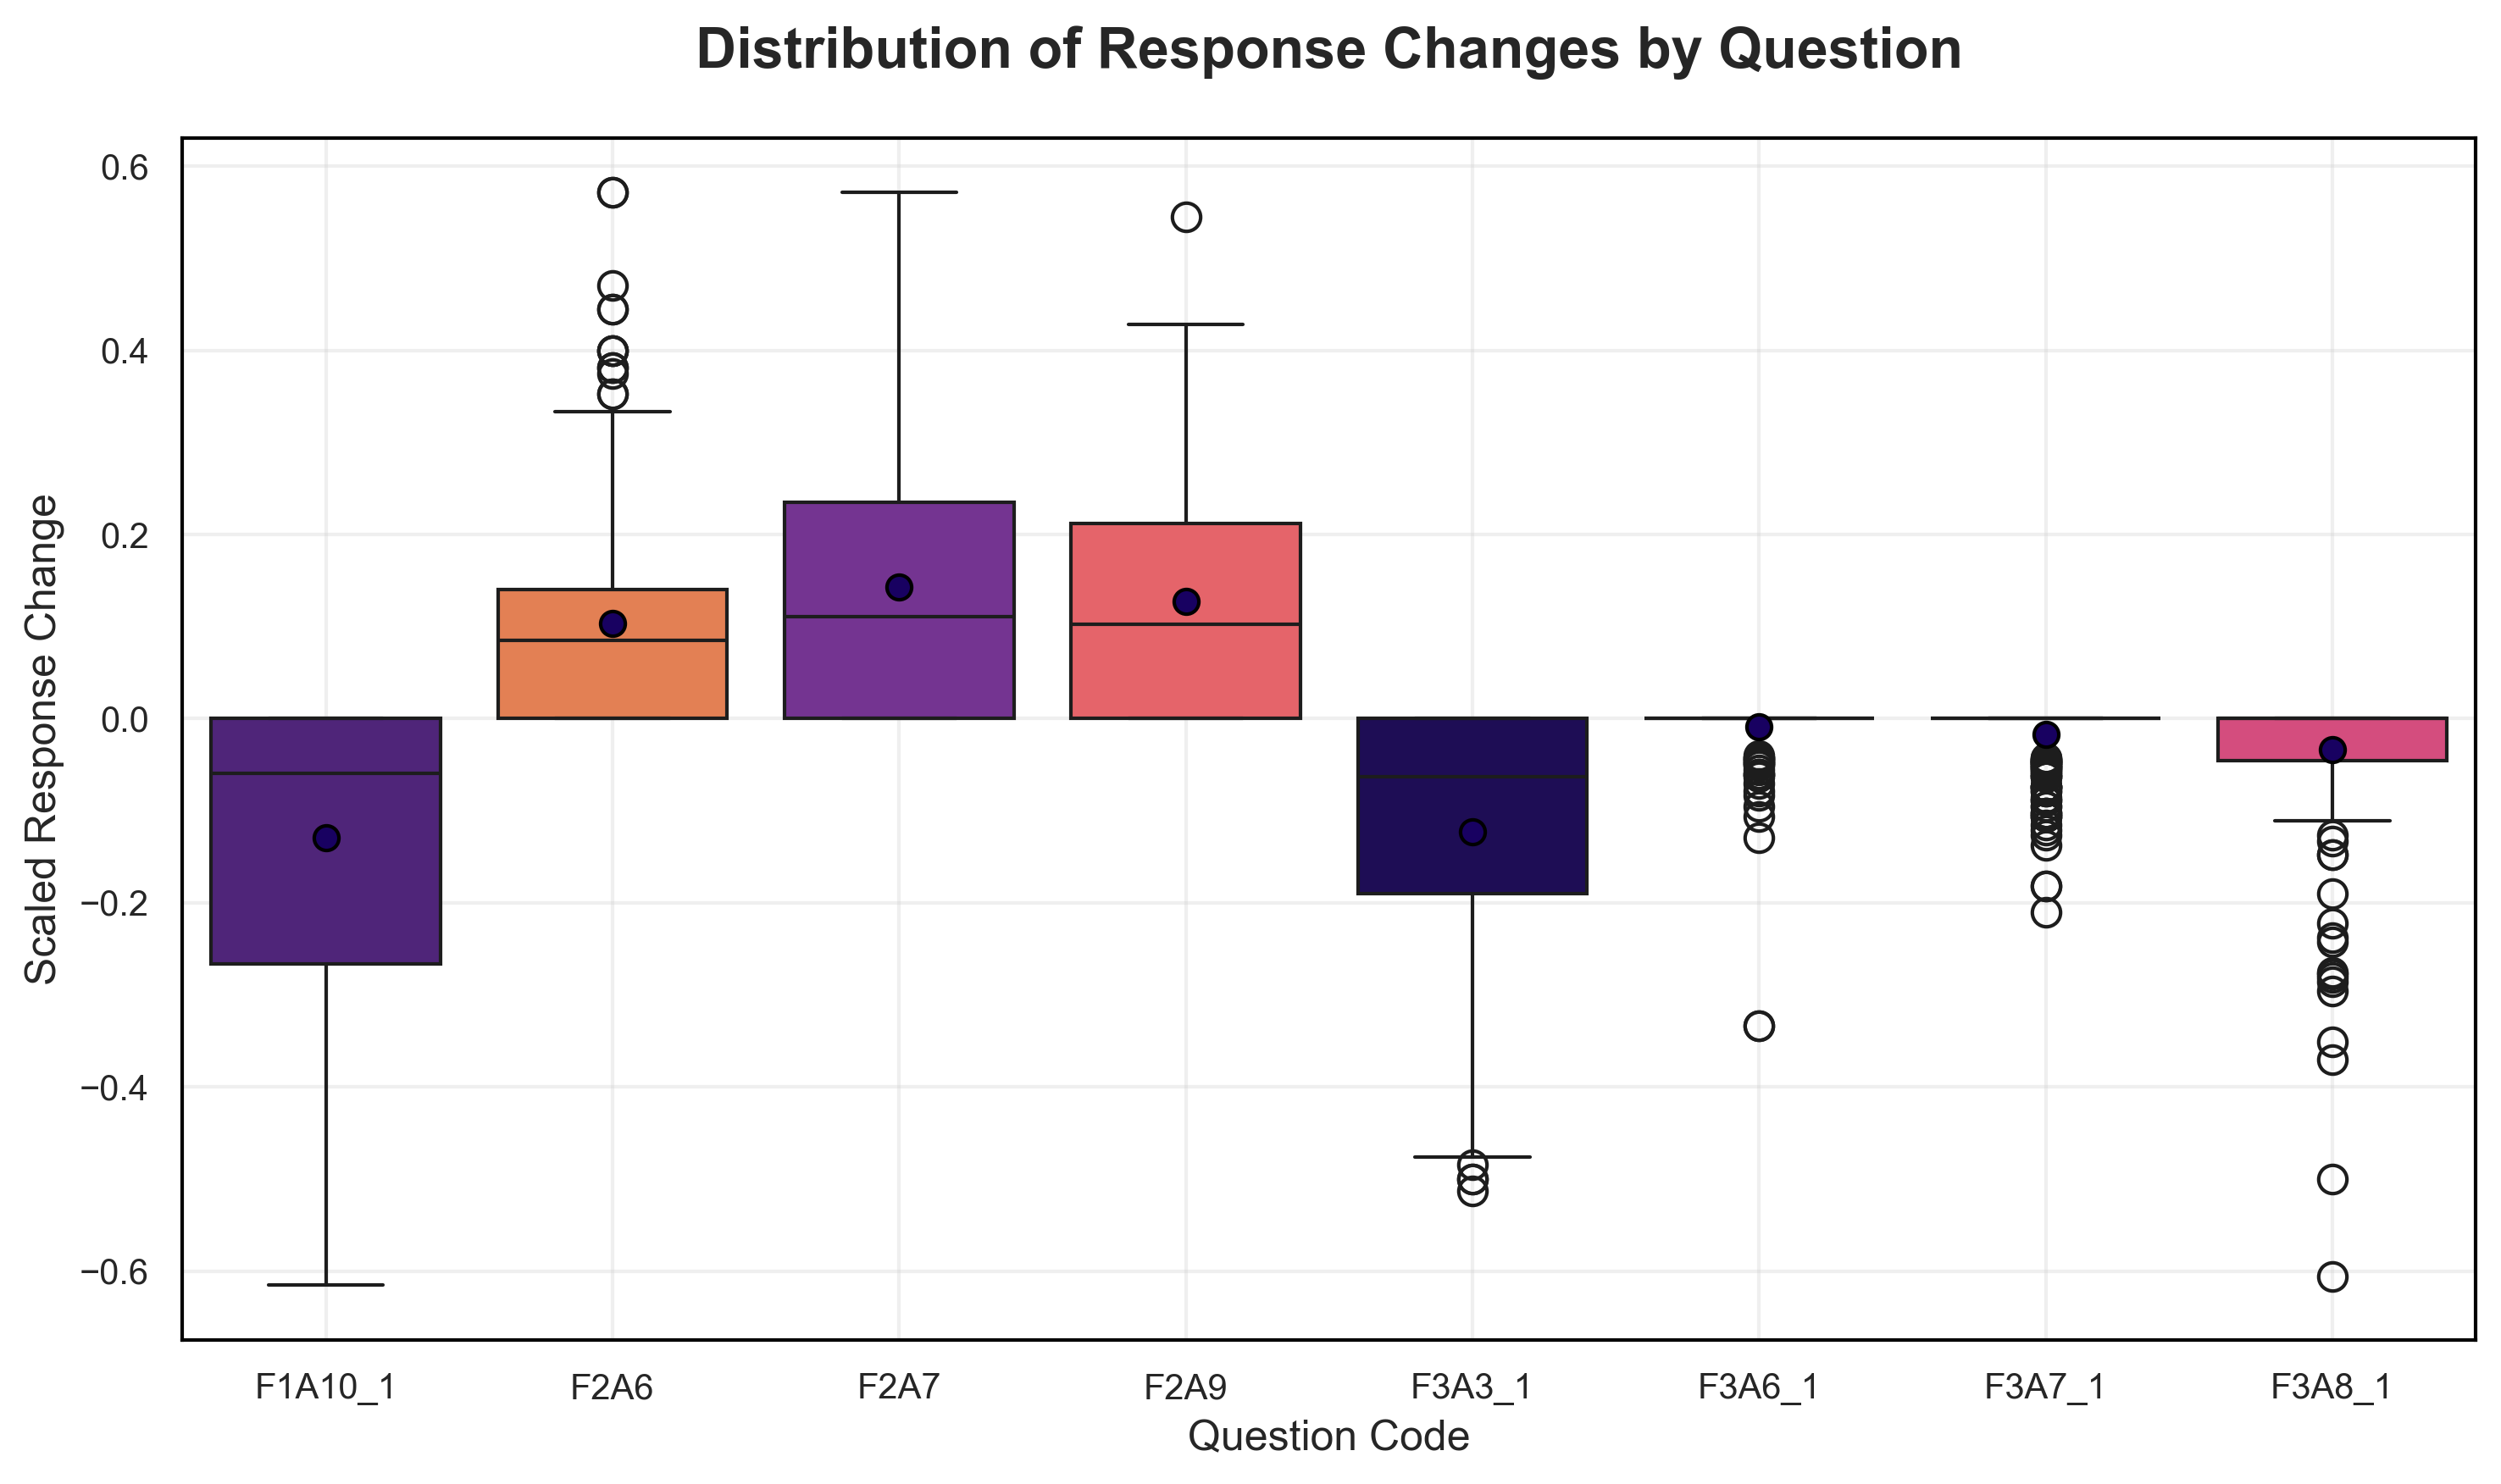

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_response_distribution_plot(data):
    """
    Create a box plot showing the distribution of response changes by question
    using the PublicationStyle guidelines.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing 'question_code' and 'weighted_response_change' columns
    """
    # Set the style
    PublicationStyle.set_style()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the box plot
    sns.boxplot(
        x='question_code', 
        y='weighted_response_change', 
        hue='question_code',
        data=data,
        palette=PublicationStyle.PALETTE,
        dodge=False,
        legend=False,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": PublicationStyle.MAIN_COLORS['accent1'],
            "markeredgecolor": "black",
            "markersize": "7"
        },
        ax=ax
    )
    
    # Format the axis using PublicationStyle
    PublicationStyle.format_axis(
        ax=ax,
        title='Distribution of Response Changes by Question',
        xlabel='Question Code',
        ylabel='Scaled Response Change',
        rotation=45
    )
    
    # Adjust layout
    plt.tight_layout()
    
    return fig, ax

# Create the plot
fig, ax = create_response_distribution_plot(merged_responses_with_reliability)

# Save the figure if needed
# PublicationStyle.save_figure(fig, 'response_distribution.png')

plt.show()

## 3.5 Overall Differences in Responses by Political Group
Here, we analyze how agents belonging to different political groups (Extreme Right vs Extreme Left) changed their responses after having been exposed to biased articles (regardless of the type of bias introduced). 


In [26]:
# Function to analyze overall differences in responses by political group, weighted by reliability
def analyze_differences_by_political_group_with_reliability(merged_df):
    # Group by political stance and calculate weighted statistics for each group
    political_group_analysis = merged_df.groupby('political_stance').agg(
       weighted_avg_change=('weighted_response_change', 'mean'),
        count=('weighted_response_change', 'count'),
        std_change=('response_change', 'std'),
        min_change=('response_change', 'min'),
        max_change=('response_change', 'max'),
        median_change=('response_change', 'median')
    ).reset_index()

    # Sort the results by the weighted average change to identify the most impacted groups
    political_group_analysis = political_group_analysis.sort_values(by='weighted_avg_change', ascending=False)

    return political_group_analysis

# Perform the analysis by political group with reliability
political_group_analysis_results = analyze_differences_by_political_group_with_reliability(merged_responses_with_reliability)

# Display the results in a readable format
print_analysis_results("Differences in Responses by Political Group (Weighted by Reliability)", political_group_analysis_results.to_dict(orient='list'))



Differences in Responses by Political Group (Weighted by Reliability):
  - Political stance: ['Extreme Left', 'Extreme Right']
  - Weighted avg change: [0.013916673238024278, 0.0030991057828878457]
  - Count: [784, 1088]
  - Std change: [1.3556073809294797, 2.137097183435669]
  - Min change: [-6, -6]
  - Max change: [4, 4]
  - Median change: [0.0, 0.0]


C:\Users\miria\AppData\Local\Temp\ipykernel_31156\814568228.py:22: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(


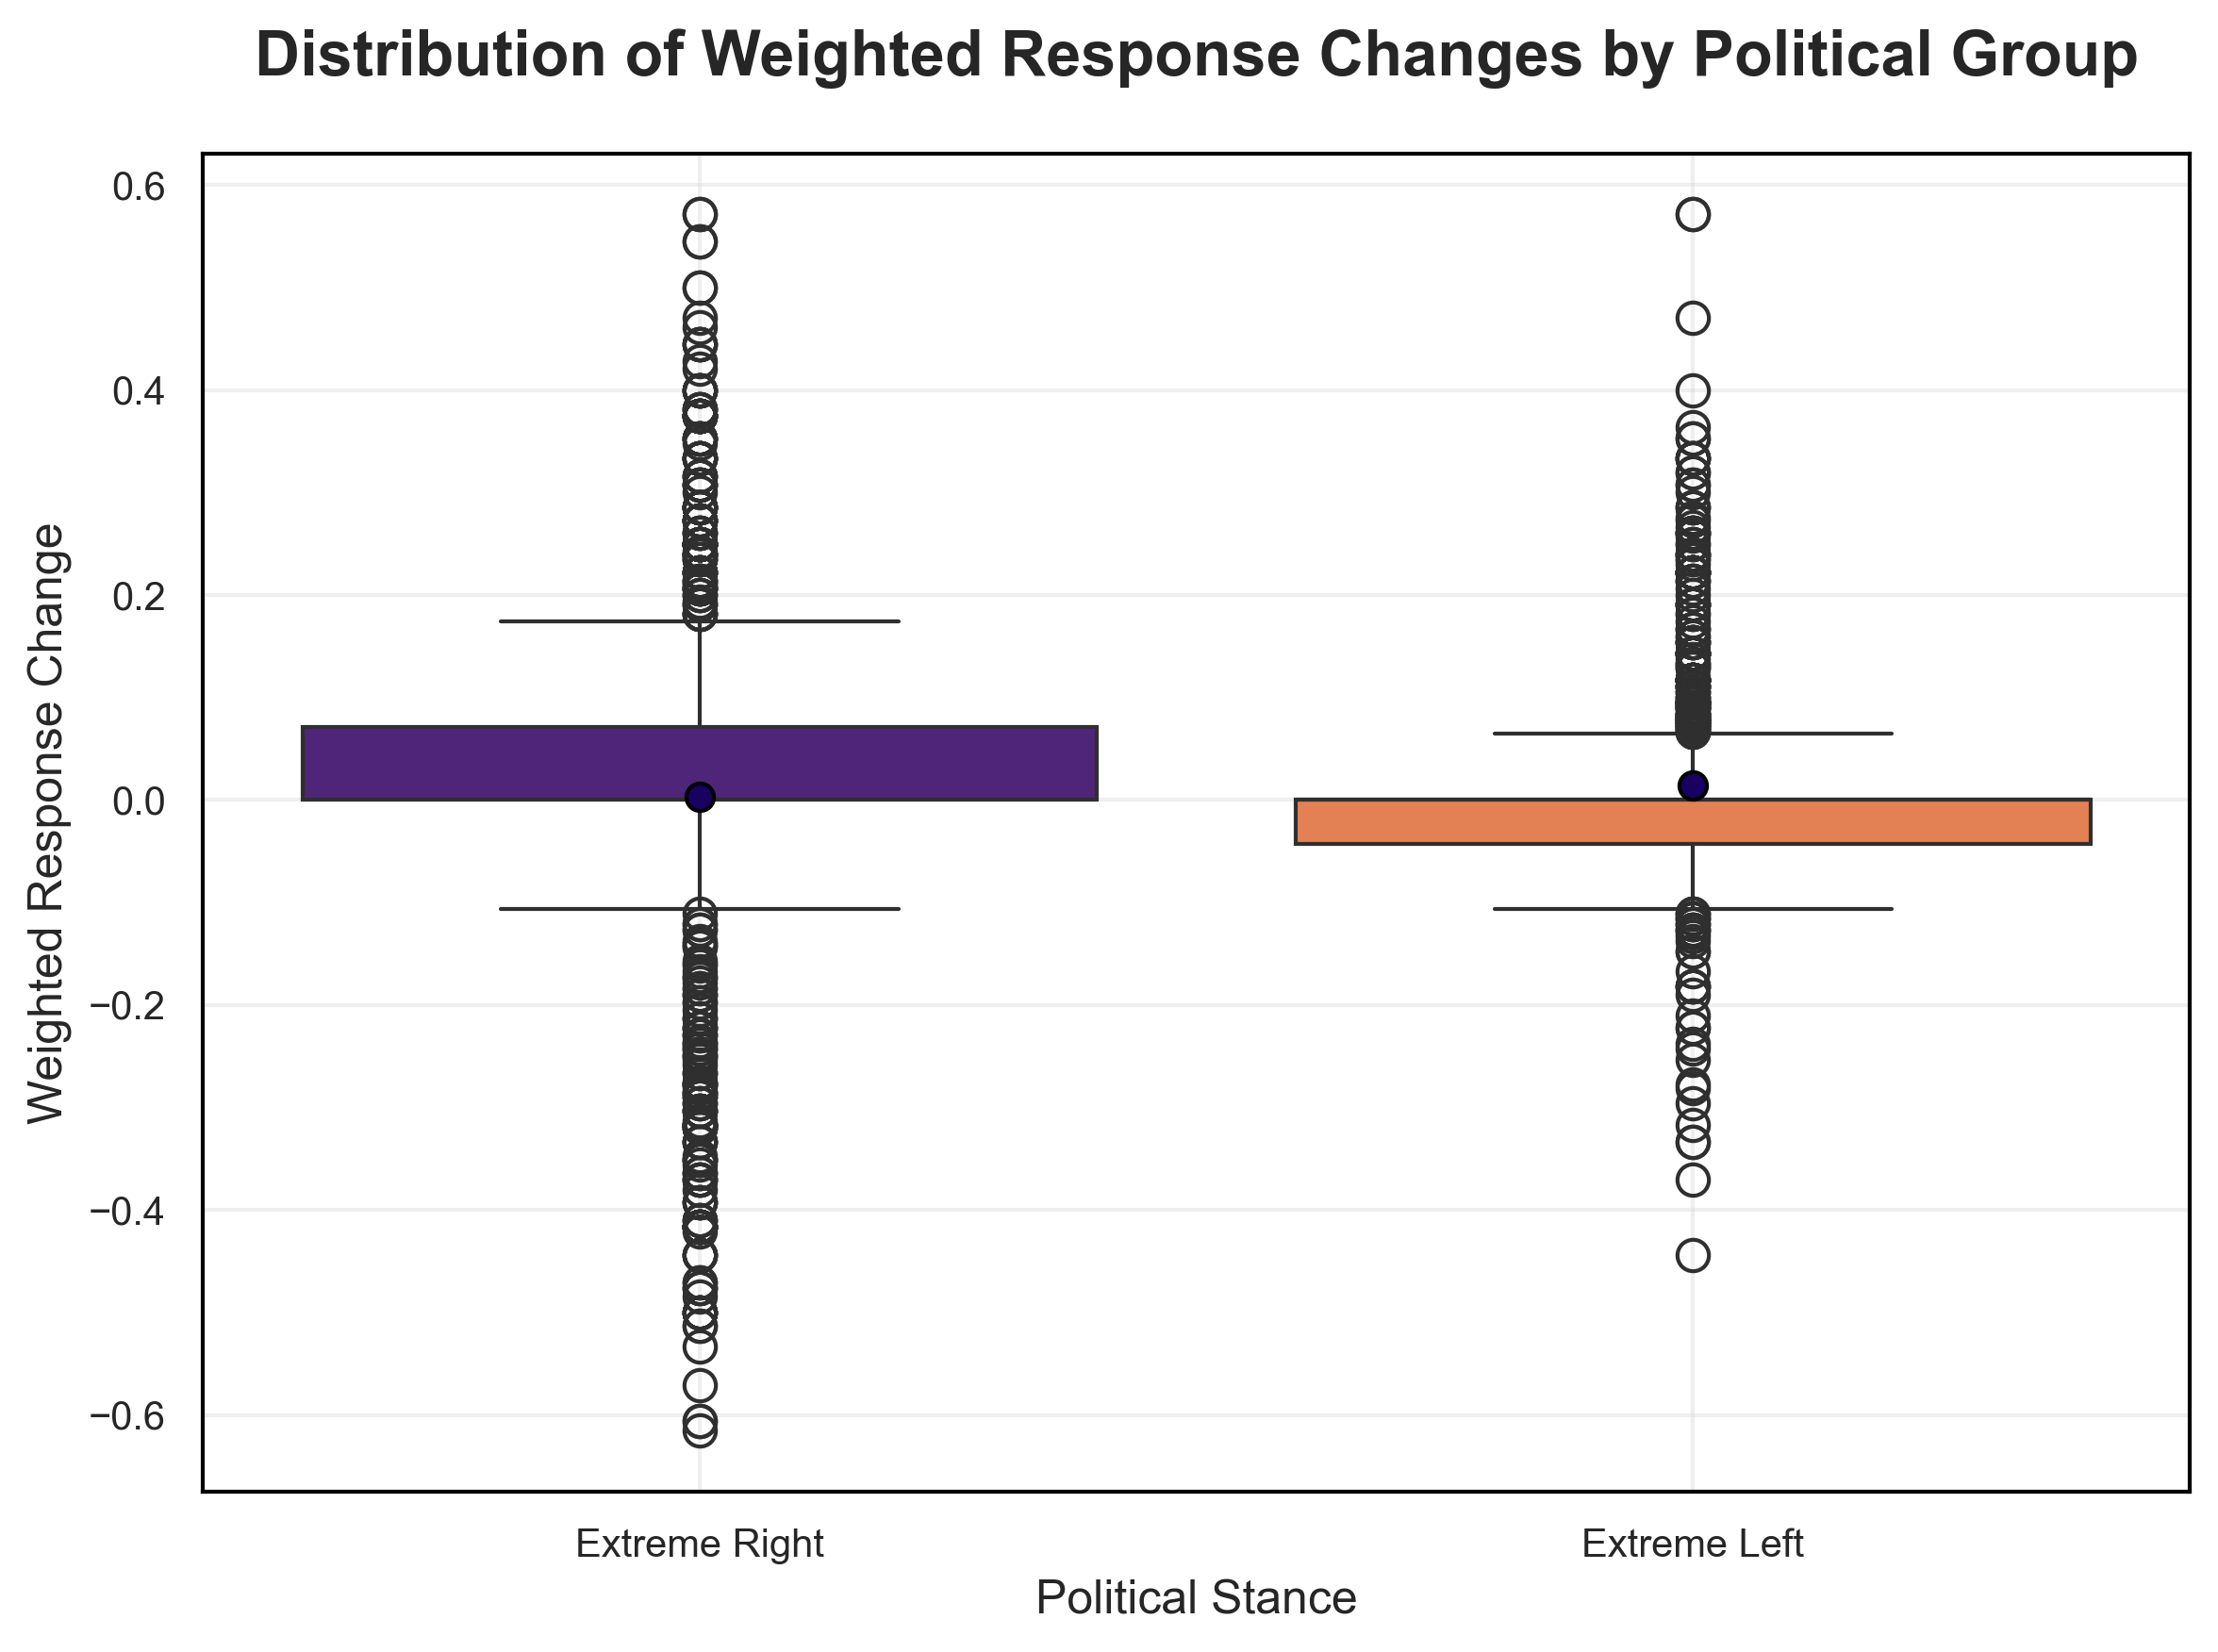

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_political_response_plot(data):
    """
    Create a box plot showing the distribution of weighted response changes by political stance
    using the PublicationStyle guidelines.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing 'political_stance' and 'weighted_response_change' columns
    """
    # Set the style
    PublicationStyle.set_style()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create the box plot
    sns.boxplot(
        x='political_stance', 
        y='weighted_response_change',
        hue='political_stance',
        data=data,
        palette=PublicationStyle.PALETTE,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": PublicationStyle.MAIN_COLORS['accent1'],
            "markeredgecolor": "black",
            "markersize": "7"
        },
        ax=ax
    )
    
    # Format the axis using PublicationStyle
    PublicationStyle.format_axis(
        ax=ax,
        title='Distribution of Weighted Response Changes by Political Group',
        xlabel='Political Stance',
        ylabel='Weighted Response Change'
    )
    
    # Adjust layout to accommodate legend
    plt.tight_layout()
    
    return fig, ax

# Create the plot
fig, ax = create_political_response_plot(merged_responses_with_reliability)

# Save the figure if needed
# PublicationStyle.save_figure(fig, 'political_response_distribution.png')

plt.show()

## 3.6 Differences in responses by article bias
Here, we analyze which type of bias (right, left) is associated with the biggest change in responses across all agents, regardless of their political stance.

--> Check similarity with section 3.3


In [28]:
# Function to analyze differences in responses by article bias, weighted by reliability
def analyze_differences_by_article_bias_only_with_reliability(merged_df):
    # Group by article bias and calculate weighted statistics for response changes
    bias_analysis = merged_df.groupby('bias').agg(
        weighted_avg_change=('weighted_response_change', 'mean'), 
        count=('response_change', 'count'),
        std_change=('response_change', 'std'),
        min_change=('response_change', 'min'),
        max_change=('response_change', 'max'),
        median_change=('response_change', 'median')
    ).reset_index()


    # Sort the results by the weighted average change to easily compare bias impact
    bias_analysis = bias_analysis.sort_values(by='weighted_avg_change', ascending=False)

    return bias_analysis

# Perform the analysis by article bias only with reliability
bias_only_analysis_results = analyze_differences_by_article_bias_only_with_reliability(merged_responses_with_reliability)

# Display the results in a readable format
print_analysis_results("Differences in Responses by Article Bias (Weighted by Reliability)", bias_only_analysis_results.to_dict(orient='list'))



Differences in Responses by Article Bias (Weighted by Reliability):
  - Bias: ['left', 'right']
  - Weighted avg change: [0.019969470422487375, -0.004710390390016209]
  - Count: [936, 936]
  - Std change: [1.730647699518114, 1.9562654462245521]
  - Min change: [-6, -6]
  - Max change: [4, 4]
  - Median change: [0.0, 0.0]


C:\Users\miria\AppData\Local\Temp\ipykernel_31156\3468736973.py:22: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(


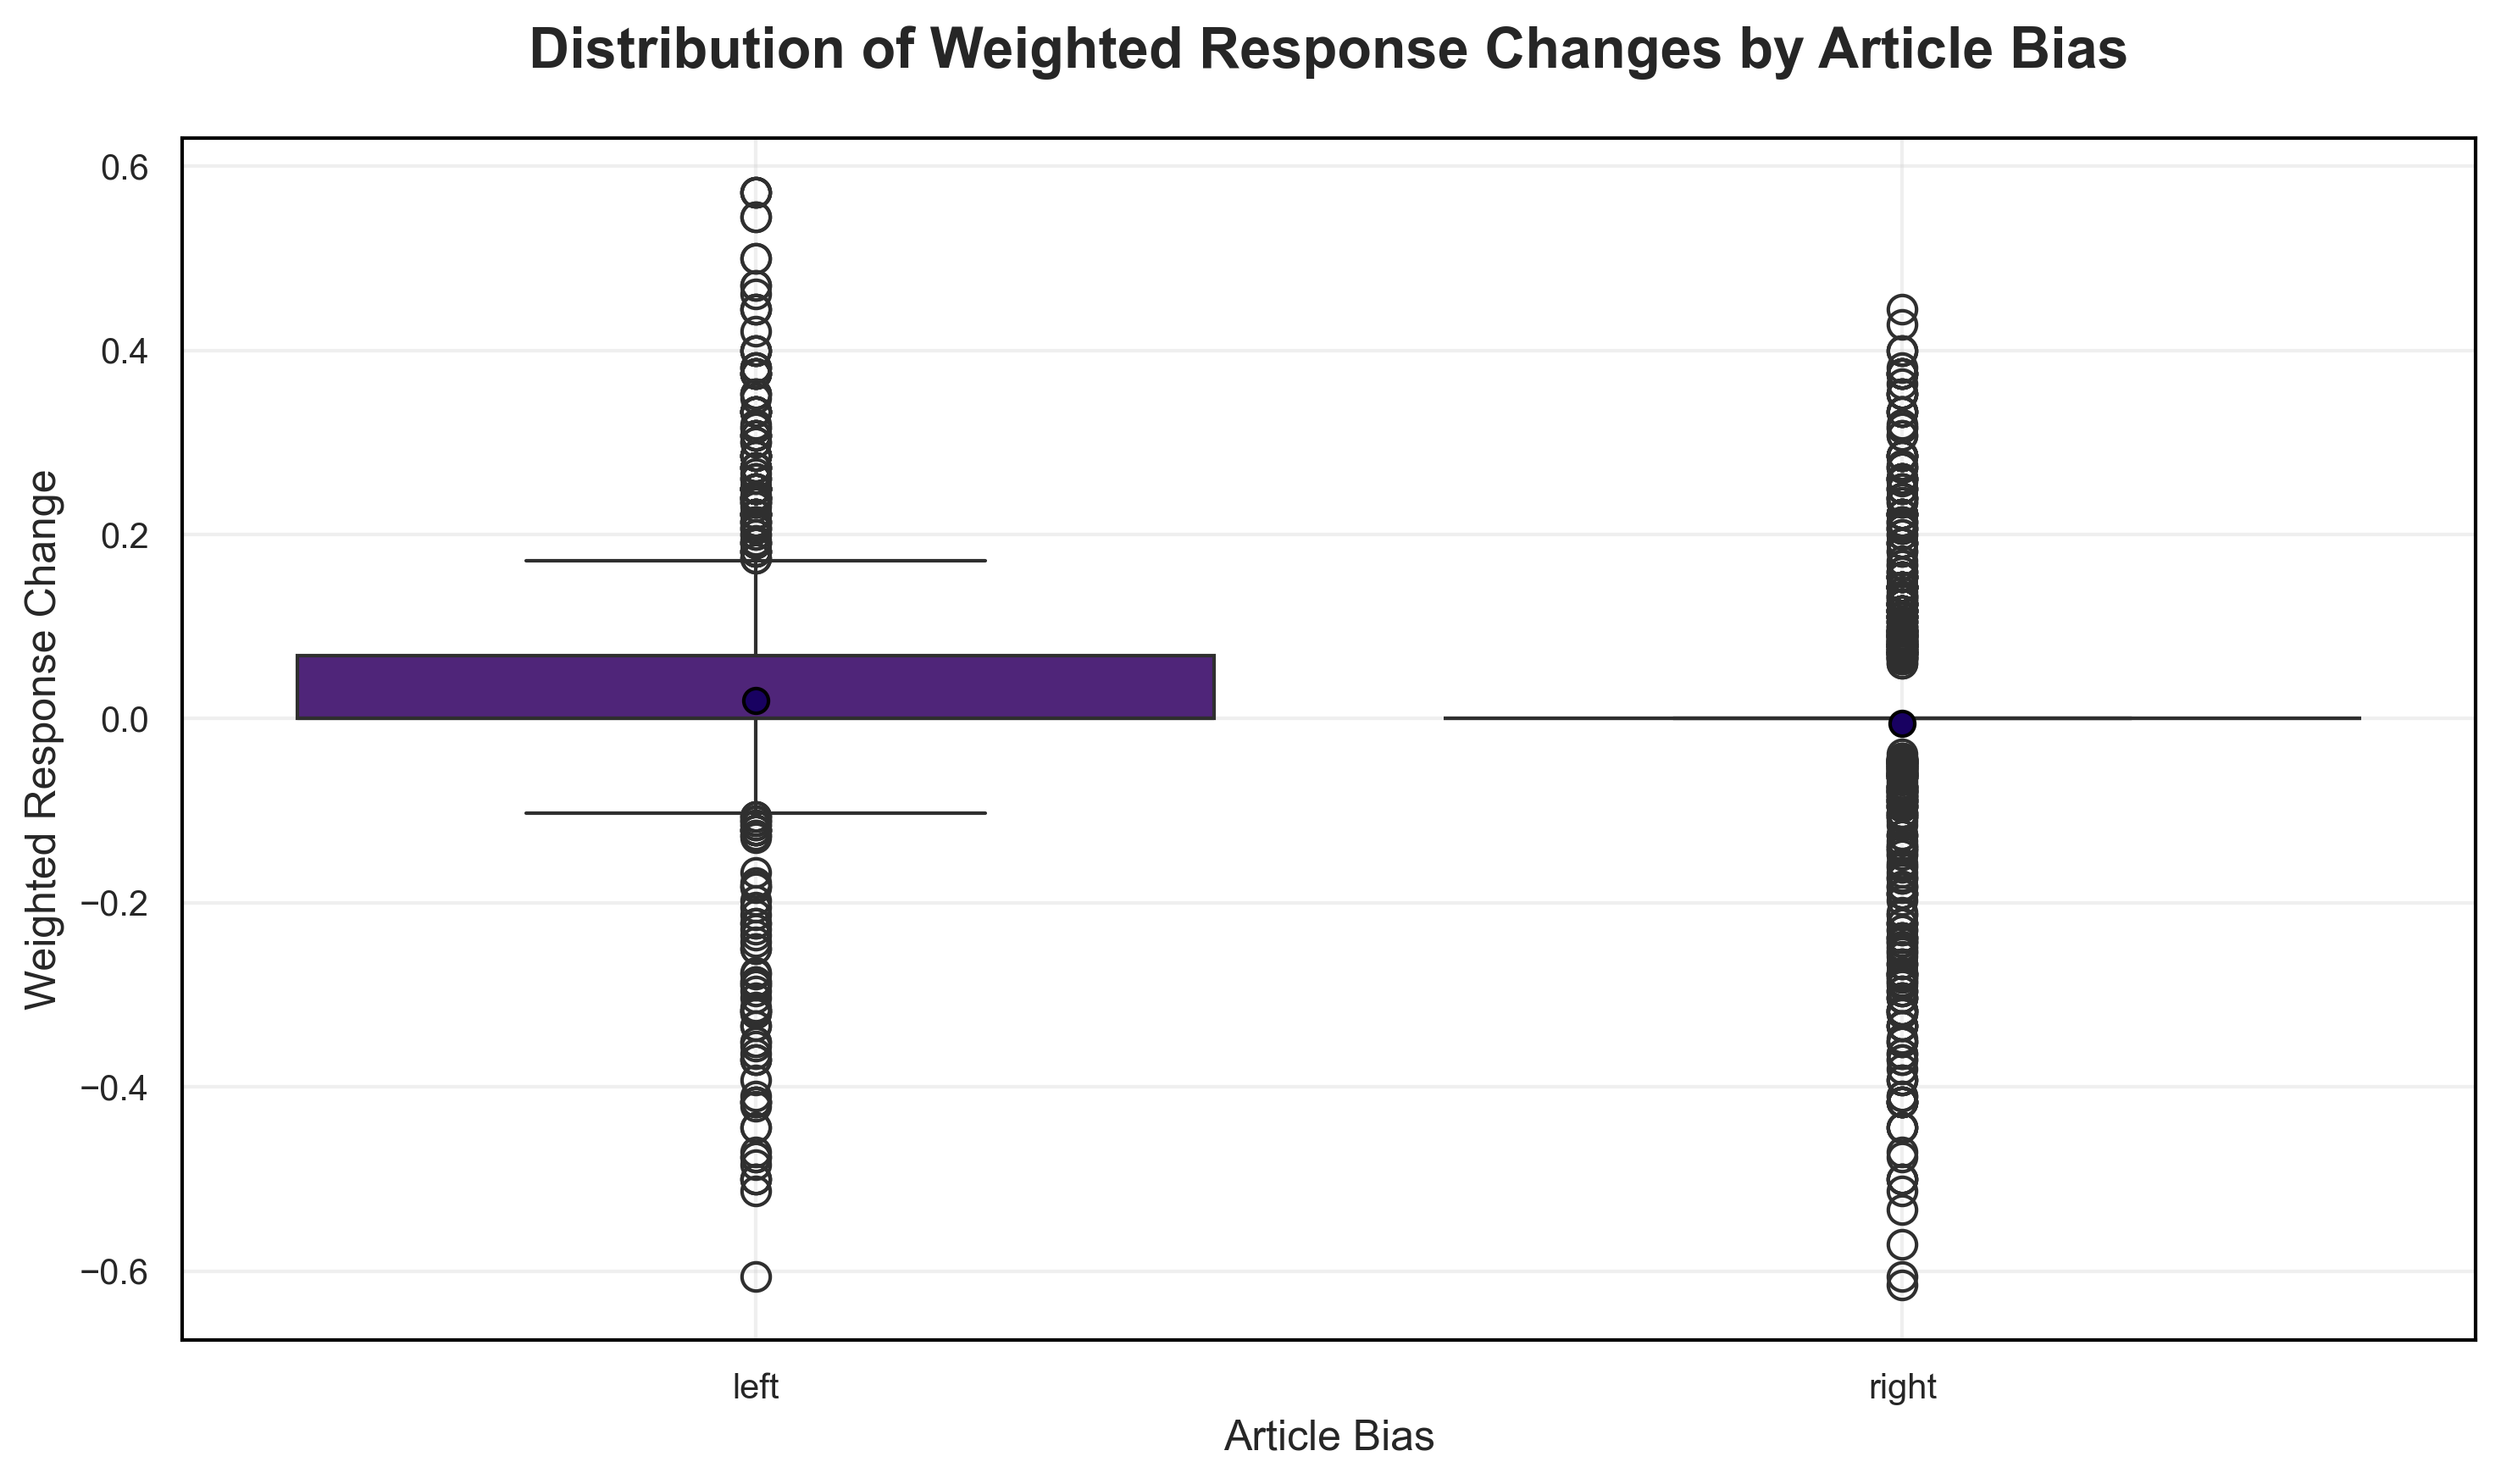

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_bias_response_plot(data):
    """
    Create a box plot showing the distribution of weighted response changes by article bias
    using the PublicationStyle guidelines.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing 'bias' and 'weighted_response_change' columns
    """
    # Set the style
    PublicationStyle.set_style()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the box plot
    sns.boxplot(
        x='bias', 
        y='weighted_response_change',
        hue='bias',
        data=data,
        palette=PublicationStyle.PALETTE,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": PublicationStyle.MAIN_COLORS['accent1'],
            "markeredgecolor": "black",
            "markersize": "7"
        },
        ax=ax
    )
    
    # Format the axis using PublicationStyle
    PublicationStyle.format_axis(
        ax=ax,
        title='Distribution of Weighted Response Changes by Article Bias',
        xlabel='Article Bias',
        ylabel='Weighted Response Change'
    )
    
    
    # Adjust layout to accommodate legend
    plt.tight_layout()
    
    return fig, ax

# Create the plot
fig, ax = create_bias_response_plot(merged_responses_with_reliability)

# Save the figure if needed
# PublicationStyle.save_figure(fig, 'bias_response_distribution.png')

plt.show()

Until this point, the changes do not seem obvious from the plots, because opposite change direction might cancel out


### 3.7 Differences in responses by article bias by political group

Here, we analyze how the type of bias (left vs right) impacted the response changes in the agents belonging to different political groups (Extreme Right vs Extreme Left). In other words, to the analysis measuring the changes of responses of each political group after exposure to articles, we also add the dimension of the bias of the article, to refine the results.

In [30]:
# Function to analyze differences in responses by article bias and political group, weighted by reliability
def analyze_differences_by_article_bias_and_group_with_reliability(merged_df):
    # Group by article bias and political stance, then calculate weighted statistics for response changes
    bias_group_analysis = merged_df.groupby(['bias', 'political_stance']).agg(
        # Use the precomputed weighted response change for calculating the average change
        weighted_avg_change=('weighted_response_change', 'mean'),
        count=('response_change', 'count'),
        std_change=('response_change', 'std'),
        min_change=('response_change', 'min'),
        max_change=('response_change', 'max'),
        median_change=('response_change', 'median')
    ).reset_index()

    # Sort the results to easily compare bias impact
    bias_group_analysis = bias_group_analysis.sort_values(by='weighted_avg_change', ascending=False)

    return bias_group_analysis


# Perform the analysis by article bias and political group with reliability
bias_group_analysis_results = analyze_differences_by_article_bias_and_group_with_reliability(merged_responses_with_reliability)

# Display the results in a readable format
print_analysis_results("Differences in Responses by Article Bias and Political Group (Weighted by Reliability)", bias_group_analysis_results.to_dict(orient='list'))



Differences in Responses by Article Bias and Political Group (Weighted by Reliability):
  - Bias: ['left', 'left', 'right', 'right']
  - Political stance: ['Extreme Right', 'Extreme Left', 'Extreme Left', 'Extreme Right']
  - Weighted avg change: [0.02246495182538419, 0.016506353373569344, 0.011326993102479213, -0.016266740259608496]
  - Count: [544, 392, 392, 544]
  - Std change: [1.9782939494657767, 1.3142412344937897, 1.3968131430229813, 2.2583605307522294]
  - Min change: [-6, -6, -6, -6]
  - Max change: [4, 4, 4, 4]
  - Median change: [0.0, 0.0, 0.0, 0.0]


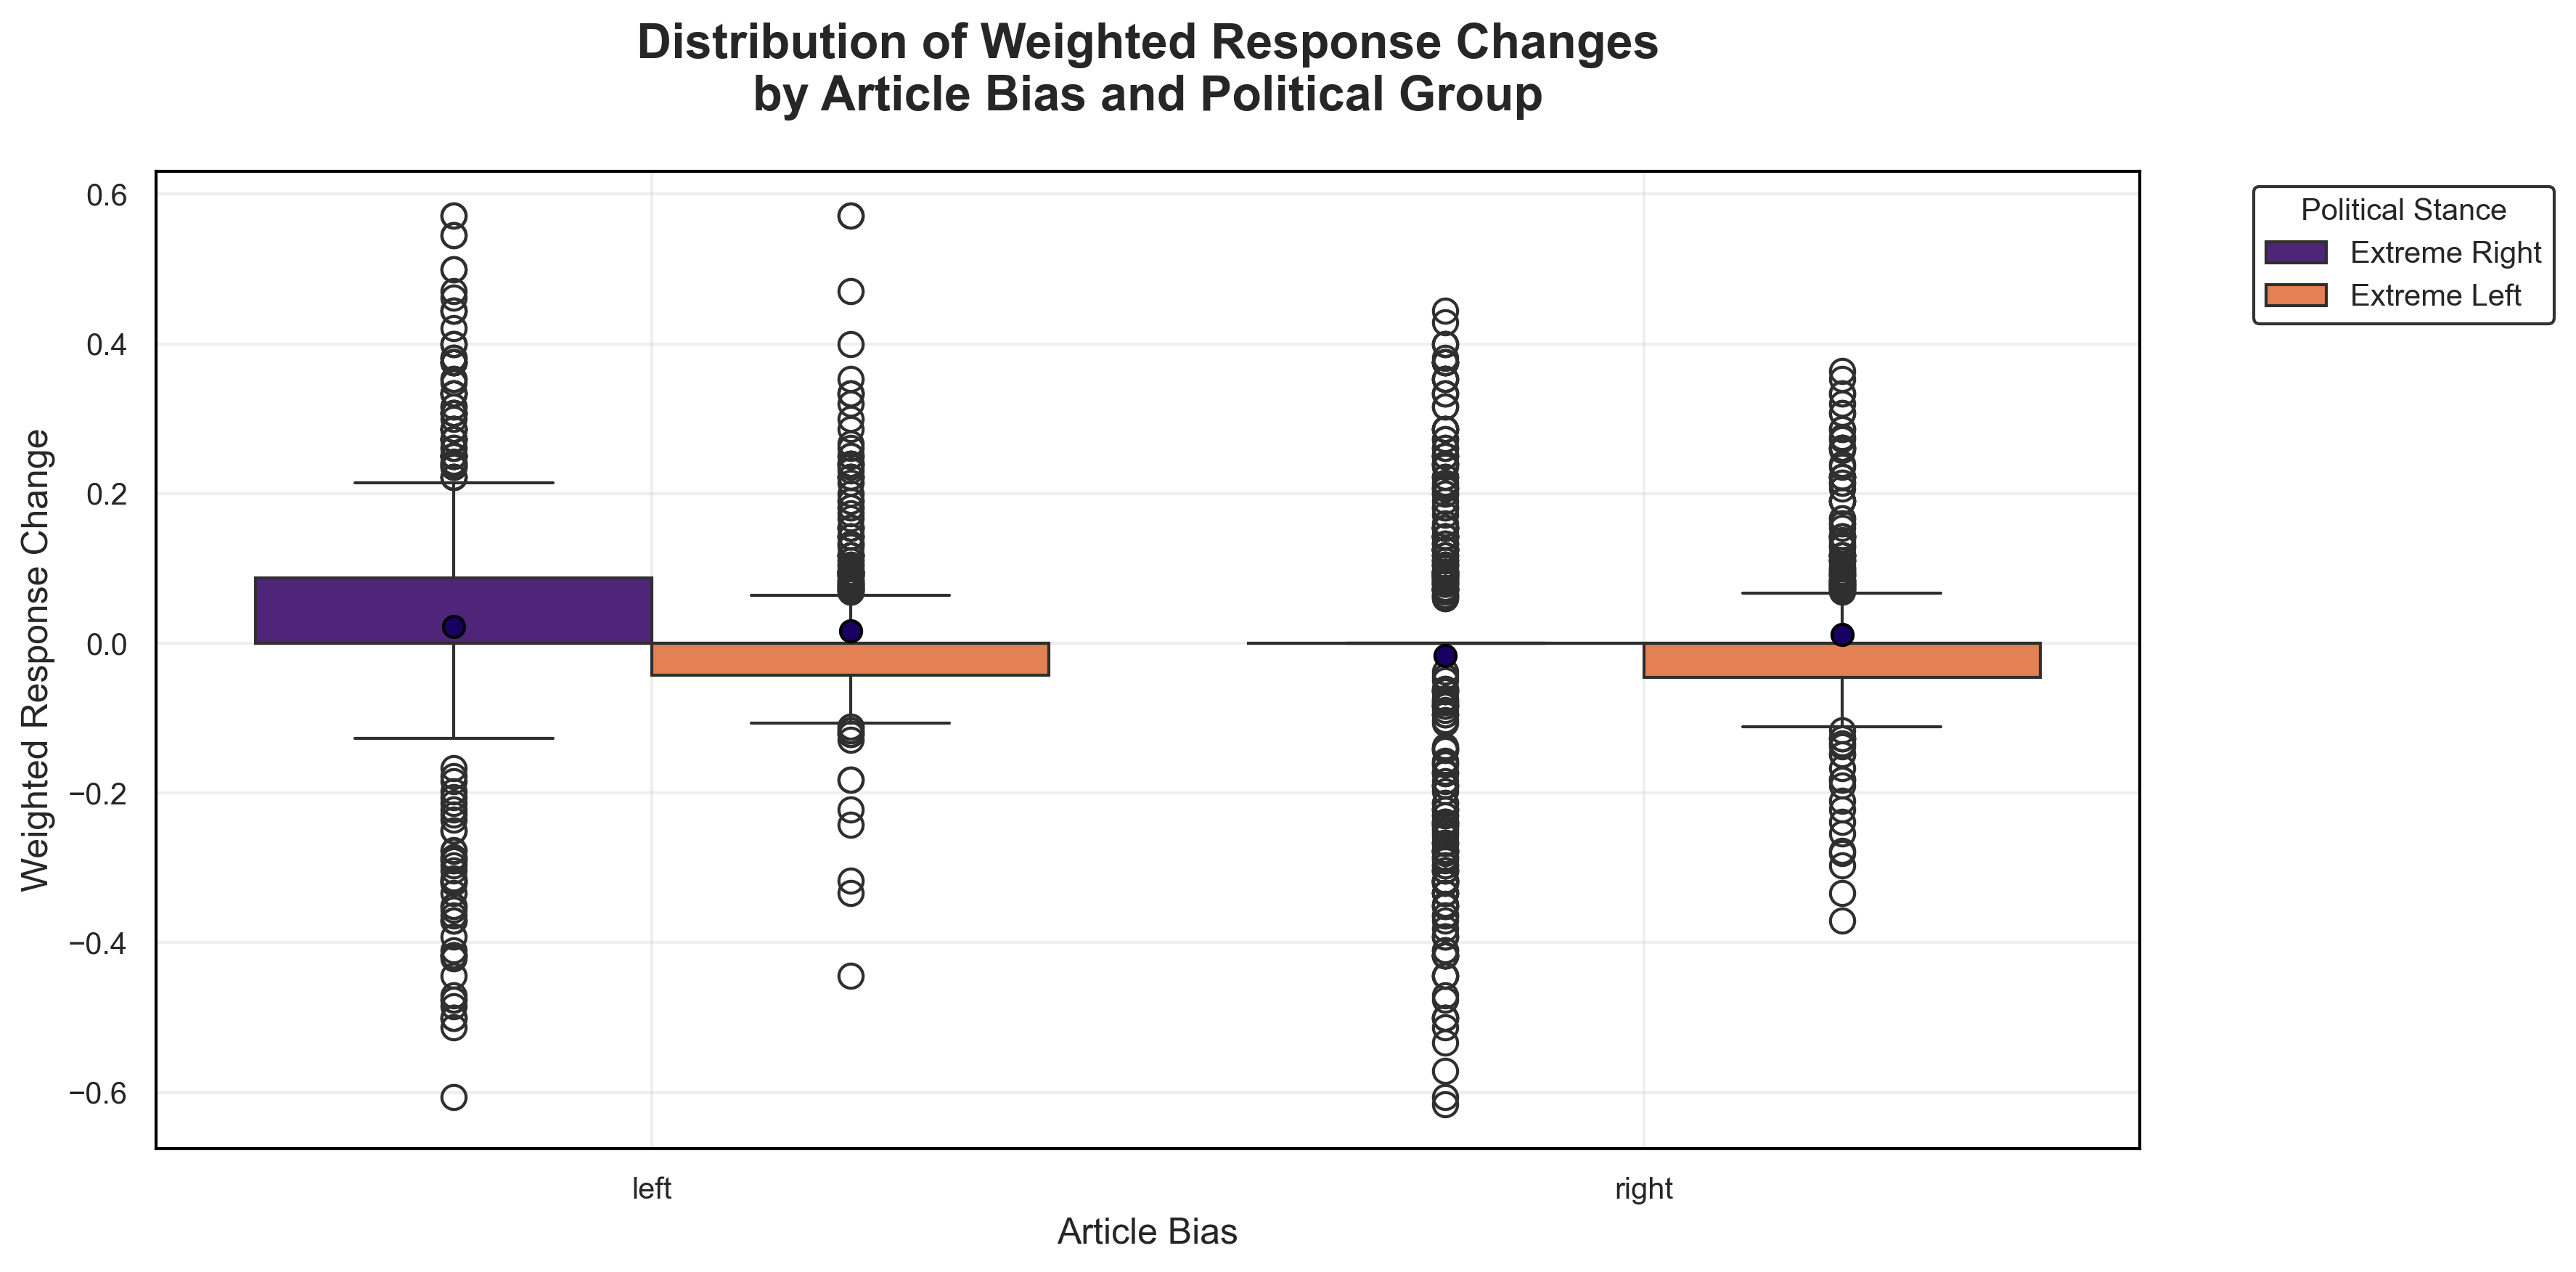

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_bias_political_response_plot(data):
    """
    Create a box plot showing the distribution of weighted response changes by 
    article bias and political stance using the PublicationStyle guidelines.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing 'bias', 'political_stance', and 'weighted_response_change' columns
    """
    # Set the style
    PublicationStyle.set_style()
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create the box plot
    sns.boxplot(
        x='bias', 
        y='weighted_response_change',
        hue='political_stance',
        data=data,
        palette=[PublicationStyle.MAIN_COLORS['primary'], 
                PublicationStyle.MAIN_COLORS['secondary']],  # Use two contrasting colors
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": PublicationStyle.MAIN_COLORS['accent1'],
            "markeredgecolor": "black",
            "markersize": "7"
        },
        ax=ax
    )
    
    # Format the axis using PublicationStyle
    PublicationStyle.format_axis(
        ax=ax,
        title='Distribution of Weighted Response Changes\nby Article Bias and Political Group',
        xlabel='Article Bias',
        ylabel='Weighted Response Change'
    )
    
    # Customize legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles, 
        labels,
        title='Political Stance',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        frameon=True,
        edgecolor='black'
    )
    
    # Add grid with lower opacity
    ax.grid(True, alpha=0.3)
    
    # Adjust layout to accommodate legend
    plt.tight_layout()
    
    return fig, ax

# Create the plot
fig, ax = create_bias_political_response_plot(merged_responses_with_reliability)

# Save the figure if needed
# PublicationStyle.save_figure(fig, 'bias_political_response_distribution.png')

plt.show()

This is to be read as follows:
Exposing Extreme Right agents to left news articles caused an average change of 0.014 steps in the scale.

## 3.8 Differences in responses by article bias, by political group, and by Question
Here, we also include the question in the previous analysis, and observe which questions were most affected by which bias across each political group.

In [32]:
# Function to analyze differences by article bias, political group, and question, weighted by reliability
def analyze_differences_by_bias_group_question_with_reliability(merged_df):
    # Group by article bias, political stance, and question_code, then calculate weighted statistics for response changes
    bias_group_question_analysis = merged_df.groupby(['bias', 'political_stance', 'question_code']).agg(
        # Use the precomputed weighted response change for calculating the average change
        weighted_avg_change=('weighted_response_change', 'mean'),
        count=('response_change', 'count'),
        std_change=('response_change', 'std'),
        min_change=('response_change', 'min'),
        max_change=('response_change', 'max'),
        median_change=('response_change', 'median')
    ).reset_index()

    # Sort the results by the weighted average change to easily compare impact
    bias_group_question_analysis = bias_group_question_analysis.sort_values(by='weighted_avg_change', ascending=False)

    return bias_group_question_analysis

# Perform the analysis by article bias, political group, and question with reliability
bias_group_question_analysis_results = analyze_differences_by_bias_group_question_with_reliability(merged_responses_with_reliability)

# Display the results in a readable format
print_analysis_results("Differences in Responses by Article Bias, Political Group, and Question (Weighted by Reliability)", bias_group_question_analysis_results.to_dict(orient='list'))



Differences in Responses by Article Bias, Political Group, and Question (Weighted by Reliability):
  - Bias: ['left', 'right', 'left', 'right', 'left', 'left', 'right', 'right', 'left', 'right', 'right', 'left', 'right', 'right', 'left', 'left', 'right', 'right', 'left', 'left', 'right', 'left', 'left', 'left', 'right', 'right', 'right', 'left', 'left', 'right', 'left', 'right']
  - Political stance: ['Extreme Right', 'Extreme Right', 'Extreme Left', 'Extreme Left', 'Extreme Right', 'Extreme Left', 'Extreme Left', 'Extreme Right', 'Extreme Right', 'Extreme Right', 'Extreme Left', 'Extreme Left', 'Extreme Right', 'Extreme Right', 'Extreme Right', 'Extreme Right', 'Extreme Right', 'Extreme Left', 'Extreme Left', 'Extreme Left', 'Extreme Left', 'Extreme Left', 'Extreme Left', 'Extreme Right', 'Extreme Left', 'Extreme Left', 'Extreme Left', 'Extreme Left', 'Extreme Right', 'Extreme Right', 'Extreme Right', 'Extreme Right']
  - Question code: ['F2A7', 'F2A9', 'F2A6', 'F2A9', 'F2A9', 'F2A7'

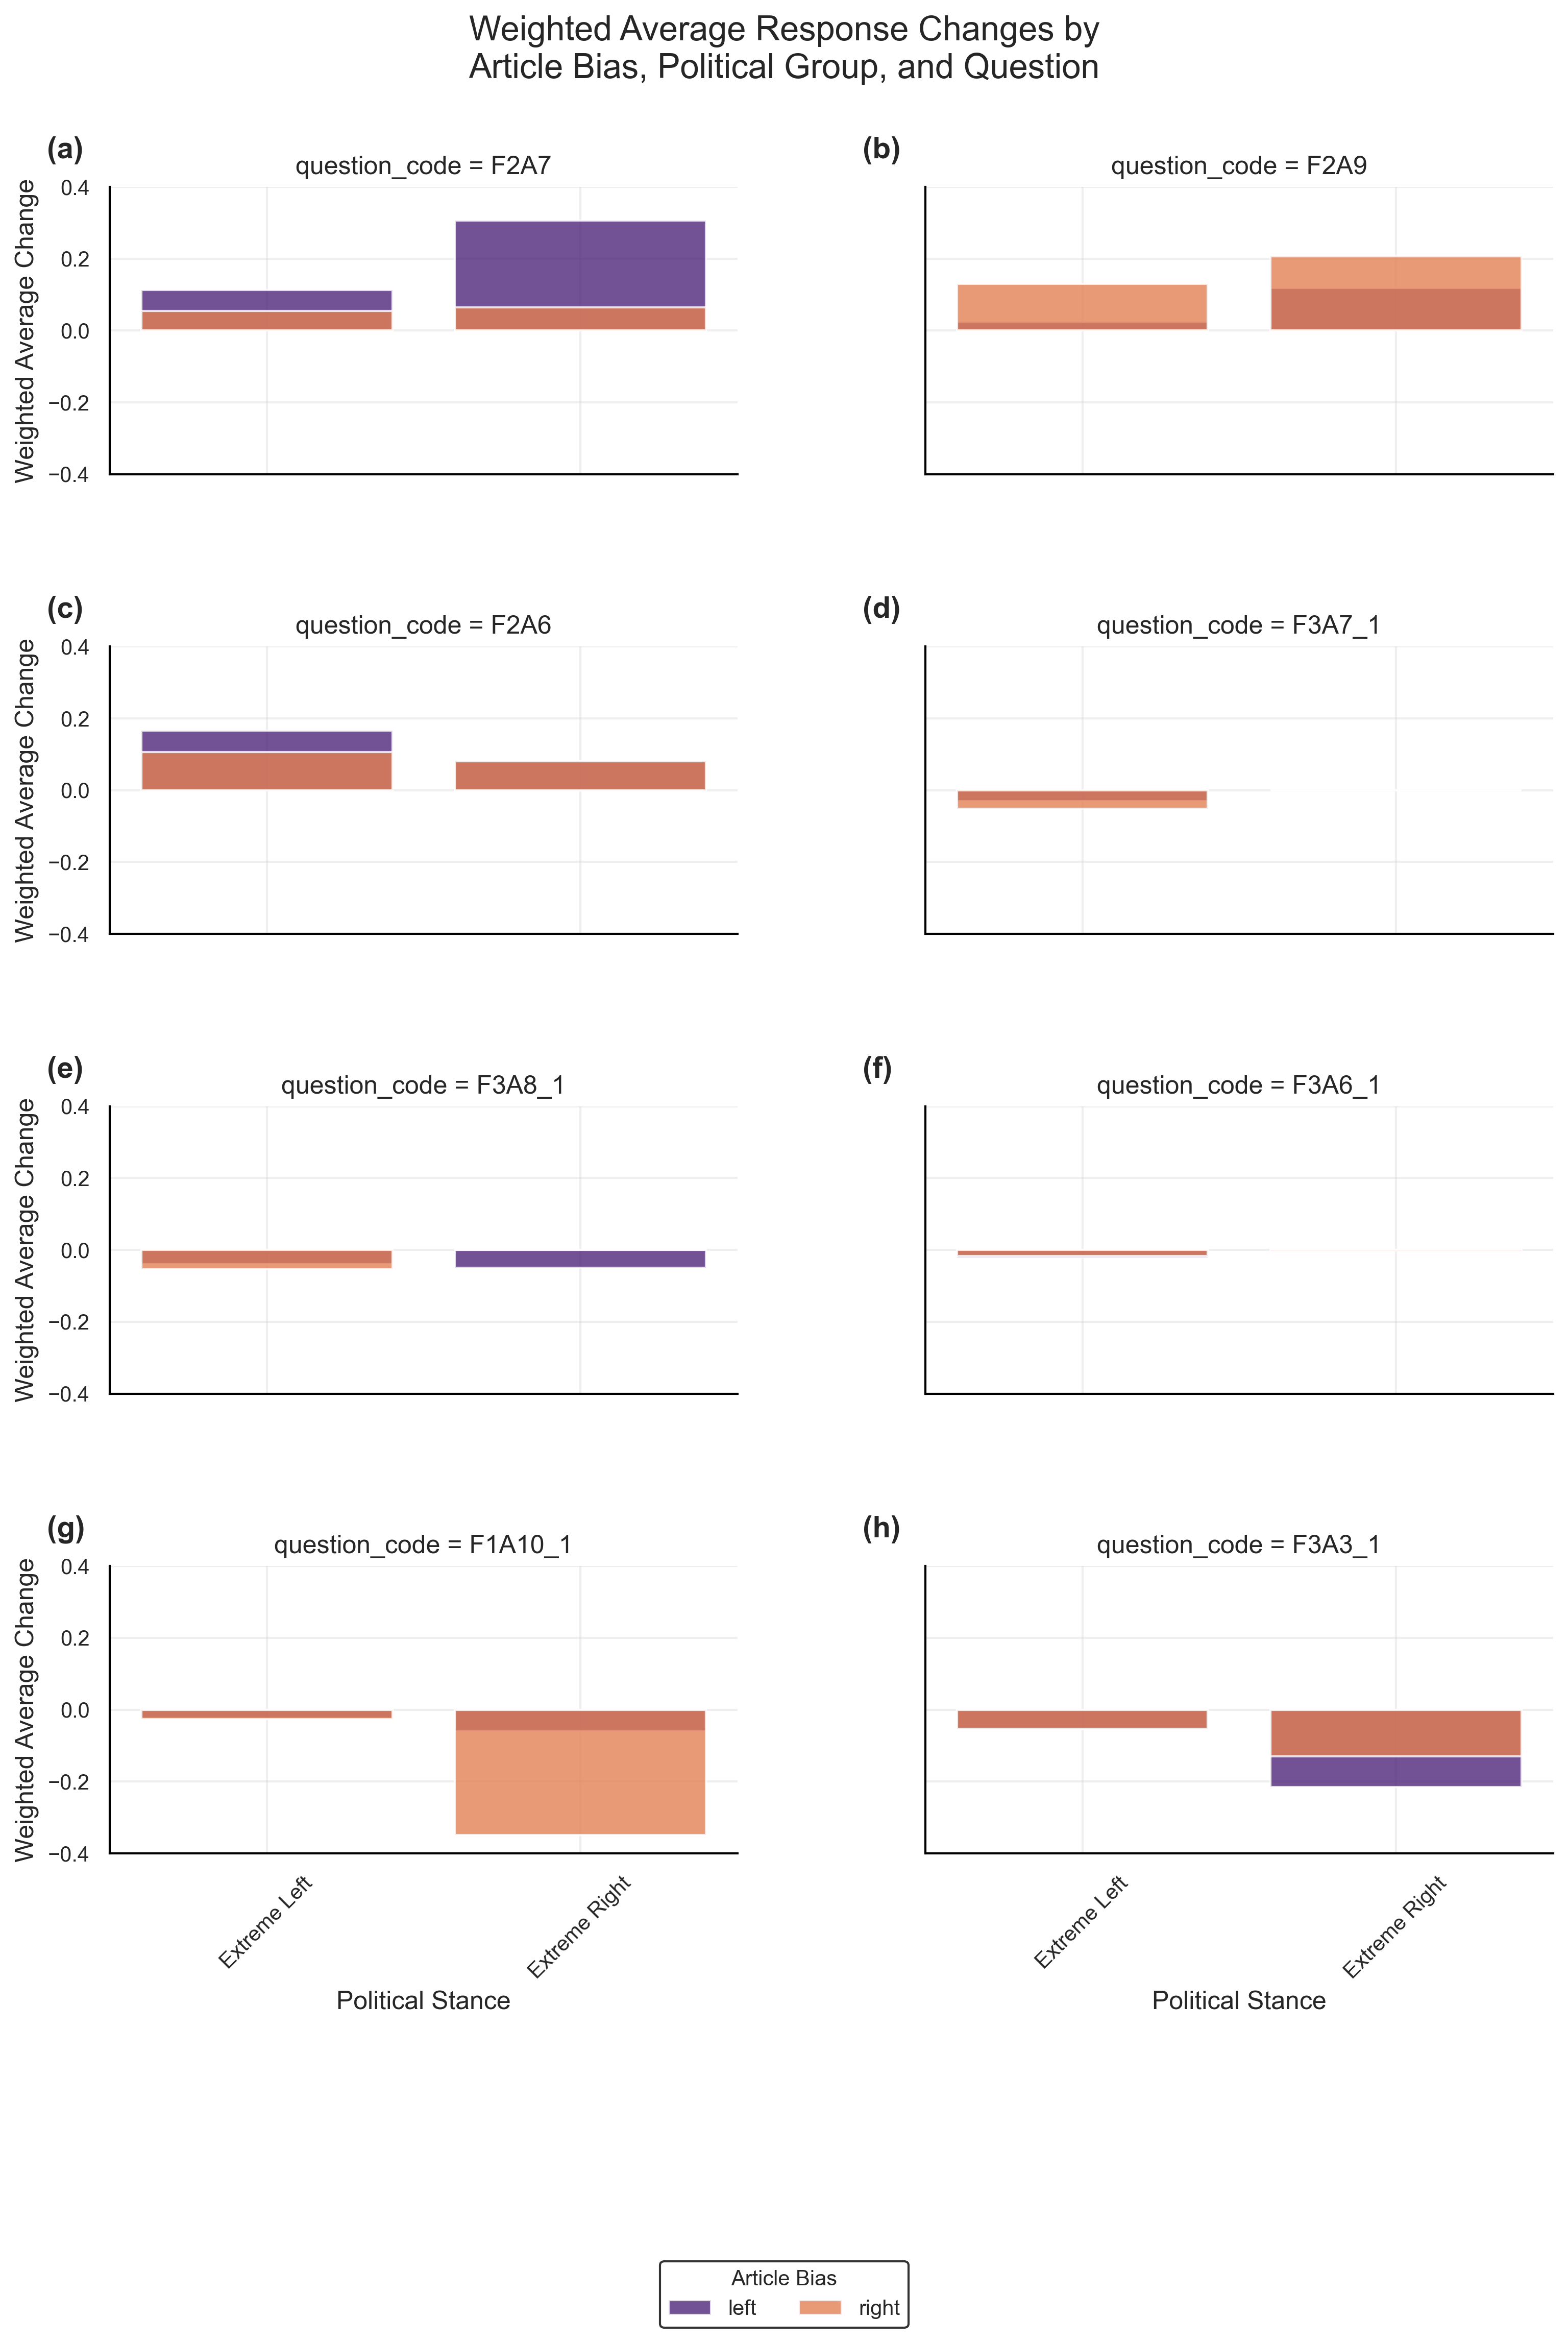

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_faceted_response_plot(data, political_stance_order=['Extreme Left', 'Extreme Right']):
    """
    Create a faceted bar plot showing weighted average response changes across questions,
    political stances, and article bias using the PublicationStyle guidelines.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the analysis results
    political_stance_order : list
        Order of political stances for the x-axis
    """
    # Set the style
    PublicationStyle.set_style()
    
    # Create FacetGrid
    g = sns.FacetGrid(
        data,
        col='question_code',
        hue='bias',
        margin_titles=True,
        height=4,
        aspect=1.3,
        col_wrap=2,
        palette=[PublicationStyle.MAIN_COLORS['primary'], 
                PublicationStyle.MAIN_COLORS['secondary']]
    )
    
    def custom_barplot(*args, **kwargs):
        if 'errwidth' in kwargs:
            linewidth = kwargs.pop('errwidth')
            kwargs['err_kws'] = {'linewidth': linewidth}
        return sns.barplot(*args, **kwargs)
    
    g.map_dataframe(
        custom_barplot,
        x='political_stance',
        y='weighted_avg_change',
        order=political_stance_order,
        alpha=0.8,
        err_kws={'linewidth': 1.5},  # Updated parameter
        capsize=0.05
    )
    
    # Customize each subplot
    for ax in g.axes:
        ax.grid(True, alpha=0.3)
        
        for spine in ax.spines.values():
            spine.set_linewidth(1)
            spine.set_color('black')
            
        ax.tick_params(axis='x', rotation=45)
        
        ax.tick_params(axis='y', labelsize=PublicationStyle.FONT_SIZES['tick_label'])
        
        ax.set_ylim(-0.4, 0.4)  
    
    PublicationStyle.add_figure_labels(g.fig)
    
    g.fig.suptitle(
        'Weighted Average Response Changes by\nArticle Bias, Political Group, and Question',
        fontsize=PublicationStyle.FONT_SIZES['title'],
        y=0.95
    )
    
    # Set axis labels
    g.set_axis_labels(
        'Political Stance',
        'Weighted Average Change',
        size=PublicationStyle.FONT_SIZES['axis_label']
    )
    
    # Get handles and labels from the first subplot
    handles, labels = g.axes[0].get_legend_handles_labels()
    
    # Remove any existing legends from subplots
    for ax in g.axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()
    
    # Add a new legend at the bottom center
    g.fig.legend(
        handles, 
        labels,
        title='Article Bias',
        ncol=2,
        loc='center',
        bbox_to_anchor=(0.5, 0.02),
        frameon=True,
        edgecolor='black',
        fontsize=PublicationStyle.FONT_SIZES['legend']
    )
    
    # Adjust layout
    plt.subplots_adjust(
        top=0.88,
        bottom=0.2,
        hspace=0.6,
        wspace=0.3
    )
    
    return g

# Create the plot
g = create_faceted_response_plot(bias_group_question_analysis_results)

# Save the figure if needed
# PublicationStyle.save_figure(g.fig, 'faceted_response_analysis.png')

plt.show()

# 4. Radicalization Analysis
All the steps performed below have been scaled by the reliability score of the agents.

## 4.1 Stable Responses Analysis
Here, we look for the presence of extreme responses prior to article exposure. These responses do not effectively contribute to the radicalisation analysis, since they are already found at the extremes of the scale and cannot be further pushed to the extremes. In such cases the scale caps the responses.

In [34]:
# Function to check stable responses at extremes, weighted by reliability
def check_stable_responses_at_extreme_with_reliability(merged_df, stable_threshold=0.5):
    # Filter for responses where weighted_response_change is close to zero (stable responses)
    stable_responses_df = merged_df[merged_df['weighted_response_change'].abs() <= stable_threshold].copy()

    # For F2 questions, the scale is 1-5, for others it's 1-7
    def is_at_extreme(row):
        if row['question_code'].startswith('F2'):
            return row['numeric_response_before'] in [1, 5]  # Extreme values for F2 questions
        else:
            return row['numeric_response_before'] in [1, 7]  # Extreme values for non-F2 questions

    # Apply the extreme check function to each row
    stable_responses_df['at_extreme'] = stable_responses_df.apply(is_at_extreme, axis=1)
    
    # Calculate the weighted count of stable responses at extremes
    stable_at_extreme_count = (stable_responses_df['at_extreme'] * stable_responses_df['reliability_score']).sum()

    # Calculate the weighted percentage of stable responses (little to no change) that were at the extremes
    total_stable_responses = stable_responses_df['reliability_score'].sum()
    percentage_at_extreme = (stable_at_extreme_count / total_stable_responses) * 100 if total_stable_responses > 0 else 0

    return {
        'total_stable_responses': total_stable_responses,
        'stable_at_extreme_count': stable_at_extreme_count,
        'percentage_at_extreme': percentage_at_extreme
    }

# Run the updated analysis to avoid the warning and incorporate reliability
extreme_stability_results_with_reliability = check_stable_responses_at_extreme_with_reliability(merged_responses_with_reliability)
percentage = extreme_stability_results_with_reliability["percentage_at_extreme"]
print(f"Percentage of stable responses at the extremes (Weighted by Reliability): {percentage:.2f}%")


Percentage of stable responses at the extremes (Weighted by Reliability): 58.65%


58.65% of the responses are already extreme even before exposure to biased articles. Such responses are also stable, therefore they did not change much through biased articles. The remaining percentage can experience either radicalisation or be mitigation through the introduction of biased articles.

## 4.2 Identifying Political Leaning Based on Response Patterns

The `generate_political_mapping` function is designed to analyze responses from the dataset containing real human responses. It compares the average responses from individuals identified as "Extreme Left" and "Extreme Right" to determine the direction of political leaning for each question. Specifically, the function creates a mapping that indicates whether smaller or larger response values correspond to left-leaning or right-leaning political views. 

This process is done to identify which questions exhibit a clear divide between left-leaning and right-leaning perspectives.

In [35]:
# Function to generate the political mapping based on actual numeric responses, weighted by reliability, and normalized by scale
def generate_political_mapping_weighted_normalized(df):
    """
    Generates a political stance mapping for each question based on the weighted average responses 
    of users with extreme left and extreme right political stances, normalized by question scale.

    Parameters:
    - df (DataFrame): The DataFrame containing user responses, political stances, and reliability scores.

    Returns:
    - political_mapping (dict): A dictionary where keys are question codes, and values are
                                True if smaller values represent left-leaning views, False if larger
                                values represent left-leaning views.
    """
    # Separate data by political stance
    left_responses = df[df['political_stance'] == 'Extreme Left']
    right_responses = df[df['political_stance'] == 'Extreme Right']

    # Initialize a dictionary to store the mapping
    political_mapping = {}

    # Get unique question codes
    question_columns = df['question_code'].unique()

    for question_code in question_columns:
        # Filter the DataFrame to get responses for this specific question
        left_responses_q = left_responses[left_responses['question_code'] == question_code]
        right_responses_q = right_responses[right_responses['question_code'] == question_code]

        # Determine the scale of the question
        if question_code.startswith('F2'):
            scale_max = 5  # Scale 1-5 for F2 questions
        else:
            scale_max = 7  # Scale 1-7 for other questions

        # Calculate the weighted and normalized average response for left-wing and right-wing users
        left_weighted_mean = (left_responses_q['numeric_response_before'] * left_responses_q['reliability_score']).sum() / left_responses_q['reliability_score'].sum()
        right_weighted_mean = (right_responses_q['numeric_response_before'] * right_responses_q['reliability_score']).sum() / right_responses_q['reliability_score'].sum()

        # Normalize the means by their scale (dividing by scale_max to get a 0-1 range)
        left_normalized_mean = left_weighted_mean / scale_max
        right_normalized_mean = right_weighted_mean / scale_max

        # Determine whether smaller values represent left-leaning views
        if left_normalized_mean < right_normalized_mean:
            political_mapping[question_code] = True  # Smaller values = left-leaning
        else:
            political_mapping[question_code] = False  # Larger values = left-leaning

    return political_mapping

# Generate the political mapping based on weighted and normalized user responses
question_political_mapping_weighted_normalized = generate_political_mapping_weighted_normalized(merged_responses_with_reliability)
print(question_political_mapping_weighted_normalized)


{'F1A10_1': False, 'F2A6': False, 'F2A7': False, 'F2A9': False, 'F3A3_1': False, 'F3A6_1': False, 'F3A7_1': False, 'F3A8_1': False}


In [36]:
for question_code in question_political_mapping_weighted_normalized:
    print(f"Question: {question_code}")
    left_responses_q = merged_responses_with_reliability[
        (merged_responses_with_reliability['political_stance'] == 'Extreme Left') & 
        (merged_responses_with_reliability['question_code'] == question_code)
    ]
    right_responses_q = merged_responses_with_reliability[
        (merged_responses_with_reliability['political_stance'] == 'Extreme Right') & 
        (merged_responses_with_reliability['question_code'] == question_code)
    ]
    left_weighted_mean = (left_responses_q['numeric_response_before'] * left_responses_q['reliability_score']).sum() / left_responses_q['reliability_score'].sum()
    right_weighted_mean = (right_responses_q['numeric_response_before'] * right_responses_q['reliability_score']).sum() / right_responses_q['reliability_score'].sum()

    # Normalize the means
    scale_max = 5 if question_code.startswith('F2') else 7
    left_normalized_mean = left_weighted_mean / scale_max
    right_normalized_mean = right_weighted_mean / scale_max

    print(f"  Left Normalized Weighted Mean: {left_normalized_mean}")
    print(f"  Right Normalized Weighted Mean: {right_normalized_mean}")

print("Reliability score distribution for Extreme Left:")
print(merged_responses_with_reliability[merged_responses_with_reliability['political_stance'] == 'Extreme Left']['reliability_score'].describe())

print("\nReliability score distribution for Extreme Right:")
print(merged_responses_with_reliability[merged_responses_with_reliability['political_stance'] == 'Extreme Right']['reliability_score'].describe())


Question: F1A10_1
  Left Normalized Weighted Mean: 0.9457012566099824
  Right Normalized Weighted Mean: 0.9331888669271216
Question: F2A6
  Left Normalized Weighted Mean: 0.8680710995105884
  Right Normalized Weighted Mean: 0.840783136897671
Question: F2A7
  Left Normalized Weighted Mean: 0.7900646148301347
  Right Normalized Weighted Mean: 0.34163447613476416
Question: F2A9
  Left Normalized Weighted Mean: 0.9282342053535165
  Right Normalized Weighted Mean: 0.5767652661755627
Question: F3A3_1
  Left Normalized Weighted Mean: 0.841412369291456
  Right Normalized Weighted Mean: 0.62709817890142
Question: F3A6_1
  Left Normalized Weighted Mean: 0.9866447478715674
  Right Normalized Weighted Mean: 0.14285714285714285
Question: F3A7_1
  Left Normalized Weighted Mean: 0.9192698569333464
  Right Normalized Weighted Mean: 0.14285714285714285
Question: F3A8_1
  Left Normalized Weighted Mean: 0.932593673131077
  Right Normalized Weighted Mean: 0.14285714285714285
Reliability score distribution

If the normalized mean for "Extreme Left" is high (close to 1), it suggests:

Left-wing individuals favor responses closer to the maximum of the scale (e.g., 5 on a 1-5 scale or 7 on a 1-7 scale).
If the normalized mean for "Extreme Right" is low (closer to 0), it suggests:

Right-wing individuals favor responses closer to the minimum of the scale (1).

## 4.3 Reinforcement of Right-Wing and Left-Wing Opinions
This analysis examines whether agents' opinions were reinforced depending on whether they were exposed to articles that aligned with their pre-existing political views.

### 4.3.1 Right Wing Reinforcement

In [37]:
# Function to analyze right-wing reinforcement and stable extremes, weighted by reliability
def analyze_reinforcement_and_stable_extremes_right_wing_with_reliability(merged_df, question_political_mapping):
    # Filter for Extreme Right users and right-wing biased articles
    right_wing_df = merged_df[(merged_df['political_stance'] == 'Extreme Right') & (merged_df['bias'] == 'right')].copy()

    # Function to check if the response was reinforced based on political mapping
    def is_reinforced(row):
        is_left_leaning = question_political_mapping.get(row['question_code'], False)
        if is_left_leaning:
            # For left-leaning questions, reinforcement means moving to lower values
            return row['numeric_response_after'] > row['numeric_response_before']
        else:
            # For right-leaning questions, reinforcement means moving to higher values
            return row['numeric_response_after'] > row['numeric_response_before']

    # Apply the reinforcement check
    right_wing_df['reinforced'] = right_wing_df.apply(is_reinforced, axis=1)

    # Filter out the reinforced responses to ensure they are not counted as "stable at extremes"
    non_reinforced_df = right_wing_df[~right_wing_df['reinforced']].copy()

    # Check if the non-reinforced response was already at an extreme
    def was_stable_at_extreme(row):
        is_left_leaning = question_political_mapping.get(row['question_code'], False)
        # Determine the scale of the question
        if row['question_code'].startswith('F2'):
            # 1-5 scale
            if is_left_leaning:
                return row['numeric_response_before'] in [1, 2]  # Extreme for left-leaning
            else:
                return row['numeric_response_before'] in [4, 5]  # Extreme for right-leaning
        else:
            # 1-7 scale
            if is_left_leaning:
                return row['numeric_response_before'] in [1, 2]  # Extreme for left-leaning
            else:
                return row['numeric_response_before'] in [6, 7]  # Extreme for right-leaning

    # Apply the stable at extreme check only on non-reinforced responses
    non_reinforced_df.loc[:, 'stable_at_extreme'] = non_reinforced_df.apply(was_stable_at_extreme, axis=1)

    # Calculate total responses weighted by reliability
    total_weighted_responses = right_wing_df['reliability_score'].sum()
    
    # Calculate reinforced responses weighted by reliability
    reinforced_weighted = (right_wing_df['reinforced'] * right_wing_df['reliability_score']).sum()

    # Calculate stable at extreme responses weighted by reliability
    stable_at_extreme_weighted = (non_reinforced_df['stable_at_extreme'] * non_reinforced_df['reliability_score']).sum()

    # Ensure stable and reinforced are mutually exclusive
    assert stable_at_extreme_weighted + reinforced_weighted <= total_weighted_responses, \
        "Stable and reinforced responses should not exceed total responses."

    # Calculate percentages safely
    percentage_reinforced = (reinforced_weighted / total_weighted_responses) * 100 if total_weighted_responses > 0 else 0
    percentage_stable_at_extreme = (stable_at_extreme_weighted / total_weighted_responses) * 100 if total_weighted_responses > 0 else 0

    # Calculate mitigated responses
    mitigated_weighted = max(0, total_weighted_responses - (reinforced_weighted + stable_at_extreme_weighted))
    percentage_mitigated = (mitigated_weighted / total_weighted_responses) * 100 if total_weighted_responses > 0 else 0

    # Return the results
    return {
        'total_right_wing_responses': total_weighted_responses,
        'reinforced_responses': reinforced_weighted,
        'percentage_reinforced': round(percentage_reinforced, 2),
        'stable_at_extreme_count': stable_at_extreme_weighted,
        'percentage_stable_at_extreme': round(percentage_stable_at_extreme, 2),
        'mitigated_responses': mitigated_weighted,
        'percentage_mitigated': round(percentage_mitigated, 2)
    }


# Perform the analysis for right-wing users with reliability
# Perform the analysis for right-wing users with reliability
right_wing_extended_results_with_reliability = analyze_reinforcement_and_stable_extremes_right_wing_with_reliability(
    merged_responses_with_reliability, 
    question_political_mapping_weighted_normalized
)

# Calculate the weighted count of mitigated responses
mitigated_weighted = right_wing_extended_results_with_reliability['total_right_wing_responses'] - (
    right_wing_extended_results_with_reliability['reinforced_responses'] + 
    right_wing_extended_results_with_reliability['stable_at_extreme_count']
)

# Calculate the percentage of mitigated responses
percentage_mitigated = (mitigated_weighted / right_wing_extended_results_with_reliability['total_right_wing_responses']) * 100 if right_wing_extended_results_with_reliability['total_right_wing_responses'] > 0 else 0

# Print all results including the mitigated responses
print("Reinforcement of Right-Wing Opinions (Extreme Right Agents, Right-Biased Articles, Weighted by Reliability):")
print(f"Total right-wing responses (weighted): {right_wing_extended_results_with_reliability['total_right_wing_responses']}")
print(f"Reinforced responses (weighted): {right_wing_extended_results_with_reliability['reinforced_responses']}")
print(f"Percentage of reinforced responses (weighted): {right_wing_extended_results_with_reliability['percentage_reinforced']}%")
print(f"Stable non-reinforced responses at extremes (weighted): {right_wing_extended_results_with_reliability['stable_at_extreme_count']}")
print(f"Percentage of stable non-reinforced responses at extremes (weighted): {right_wing_extended_results_with_reliability['percentage_stable_at_extreme']}%")
print(f"Mitigated responses (weighted): {mitigated_weighted}")
print(f"Percentage of mitigated responses (weighted): {round(percentage_mitigated, 2)}%")



Reinforcement of Right-Wing Opinions (Extreme Right Agents, Right-Biased Articles, Weighted by Reliability):
Total right-wing responses (weighted): 223.42599338734254
Reinforced responses (weighted): 60.001361172761285
Percentage of reinforced responses (weighted): 26.86%
Stable non-reinforced responses at extremes (weighted): 56.000509471429574
Percentage of stable non-reinforced responses at extremes (weighted): 25.06%
Mitigated responses (weighted): 107.42412274315168
Percentage of mitigated responses (weighted): 48.08%


### 4.3.2 Left Wing Reinforcement

In [38]:
def analyze_reinforcement_and_stable_extremes_left_wing_with_reliability(merged_df, question_political_mapping):
    """
    Analyzes reinforcement and stable extremes for left-wing users, weighted by reliability.
    
    Parameters:
    - merged_df: DataFrame containing the response data
    - question_political_mapping: Dictionary mapping questions to their political leaning
    """
    # Filter for Extreme Left users and left-wing biased articles
    left_wing_df = merged_df[(merged_df['political_stance'] == 'Extreme Left') & 
                            (merged_df['bias'] == 'left')].copy()

    def is_reinforced(row):
        is_left_leaning = question_political_mapping.get(row['question_code'], False)
        if is_left_leaning:
            # For left-leaning questions, reinforcement means moving to lower values
            return row['numeric_response_after'] < row['numeric_response_before']
        else:
            # For right-leaning questions, reinforcement means moving to lower values
            return row['numeric_response_after'] < row['numeric_response_before']

    # Apply the reinforcement check
    left_wing_df['reinforced'] = left_wing_df.apply(is_reinforced, axis=1)

    # Filter out reinforced responses
    non_reinforced_df = left_wing_df[~left_wing_df['reinforced']].copy()

    def was_stable_at_extreme(row):
        is_left_leaning = question_political_mapping.get(row['question_code'], False)
        # Determine the scale of the question
        if row['question_code'].startswith('F2'):
            # 1-5 scale
            if is_left_leaning:
                return row['numeric_response_before'] in [1, 2]  # Extreme for left-leaning
            else:
                return row['numeric_response_before'] in [1, 2]  # Extreme for right-leaning
        else:
            # 1-7 scale
            if is_left_leaning:
                return row['numeric_response_before'] in [1, 2]  # Extreme for left-leaning
            else:
                return row['numeric_response_before'] in [1, 2]  # Extreme for right-leaning

    # Apply the stable at extreme check only on non-reinforced responses
    non_reinforced_df.loc[:, 'stable_at_extreme'] = non_reinforced_df.apply(was_stable_at_extreme, axis=1)

    # Calculate total responses weighted by reliability
    total_weighted_responses = left_wing_df['reliability_score'].sum()
    
    # Calculate reinforced responses weighted by reliability
    reinforced_weighted = (left_wing_df['reinforced'] * left_wing_df['reliability_score']).sum()

    # Calculate stable at extreme responses weighted by reliability
    stable_at_extreme_weighted = (non_reinforced_df['stable_at_extreme'] * 
                                non_reinforced_df['reliability_score']).sum()

    # Ensure stable and reinforced are mutually exclusive
    assert stable_at_extreme_weighted + reinforced_weighted <= total_weighted_responses, \
        "Stable and reinforced responses should not exceed total responses."

    # Calculate percentages safely
    percentage_reinforced = (reinforced_weighted / total_weighted_responses * 100 
                           if total_weighted_responses > 0 else 0)
    percentage_stable_at_extreme = (stable_at_extreme_weighted / total_weighted_responses * 100 
                                  if total_weighted_responses > 0 else 0)

    # Calculate mitigated responses
    mitigated_weighted = max(0, total_weighted_responses - 
                           (reinforced_weighted + stable_at_extreme_weighted))
    percentage_mitigated = (mitigated_weighted / total_weighted_responses * 100 
                          if total_weighted_responses > 0 else 0)

    # Return the results
    return {
        'total_left_wing_responses': total_weighted_responses,
        'reinforced_responses': reinforced_weighted,
        'percentage_reinforced': round(percentage_reinforced, 2),
        'stable_at_extreme_count': stable_at_extreme_weighted,
        'percentage_stable_at_extreme': round(percentage_stable_at_extreme, 2),
        'mitigated_responses': mitigated_weighted,
        'percentage_mitigated': round(percentage_mitigated, 2)
    }

# Run the analysis
left_wing_extended_results_with_reliability = analyze_reinforcement_and_stable_extremes_left_wing_with_reliability(
    merged_responses_with_reliability, 
    question_political_mapping_weighted_normalized
)

# Print results
print("\nReinforcement of Left-Wing Opinions (Extreme Left Agents, Left-Biased Articles, Weighted by Reliability):")
print(f"Total left-wing responses (weighted): {left_wing_extended_results_with_reliability['total_left_wing_responses']}")
print(f"Reinforced responses (weighted): {left_wing_extended_results_with_reliability['reinforced_responses']}")
print(f"Percentage of reinforced responses (weighted): {left_wing_extended_results_with_reliability['percentage_reinforced']}%")
print(f"Stable non-reinforced responses at extremes (weighted): {left_wing_extended_results_with_reliability['stable_at_extreme_count']}")
print(f"Percentage of stable non-reinforced responses at extremes (weighted): {left_wing_extended_results_with_reliability['percentage_stable_at_extreme']}%")
print(f"Mitigated responses (weighted): {left_wing_extended_results_with_reliability['mitigated_responses']}")
print(f"Percentage of mitigated responses (weighted): {left_wing_extended_results_with_reliability['percentage_mitigated']}%")


Reinforcement of Left-Wing Opinions (Extreme Left Agents, Left-Biased Articles, Weighted by Reliability):
Total left-wing responses (weighted): 141.3679390320283
Reinforced responses (weighted): 38.24454493650617
Percentage of reinforced responses (weighted): 27.05%
Stable non-reinforced responses at extremes (weighted): 3.223998223998224
Percentage of stable non-reinforced responses at extremes (weighted): 2.28%
Mitigated responses (weighted): 99.8993958715239
Percentage of mitigated responses (weighted): 70.67%


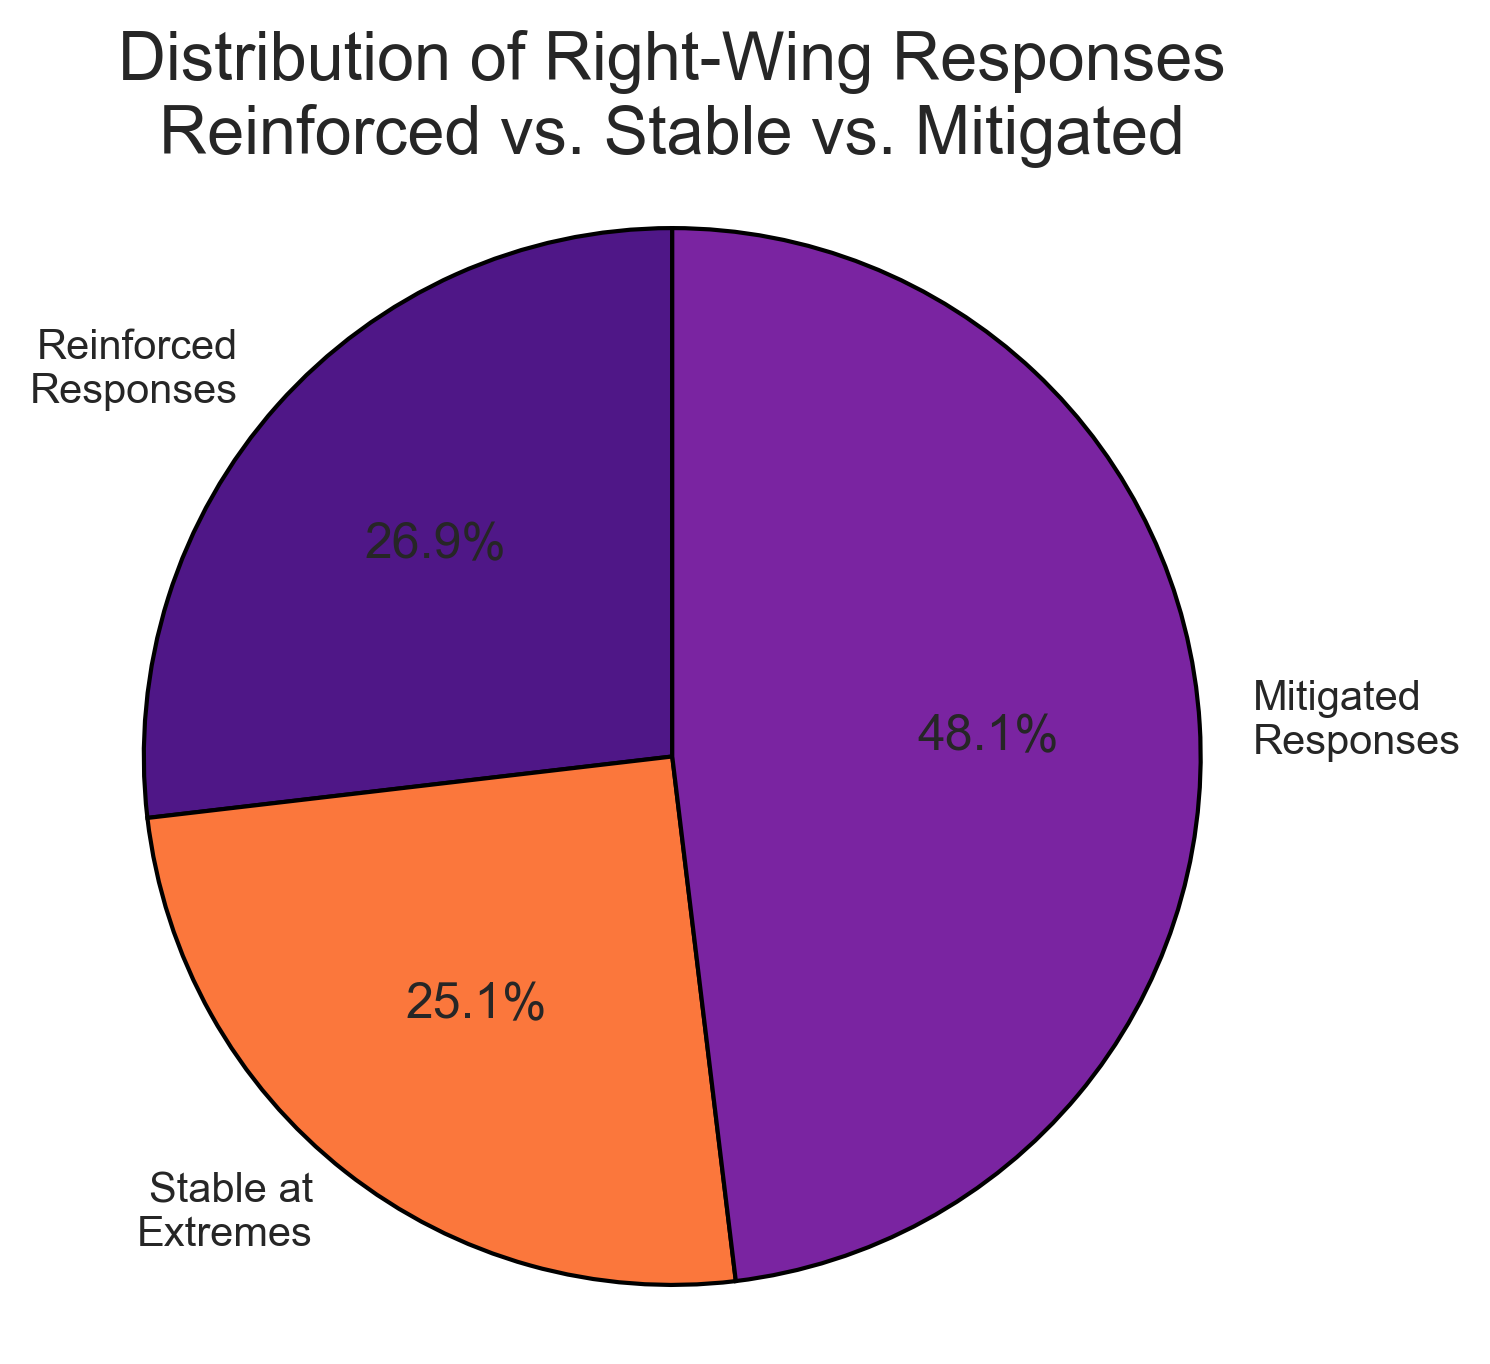

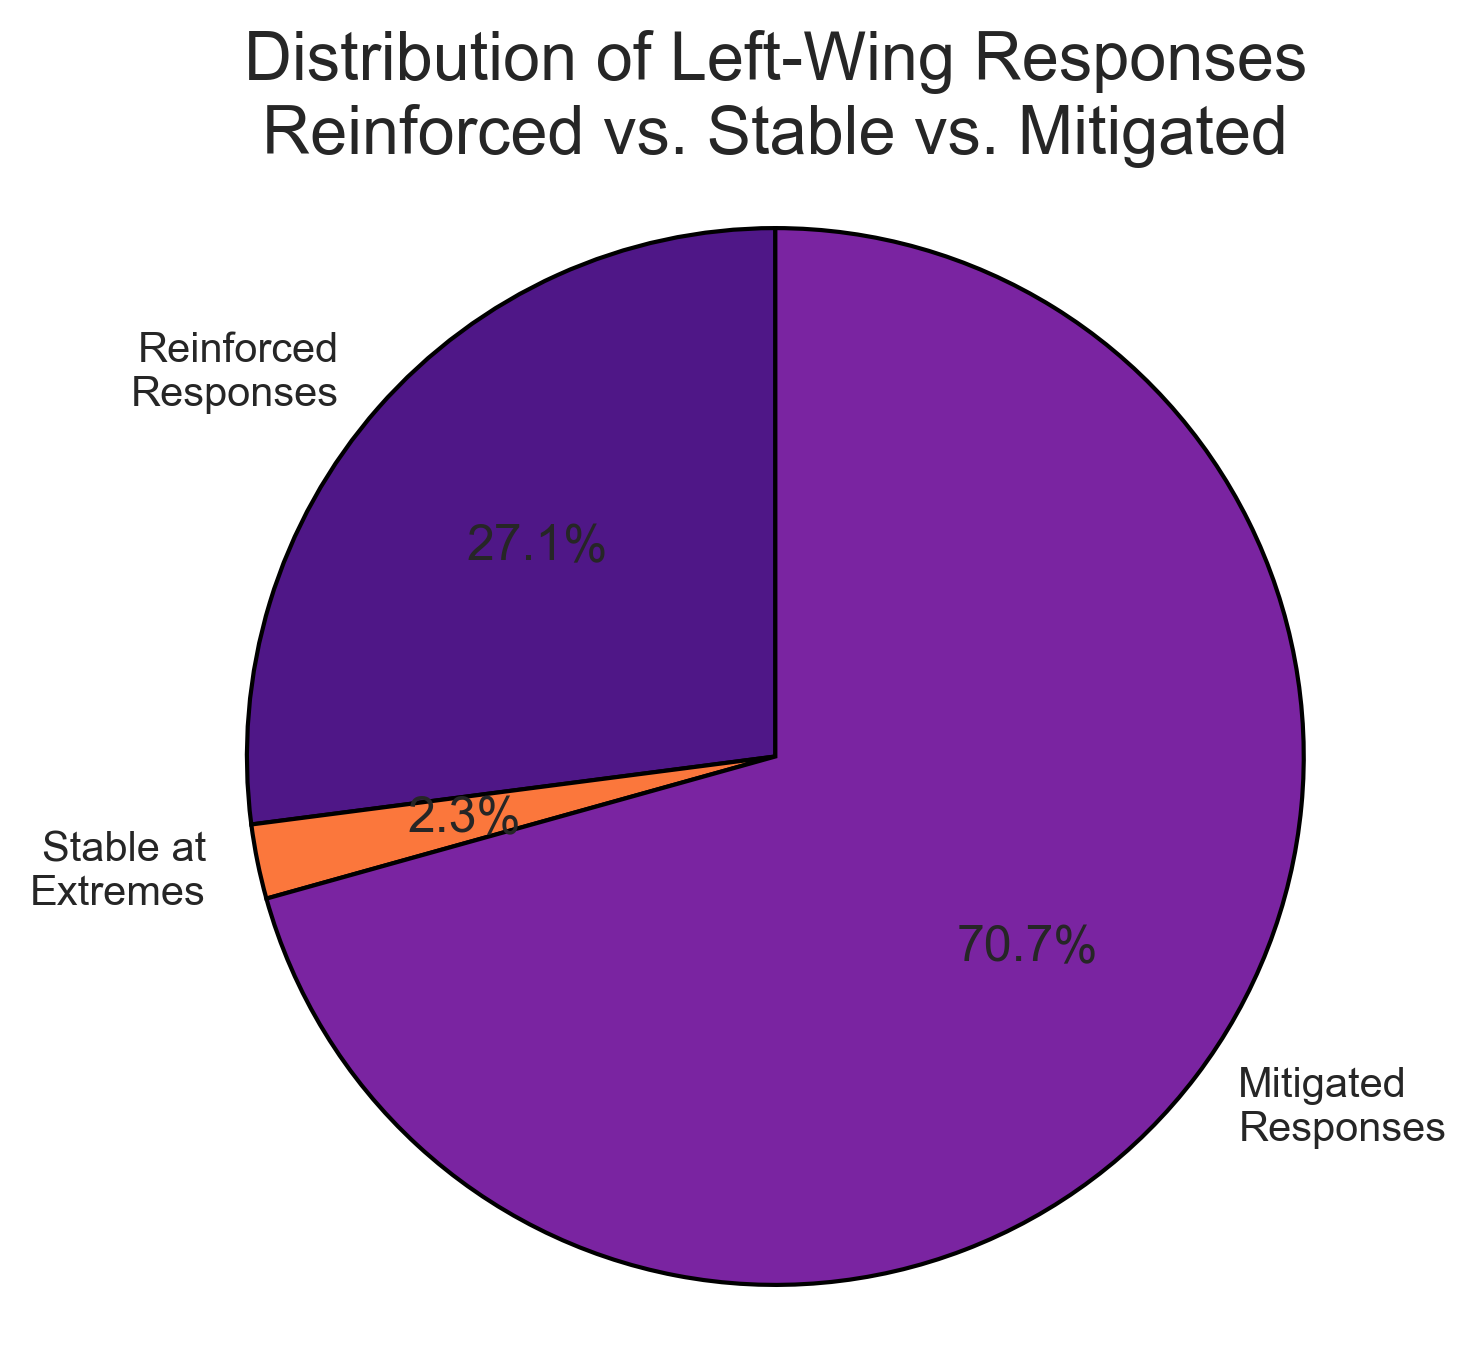

In [39]:
def visualize_reinforcement_and_stable_extremes(results, wing_label):
    """
    Creates a pie chart visualizing the distribution of responses into
    reinforced, stable at extremes, and mitigated responses.
    
    Parameters:
    - results (dict): The analysis results with counts and percentages
    - wing_label (str): The label for either "Right-Wing" or "Left-Wing"
    """
    # Set publication style
    PublicationStyle.set_style()
    
    # Define the labels and sizes based on the results dictionary
    labels = ['Reinforced\nResponses', 'Stable at\nExtremes', 'Mitigated\nResponses']
    sizes = [
        results['reinforced_responses'],
        results['stable_at_extreme_count'],
        results['mitigated_responses']
    ]
    
    # Create figure
    plt.figure(figsize=(5, 5))
    
    # Create pie chart with PublicationStyle colors
    plt.pie(sizes, 
           labels=labels, 
           colors=[PublicationStyle.MAIN_COLORS['primary'],
                  PublicationStyle.MAIN_COLORS['secondary'],
                  PublicationStyle.MAIN_COLORS['tertiary']], 
           autopct='%1.1f%%', 
           startangle=90, 
           wedgeprops={'edgecolor': 'black'})
    
    plt.axis('equal')
    plt.title(f'Distribution of {wing_label} Responses\nReinforced vs. Stable vs. Mitigated')
    
    return plt.gcf(), plt.gca()

# Create visualizations using the actual results
fig1, ax1 = visualize_reinforcement_and_stable_extremes(
    right_wing_extended_results_with_reliability, 
    "Right-Wing"
)
PublicationStyle.save_figure(fig1, 'right_wing_reinforcement.png')

fig2, ax2 = visualize_reinforcement_and_stable_extremes(
    left_wing_extended_results_with_reliability, 
    "Left-Wing"
)
PublicationStyle.save_figure(fig2, 'left_wing_reinforcement.png')

plt.show()

# 5. Significance Test

Check whether the articles cause a significant shift in opinion: if so, which type of bias is more impactful? And which groups are most affected?

### 5.1 Wilcoxon Test on Non-Extreme Responses
In the following test, only the responses that were not already at the extremes of the likert scales are taken into consideration.

In [40]:
# Define a function to filter data by political stance and bias for significance testing
def filter_responses_for_wilcoxon(merged_df, political_stance, bias):
    """
    Filters the merged DataFrame by political stance and bias for the Wilcoxon test.

    Parameters:
    - merged_df (pd.DataFrame): DataFrame containing all responses.
    - political_stance (str): The political stance to filter by ('Extreme Right', 'Extreme Left').
    - bias (str): The bias type to filter by ('left', 'right').

    Returns:
    - pd.DataFrame: Filtered DataFrame with the specified stance and bias.
    """
    return merged_df[(merged_df['political_stance'] == political_stance) & (merged_df['bias'] == bias)].copy()


In [41]:
# Filter DataFrames for all combinations of stances and biases for significance testing
right_wing_right_bias_df = filter_responses_for_wilcoxon(
    merged_responses_with_reliability, 
    political_stance='Extreme Right', 
    bias='right'
)

right_wing_left_bias_df = filter_responses_for_wilcoxon(
    merged_responses_with_reliability, 
    political_stance='Extreme Right', 
    bias='left'
)

left_wing_left_bias_df = filter_responses_for_wilcoxon(
    merged_responses_with_reliability, 
    political_stance='Extreme Left', 
    bias='left'
)

left_wing_right_bias_df = filter_responses_for_wilcoxon(
    merged_responses_with_reliability, 
    political_stance='Extreme Left', 
    bias='right'
)


## 5.2 Wilcoxon Test Adjusted for Reliability


In [42]:
from scipy.stats import wilcoxon

def perform_weighted_wilcoxon_test(df, group_name):
    """
    Perform the Wilcoxon Signed-Rank Test on weighted normalized response changes.
    
    Parameters:
    - df (DataFrame): The DataFrame containing user responses (including pre-processed reliability scores).
    - group_name (str): Name of the group for logging purposes.
    
    Returns:
    - p_value (float): The p-value from the Wilcoxon Signed-Rank Test.
    """
    # Work only with the 'normalized_response_change' column and filter out unchanged responses
    response_change_normalized = df['normalized_response_change']
    df_change = df[response_change_normalized != 0].copy()

    # Ensure we have enough data to perform the test
    if len(df_change) > 0:
        # Apply the Wilcoxon Signed-Rank Test on the normalized change
        test_statistic, p_value = wilcoxon(df_change['normalized_response_change'])
        print(f"Wilcoxon test for {group_name}:")
        print(f"Test statistic: {test_statistic}, p-value: {p_value}")
        return p_value
    else:
        print(f"No significant changes available for {group_name}.")
        return None


In [43]:
# Perform Wilcoxon tests for all combinations of stances and biases
right_wing_right_bias_p_value = perform_weighted_wilcoxon_test(
    right_wing_right_bias_df, 
    group_name="Right-Wing (Exposed to Right-Biased Articles)"
)

right_wing_left_bias_p_value = perform_weighted_wilcoxon_test(
    right_wing_left_bias_df, 
    group_name="Right-Wing (Exposed to Left-Biased Articles)"
)

left_wing_left_bias_p_value = perform_weighted_wilcoxon_test(
    left_wing_left_bias_df, 
    group_name="Left-Wing (Exposed to Left-Biased Articles)"
)

left_wing_right_bias_p_value = perform_weighted_wilcoxon_test(
    left_wing_right_bias_df, 
    group_name="Left-Wing (Exposed to Right-Biased Articles)"
)


Wilcoxon test for Right-Wing (Exposed to Right-Biased Articles):
Test statistic: 13769.0, p-value: 0.023175106544209272
Wilcoxon test for Right-Wing (Exposed to Left-Biased Articles):
Test statistic: 13068.0, p-value: 9.02080972990893e-05
Wilcoxon test for Left-Wing (Exposed to Left-Biased Articles):
Test statistic: 6574.0, p-value: 0.0006178956361438151
Wilcoxon test for Left-Wing (Exposed to Right-Biased Articles):
Test statistic: 7696.5, p-value: 0.007132143137383505


In [44]:
# Function to interpret p-values based on significance levels
def interpret_p_value(p_value):
    if p_value is None:
        return "No data to interpret."
    elif p_value < 0.001:
        return "Extremely significant (p < 0.001)"
    elif p_value < 0.01:
        return "Highly significant (p < 0.01)"
    elif p_value < 0.05:
        return "Significant (p < 0.05)"
    elif p_value < 0.1:
        return "Marginally significant (p < 0.1)"
    else:
        return "Not significant (p >= 0.1)"

# Print summary of p-values for each group with interpretations
print("\nSummary of Wilcoxon Test p-values with interpretations:")
print(f"P-value for Right-Wing group exposed to right-biased articles: {right_wing_right_bias_p_value} ({interpret_p_value(right_wing_right_bias_p_value)})")
print(f"P-value for Left-Wing group exposed to left-biased articles: {left_wing_left_bias_p_value} ({interpret_p_value(left_wing_left_bias_p_value)})")
print(f"P-value for Right-Wing group exposed to left-biased articles: {right_wing_left_bias_p_value} ({interpret_p_value(right_wing_left_bias_p_value)})")
print(f"P-value for Left-Wing group exposed to right-biased articles: {left_wing_right_bias_p_value} ({interpret_p_value(left_wing_right_bias_p_value)})")



Summary of Wilcoxon Test p-values with interpretations:
P-value for Right-Wing group exposed to right-biased articles: 0.023175106544209272 (Significant (p < 0.05))
P-value for Left-Wing group exposed to left-biased articles: 0.0006178956361438151 (Extremely significant (p < 0.001))
P-value for Right-Wing group exposed to left-biased articles: 9.02080972990893e-05 (Extremely significant (p < 0.001))
P-value for Left-Wing group exposed to right-biased articles: 0.007132143137383505 (Highly significant (p < 0.01))


# 6. Direction of Change in Responses

In [45]:
def analyze_direction_of_change_with_reliability(df, group_name):
    """
    Analyzes the direction of response changes based on different question scales,
    incorporating reliability scores to weight the impact of each user's response.
    
    Automatically detects the scale based on the question code:
    - 1-7 scale (e.g., F1 questions where 1 = completely agree and 7 = completely disagree)
    - 1-5 scale (e.g., F2 questions where 1 = not concerned at all and 5 = very concerned)
    
    Parameters:
    - df (DataFrame): The DataFrame containing before and after responses.
    - group_name (str): Name of the group for logging purposes.
    """
    def interpret_change(row):
        if row['question_code'].startswith('F2'):
            # 1-5 scale (concern-based): Increase is positive, decrease is negative
            if row['numeric_response_after'] > row['numeric_response_before']:
                return "positive"
            elif row['numeric_response_after'] < row['numeric_response_before']:
                return "negative"
            else:
                return "no change"
        else:
            # Default to 1-7 scale: Decrease is positive, increase is negative
            if row['numeric_response_after'] < row['numeric_response_before']:
                return "positive"
            elif row['numeric_response_after'] > row['numeric_response_before']:
                return "negative"
            else:
                return "no change"

    # Determine the direction of change
    df['change_direction'] = df.apply(interpret_change, axis=1)
    
    # Calculate weighted counts of positive, negative, and no changes
    df['reliability_weighted_positive'] = df['reliability_score'] * (df['change_direction'] == "positive")
    df['reliability_weighted_negative'] = df['reliability_score'] * (df['change_direction'] == "negative")
    df['reliability_weighted_no_change'] = df['reliability_score'] * (df['change_direction'] == "no change")
    
    positive_changes = df['reliability_weighted_positive'].sum()
    negative_changes = df['reliability_weighted_negative'].sum()
    no_changes = df['reliability_weighted_no_change'].sum()
    
    # Use precomputed weighted response change for calculating the mean change
    mean_change = df['weighted_response_change'].sum() / df['reliability_score'].sum()

    # Print the results
    print(f"Analysis of response changes for {group_name} (weighted by reliability):")
    print(f"Weighted mean change: {mean_change:.3f}")
    print(f"Weighted number of positive changes: {positive_changes:.3f}")
    print(f"Weighted number of negative changes: {negative_changes:.3f}")
    print(f"Weighted number of no changes: {no_changes:.3f}")
    
    return mean_change, positive_changes, negative_changes, no_changes

# Analyzing each group
analyze_direction_of_change_with_reliability(right_wing_right_bias_df, "Right-Wing (Exposed to Right-Biased Articles)")
print("\n")
analyze_direction_of_change_with_reliability(left_wing_left_bias_df, "Left-Wing (Exposed to Left-Biased Articles)")
print("\n")
analyze_direction_of_change_with_reliability(right_wing_left_bias_df, "Right-Wing (Exposed to Left-Biased Articles)")
print("\n")
analyze_direction_of_change_with_reliability(left_wing_right_bias_df, "Left-Wing (Exposed to Right-Biased Articles)")
print("\n")

Analysis of response changes for Right-Wing (Exposed to Right-Biased Articles) (weighted by reliability):
Weighted mean change: -0.040
Weighted number of positive changes: 78.205
Weighted number of negative changes: 25.791
Weighted number of no changes: 119.430


Analysis of response changes for Left-Wing (Exposed to Left-Biased Articles) (weighted by reliability):
Weighted mean change: 0.046
Weighted number of positive changes: 21.317
Weighted number of negative changes: 46.774
Weighted number of no changes: 73.278


Analysis of response changes for Right-Wing (Exposed to Left-Biased Articles) (weighted by reliability):
Weighted mean change: 0.055
Weighted number of positive changes: 71.728
Weighted number of negative changes: 41.398
Weighted number of no changes: 110.299


Analysis of response changes for Left-Wing (Exposed to Right-Biased Articles) (weighted by reliability):
Weighted mean change: 0.031
Weighted number of positive changes: 32.183
Weighted number of negative changes: 

Positive = more agreement or more concern
Negative = less agreement or less concern

Analysis of response changes for Right-Wing (Exposed to Right-Biased Articles) (weighted by reliability):
Weighted mean change: -0.040
Weighted number of positive changes: 78.205
Weighted number of negative changes: 25.791
Weighted number of no changes: 119.430
Analysis of response changes for Left-Wing (Exposed to Left-Biased Articles) (weighted by reliability):
Weighted mean change: 0.046
Weighted number of positive changes: 21.317
Weighted number of negative changes: 46.774
Weighted number of no changes: 73.278
Analysis of response changes for Right-Wing (Exposed to Left-Biased Articles) (weighted by reliability):
Weighted mean change: 0.055
Weighted number of positive changes: 71.728
Weighted number of negative changes: 41.398
Weighted number of no changes: 110.299
Analysis of response changes for Left-Wing (Exposed to Right-Biased Articles) (weighted by reliability):
Weighted mean change: 0.031
Weighted number of positive changes: 32.183
Weighted number of negative changes: 38.983

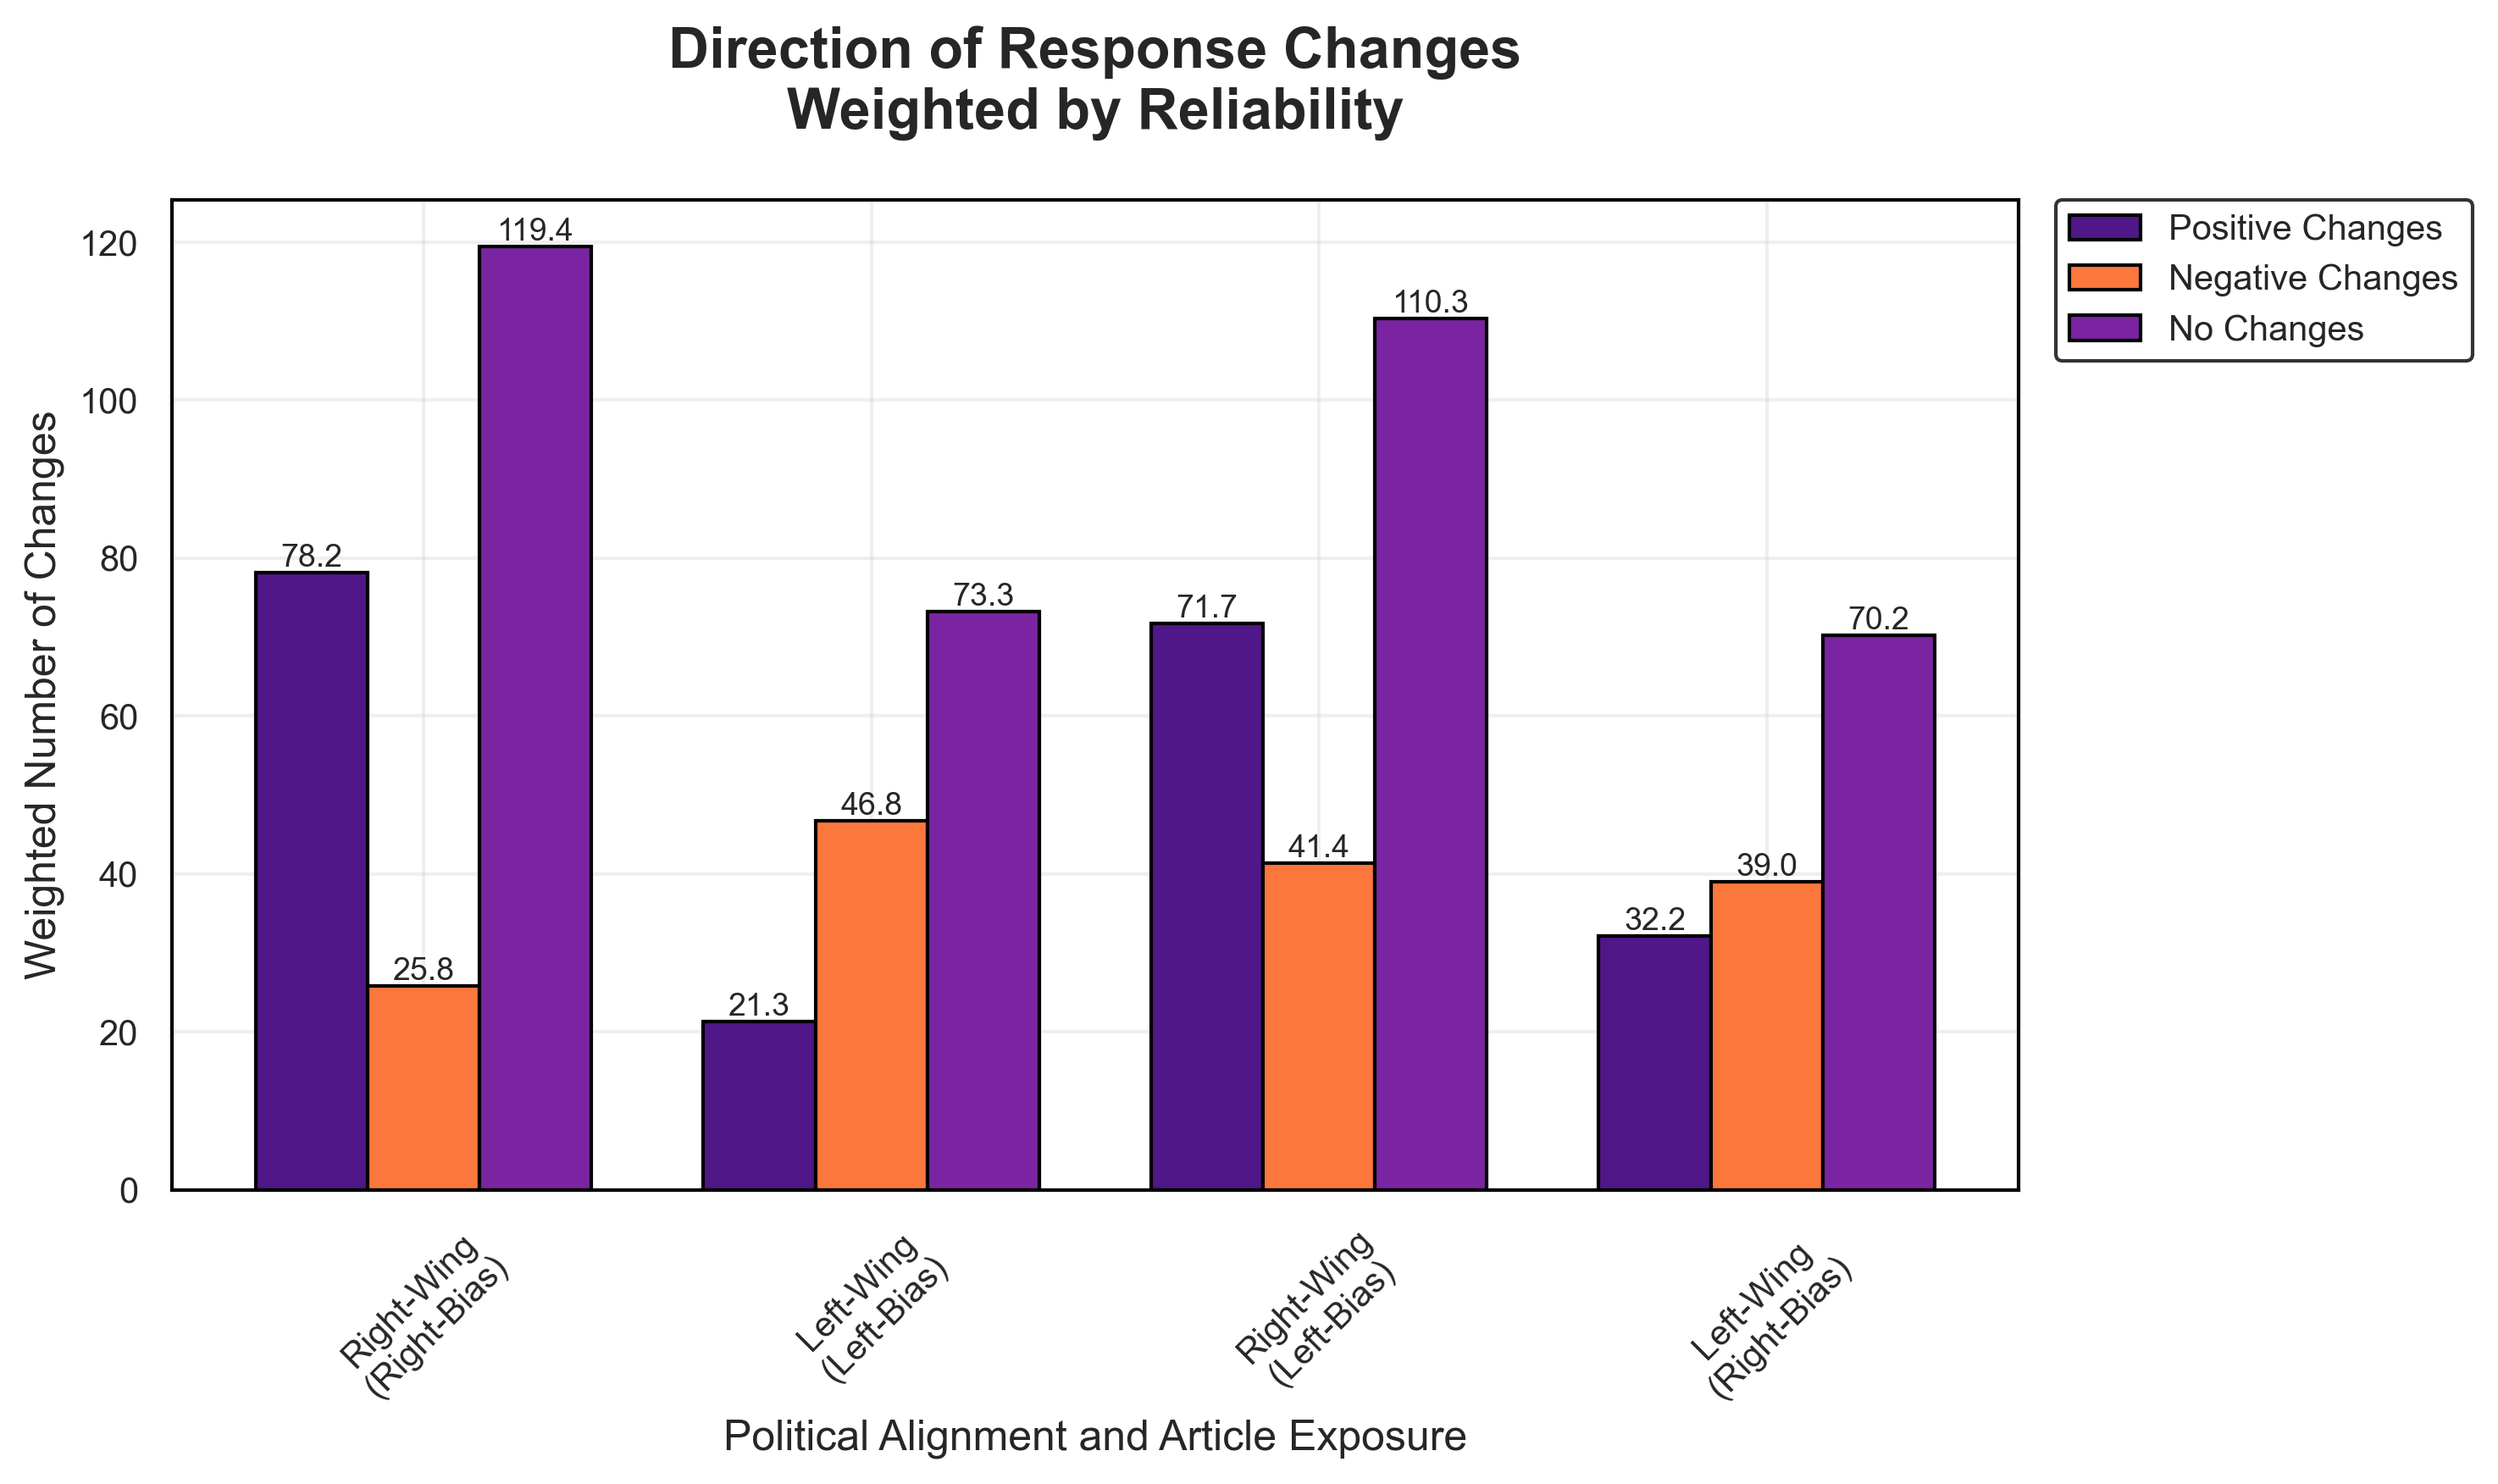

In [46]:
def visualize_direction_of_change_enhanced(groups, group_names):
    """
    Creates an enhanced grouped bar chart to visualize the number of positive, 
    negative, and no changes for each group using publication-ready styling.
    
    Parameters:
    - groups (list of tuples): Each tuple contains (positive, negative, no change) for a group
    - group_names (list of str): Names of the groups to be displayed on the x-axis
    """
    # Set the publication style
    PublicationStyle.set_style()
    
    n_groups = len(groups)
    positive_changes = [group[0] for group in groups]
    negative_changes = [group[1] for group in groups]
    no_changes = [group[2] for group in groups]

    bar_width = 0.25
    index = np.arange(n_groups)

    # Create figure and axis objects with publication-ready size
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars with consistent colors from the publication style
    bars1 = ax.bar(index, positive_changes, bar_width, 
                   label='Positive Changes', 
                   color=PublicationStyle.MAIN_COLORS['primary'],
                   edgecolor='black', linewidth=1)
    
    bars2 = ax.bar(index + bar_width, negative_changes, bar_width,
                   label='Negative Changes', 
                   color=PublicationStyle.MAIN_COLORS['secondary'],
                   edgecolor='black', linewidth=1)
    
    bars3 = ax.bar(index + 2 * bar_width, no_changes, bar_width,
                   label='No Changes', 
                   color=PublicationStyle.MAIN_COLORS['tertiary'],
                   edgecolor='black', linewidth=1)

    # Format the axis using the publication style
    PublicationStyle.format_axis(
        ax,
        title='Direction of Response Changes\nWeighted by Reliability',
        xlabel='Political Alignment and Article Exposure',
        ylabel='Weighted Number of Changes',
        xticks=(index + bar_width, group_names),
        rotation=45
    )

    # Adjust legend with publication styling
    ax.legend(bbox_to_anchor=(1.02, 1), 
             loc='upper left',
             borderaxespad=0,
             frameon=True,
             edgecolor='black')

    # Add value labels on top of each bar
    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2.,
                   height,
                   f'{height:.1f}',
                   ha='center',
                   va='bottom',
                   size=PublicationStyle.FONT_SIZES['annotation'])

    autolabel(bars1)
    autolabel(bars2)
    autolabel(bars3)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    return fig, ax

# First, store the results of the analysis
right_wing_right_bias_results = analyze_direction_of_change_with_reliability(
    right_wing_right_bias_df, "Right-Wing (Exposed to Right-Biased Articles)")

left_wing_left_bias_results = analyze_direction_of_change_with_reliability(
    left_wing_left_bias_df, "Left-Wing (Exposed to Left-Biased Articles)")

right_wing_left_bias_results = analyze_direction_of_change_with_reliability(
    right_wing_left_bias_df, "Right-Wing (Exposed to Left-Biased Articles)")

left_wing_right_bias_results = analyze_direction_of_change_with_reliability(
    left_wing_right_bias_df, "Left-Wing (Exposed to Right-Biased Articles)")

# Then prepare the data for visualization
group_data = [
    (right_wing_right_bias_results[1], right_wing_right_bias_results[2], right_wing_right_bias_results[3]),
    (left_wing_left_bias_results[1], left_wing_left_bias_results[2], left_wing_left_bias_results[3]),
    (right_wing_left_bias_results[1], right_wing_left_bias_results[2], right_wing_left_bias_results[3]),
    (left_wing_right_bias_results[1], left_wing_right_bias_results[2], left_wing_right_bias_results[3])
]

group_names = [
    "Right-Wing\n(Right-Bias)",
    "Left-Wing\n(Left-Bias)",
    "Right-Wing\n(Left-Bias)",
    "Left-Wing\n(Right-Bias)"
]

# Create and save the figure
fig, ax = visualize_direction_of_change_enhanced(group_data, group_names)
PublicationStyle.save_figure(fig, 'direction_of_changes.png')

## 6.1 - Persuasion vs Polarization Analysis

In the following cells, we aim at examining the direction of change in the responses of the participants with respect to the opposite and own groups. Persuasion is detected if the responses change towards the direction of the typical responses of the opposite group, whereas polarization is detected if the responses further move in the direction of the own group members, towards the extremes.
First, we need to identify the average response of the two groups to each question. Secondly, we need to calculate the relative position of each user's response to the individual questions.



In [47]:
# BASELINE FOR PERSUASION VS POLARIZATION ANALYSIS  
# Calculate weighted average responses for Extreme Left and Extreme Right based on original responses
weighted_avg_responses = merged_responses_with_reliability.groupby(['question_code', 'political_stance']).apply(
    lambda x: np.average(x['numeric_response_before'], weights=x['reliability_score']), include_groups=False
).reset_index()

# Rename columns for clarity
weighted_avg_responses.columns = ['question_code', 'political_stance', 'weighted_avg_response']

# Pivot the data to make it easier to access the average response for each group
weighted_avg_responses_pivot = weighted_avg_responses.pivot(
    index='question_code', 
    columns='political_stance', 
    values='weighted_avg_response'
).reset_index()

# Rename columns for clarity
weighted_avg_responses_pivot.columns = ['question_code', 'weighted_avg_extreme_left_response', 'weighted_avg_extreme_right_response']

# Display the pivoted DataFrame
print(weighted_avg_responses_pivot.head())


  question_code  weighted_avg_extreme_left_response  \
0       F1A10_1                            6.619909   
1          F2A6                            4.340355   
2          F2A7                            3.950323   
3          F2A9                            4.641171   
4        F3A3_1                            5.889887   

   weighted_avg_extreme_right_response  
0                             6.532322  
1                             4.203916  
2                             1.708172  
3                             2.883826  
4                             4.389687  


In [48]:
def analyze_opinion_shifts_with_bias(merged_df, mean_responses_df, group_name):
    """
    Analyzes the direction of opinion shifts for users exposed to biased content, distinguishing between
    polarization (becoming more extreme in their initial stance) and persuasion (moving toward the opposite stance).
    The analysis is done relative to the group's general stance on each question and takes into account the type of bias.

    Parameters:
    - merged_df (DataFrame): DataFrame with before and after responses, including response changes
                             and reliability scores, and the bias (left or right).
    - mean_responses_df (DataFrame): DataFrame containing the mean response of each group for each question.
    - group_name (str): Name of the group for logging purposes (e.g., "Extreme Left").

    Returns:
    - persuasion_weighted (float): Total weighted persuasion responses.
    - polarization_weighted (float): Total weighted polarization responses.
    """
    
    def interpret_shift_with_bias(row):
        question_code = row['question_code']
        response_before = row['numeric_response_before']
        response_after = row['numeric_response_after']
        reliability = row['reliability_score']
        bias = row['bias']  

        # Retrieve the average responses of both extremes
        left_avg = mean_responses_df.loc[mean_responses_df['question_code'] == question_code, 'weighted_avg_extreme_left_response'].values[0]
        right_avg = mean_responses_df.loc[mean_responses_df['question_code'] == question_code, 'weighted_avg_extreme_right_response'].values[0]

        # Case 1: Exposed to left-biased article
        if bias == 'left':
            # Persuasion: move closer to right_avg
            # Polarization: move further away from right_avg
            if abs(response_after - right_avg) < abs(response_before - right_avg):
                return 'persuasion', reliability
            elif abs(response_after - right_avg) > abs(response_before - right_avg):
                return 'polarization', reliability

        # Case 2: Exposed to right-biased article
        elif bias == 'right':
            # Persuasion: move closer to left_avg
            # Polarization: move further away from left_avg
            if abs(response_after - left_avg) < abs(response_before - left_avg):
                return 'persuasion', reliability
            elif abs(response_after - left_avg) > abs(response_before - left_avg):
                return 'polarization', reliability

        # Default to 'no_change' if no significant movement is detected
        return 'no_change', reliability

    merged_df_copy = merged_df.copy()

    # Apply the interpretation function to categorize each row
    merged_df_copy['shift_type'], merged_df_copy['reliability'] = zip(*merged_df_copy.apply(interpret_shift_with_bias, axis=1))

    # Calculate the weighted sums for persuasion and polarization
    persuasion_weighted = merged_df_copy.loc[merged_df_copy['shift_type'] == 'persuasion', 'reliability'].sum()
    polarization_weighted = merged_df_copy.loc[merged_df_copy['shift_type'] == 'polarization', 'reliability'].sum()

    # Return the results without printing debug details
    return persuasion_weighted, polarization_weighted


In [49]:
# Function to filter the complete merged DataFrame by political stance and bias
def filter_merged_responses_by_stance_and_bias(merged_df, political_stance, bias):
    """
    Filters the merged DataFrame by the given political stance and bias.

    Parameters:
    - merged_df (pd.DataFrame): Complete DataFrame containing before, after responses, and additional calculations.
    - political_stance (str): The political stance to filter by ('Extreme Right' or 'Extreme Left').
    - bias (str): The bias type to filter by ('left' or 'right').

    Returns:
    - pd.DataFrame: A DataFrame filtered based on the given political stance and bias.
    """
    return merged_df[(merged_df['political_stance'] == political_stance) & (merged_df['bias'] == bias)].copy()


In [50]:
# Filter the main DataFrame by political stance and bias for each group
right_wing_left_bias_df = filter_merged_responses_by_stance_and_bias(
    merged_responses_with_reliability, 
    political_stance='Extreme Right', 
    bias='left'
)

right_wing_right_bias_df = filter_merged_responses_by_stance_and_bias(
    merged_responses_with_reliability, 
    political_stance='Extreme Right', 
    bias='right'
)

left_wing_left_bias_df = filter_merged_responses_by_stance_and_bias(
    merged_responses_with_reliability, 
    political_stance='Extreme Left', 
    bias='left'
)

left_wing_right_bias_df = filter_merged_responses_by_stance_and_bias(
    merged_responses_with_reliability, 
    political_stance='Extreme Left', 
    bias='right'
)

# Call the function for each group

# Extreme Right exposed to left-biased articles
persuasion_rw_left, polarization_rw_left = analyze_opinion_shifts_with_bias(
    right_wing_left_bias_df,
    weighted_avg_responses_pivot,
    "Extreme Right"
)

# Extreme Right exposed to right-biased articles
persuasion_rw_right, polarization_rw_right = analyze_opinion_shifts_with_bias(
    right_wing_right_bias_df,
    weighted_avg_responses_pivot,
    "Extreme Right"
)

# Extreme Left exposed to left-biased articles
persuasion_lw_left, polarization_lw_left = analyze_opinion_shifts_with_bias(
    left_wing_left_bias_df,
    weighted_avg_responses_pivot,
    "Extreme Left"
)

# Extreme Left exposed to right-biased articles
persuasion_lw_right, polarization_lw_right = analyze_opinion_shifts_with_bias(
    left_wing_right_bias_df,
    weighted_avg_responses_pivot,
    "Extreme Left"
)

# Print the results for each group and bias exposure
print(f"Extreme Right (Exposed to Left Bias): Persuasion={persuasion_rw_left}, Polarization={polarization_rw_left}")
print(f"Extreme Right (Exposed to Right Bias): Persuasion={persuasion_rw_right}, Polarization={polarization_rw_right}")
print(f"Extreme Left (Exposed to Left Bias): Persuasion={persuasion_lw_left}, Polarization={polarization_lw_left}")
print(f"Extreme Left (Exposed to Right Bias): Persuasion={persuasion_lw_right}, Polarization={polarization_lw_right}")


Extreme Right (Exposed to Left Bias): Persuasion=31.096637964141912, Polarization=82.03019697697057
Extreme Right (Exposed to Right Bias): Persuasion=51.74196212282572, Polarization=52.25407402019871
Extreme Left (Exposed to Left Bias): Persuasion=29.250189634864697, Polarization=38.8401911553541
Extreme Left (Exposed to Right Bias): Persuasion=18.857685139476043, Polarization=52.30899503295947


The analysis suggests that exposure to biased content, whether aligned or opposing, generally reinforces participants' existing beliefs rather than persuading them to shift their opinions. This effect is more pronounced when the content is aligned with their initial stance, especially for the Extreme Left exposed to right-biased content, who exhibit high polarization.

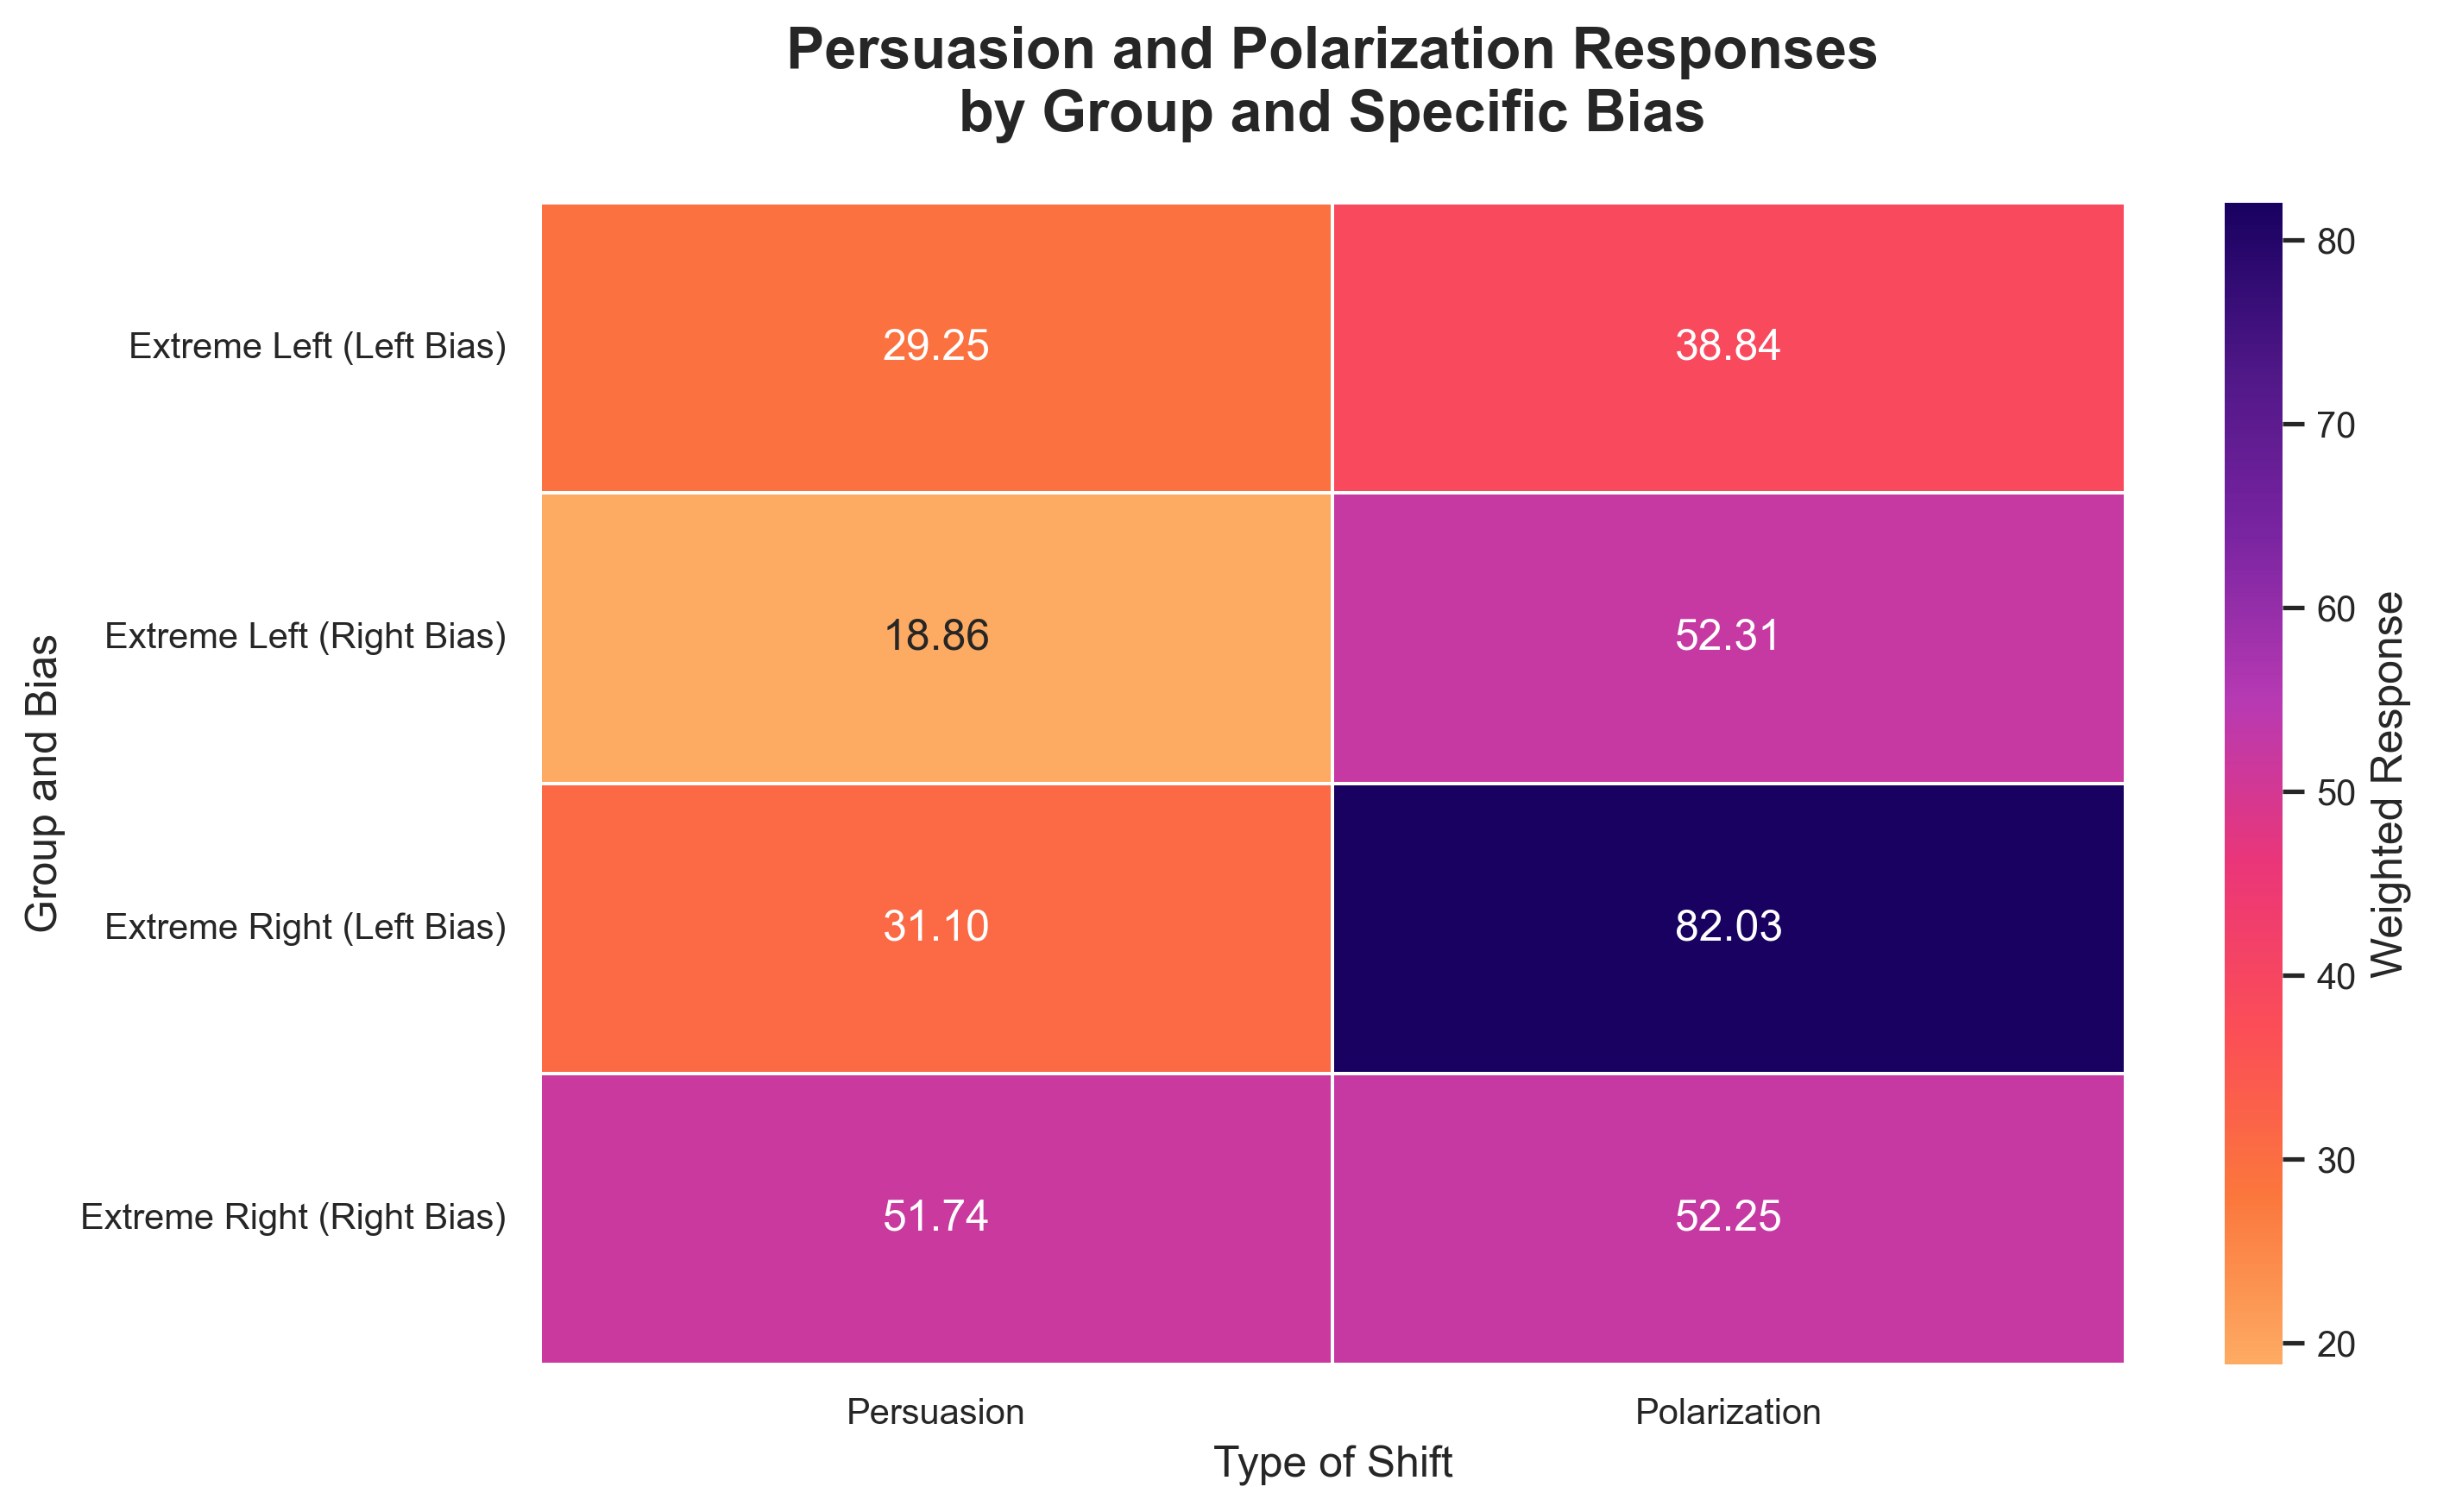

In [51]:
def plot_heatmaps(results):
    """
    Plots a heatmap for Persuasion and Polarization Responses by Group and Bias (Left/Right)
    using publication-ready styling.
    
    Parameters:
    - results (dict): A dictionary containing the results from the analysis where keys are
                      group and bias combinations and values are dicts with persuasion and polarization scores.
    """
    # Set the publication style
    PublicationStyle.set_style()
    
    # Prepare the data for the heatmap
    heatmap_results = []

    # Loop through the results dictionary and prepare data for the heatmap
    for key, value in results.items():
        group, bias = key.split('_')  # Split the key to extract group and bias
        heatmap_results.append({
            'Group and Bias': f"{group} ({bias.capitalize()} Bias)",
            'Persuasion': value['persuasion_weighted'],
            'Polarization': value['polarization_weighted']
        })

    # Convert the results into a DataFrame
    df_results = pd.DataFrame(heatmap_results)

    # Reshape the data for the heatmap
    df_melted_results = df_results.melt(id_vars='Group and Bias', 
                                      var_name='Type of Shift', 
                                      value_name='Weighted Response')

    # Create the pivot table for the heatmap
    heatmap_data = df_melted_results.pivot(index="Group and Bias", 
                                         columns="Type of Shift", 
                                         values="Weighted Response")

    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the heatmap
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt=".2f", 
                cmap=PublicationStyle.GRADIENT_CMAP,  # Use the gradient colormap from PublicationStyle
                linewidths=0.5,
                ax=ax,
                cbar_kws={'label': 'Weighted Response'})

    # Format the axis using the publication style
    PublicationStyle.format_axis(
        ax,
        title='Persuasion and Polarization Responses\nby Group and Specific Bias',
        xlabel='Type of Shift',
        ylabel='Group and Bias'
    )

    # Adjust layout
    plt.tight_layout()

    return fig, ax

# Store the results in a dictionary format suitable for plotting heatmaps
results = {
    "Extreme Right_left": {"persuasion_weighted": persuasion_rw_left, "polarization_weighted": polarization_rw_left},
    "Extreme Right_right": {"persuasion_weighted": persuasion_rw_right, "polarization_weighted": polarization_rw_right},
    "Extreme Left_left": {"persuasion_weighted": persuasion_lw_left, "polarization_weighted": polarization_lw_left},
    "Extreme Left_right": {"persuasion_weighted": persuasion_lw_right, "polarization_weighted": polarization_lw_right}
}

# Create and save the figure
fig, ax = plot_heatmaps(results)
PublicationStyle.save_figure(fig, 'persuasion_polarization_heatmap.png')

# 7. Which users changed their opinions the most and the least? (No direction given)

In [52]:
merged_responses_with_reliability['weighted_response_change'] = merged_responses_with_reliability['response_change'].abs() * merged_responses_with_reliability['reliability_score']

user_response_changes = merged_responses_with_reliability.groupby('user_id')['weighted_response_change'].sum().reset_index()

user_response_changes_sorted = user_response_changes.sort_values(by='weighted_response_change', ascending=False)

# Define the top user_ids from the sorted data
top_user_ids = user_response_changes_sorted['user_id'].head(10)


In [53]:
# Step 1: Filter relevant columns for visualization
user_data = pd.read_csv("../data/processed/combined_data.csv")
user_data.loc[user_data["Where would you place your own political position?"] == "Far Left", "Where would you place your own political position?"] = "Extreme Left"



In [54]:
# 1. Calculate absolute weighted response changes (already correct)
merged_responses_with_reliability['weighted_response_change'] = (
    merged_responses_with_reliability['response_change'].abs() * 
    merged_responses_with_reliability['reliability_score']
)

# 2. Aggregate response changes per user
user_response_changes = (
    merged_responses_with_reliability.groupby('user_id')['weighted_response_change']
    .sum()
    .reset_index()
)

# 3. Sort users by their total weighted response change
user_response_changes_sorted = user_response_changes.sort_values(by='weighted_response_change', ascending=False)

# 4. Define the top and bottom users (Top 10 most changed, Bottom 10 least changed)
top_user_ids = user_response_changes_sorted['user_id'].head(10)
bottom_user_ids = user_response_changes_sorted['user_id'].tail(10)

# Display top users who changed their opinions the most
print("Top 10 Users with Greatest Opinion Shifts:")
print(top_user_ids)

# Display bottom users who changed their opinions the least
print("\nBottom 10 Users with Least Opinion Shifts:")
print(bottom_user_ids)

# 6. Filter data for the top and bottom users
user_data_top_changes = user_data[user_data["user"].isin(top_user_ids)]
user_data_bottom_changes = user_data[user_data["user"].isin(bottom_user_ids)]

Top 10 Users with Greatest Opinion Shifts:
97    IDUS127802
70    IDUS121853
79    IDUS125517
6     IDUS104666
76    IDUS123988
83    IDUS126112
31    IDUS110884
1     IDUS103554
41    IDUS112849
28    IDUS110358
Name: user_id, dtype: object

Bottom 10 Users with Least Opinion Shifts:
52     IDUS114931
3      IDUS104424
77     IDUS124201
102    IDUS130050
106    IDUS131200
24     IDUS110181
16     IDUS108306
23     IDUS110077
107    IDUS131206
8      IDUS105157
Name: user_id, dtype: object


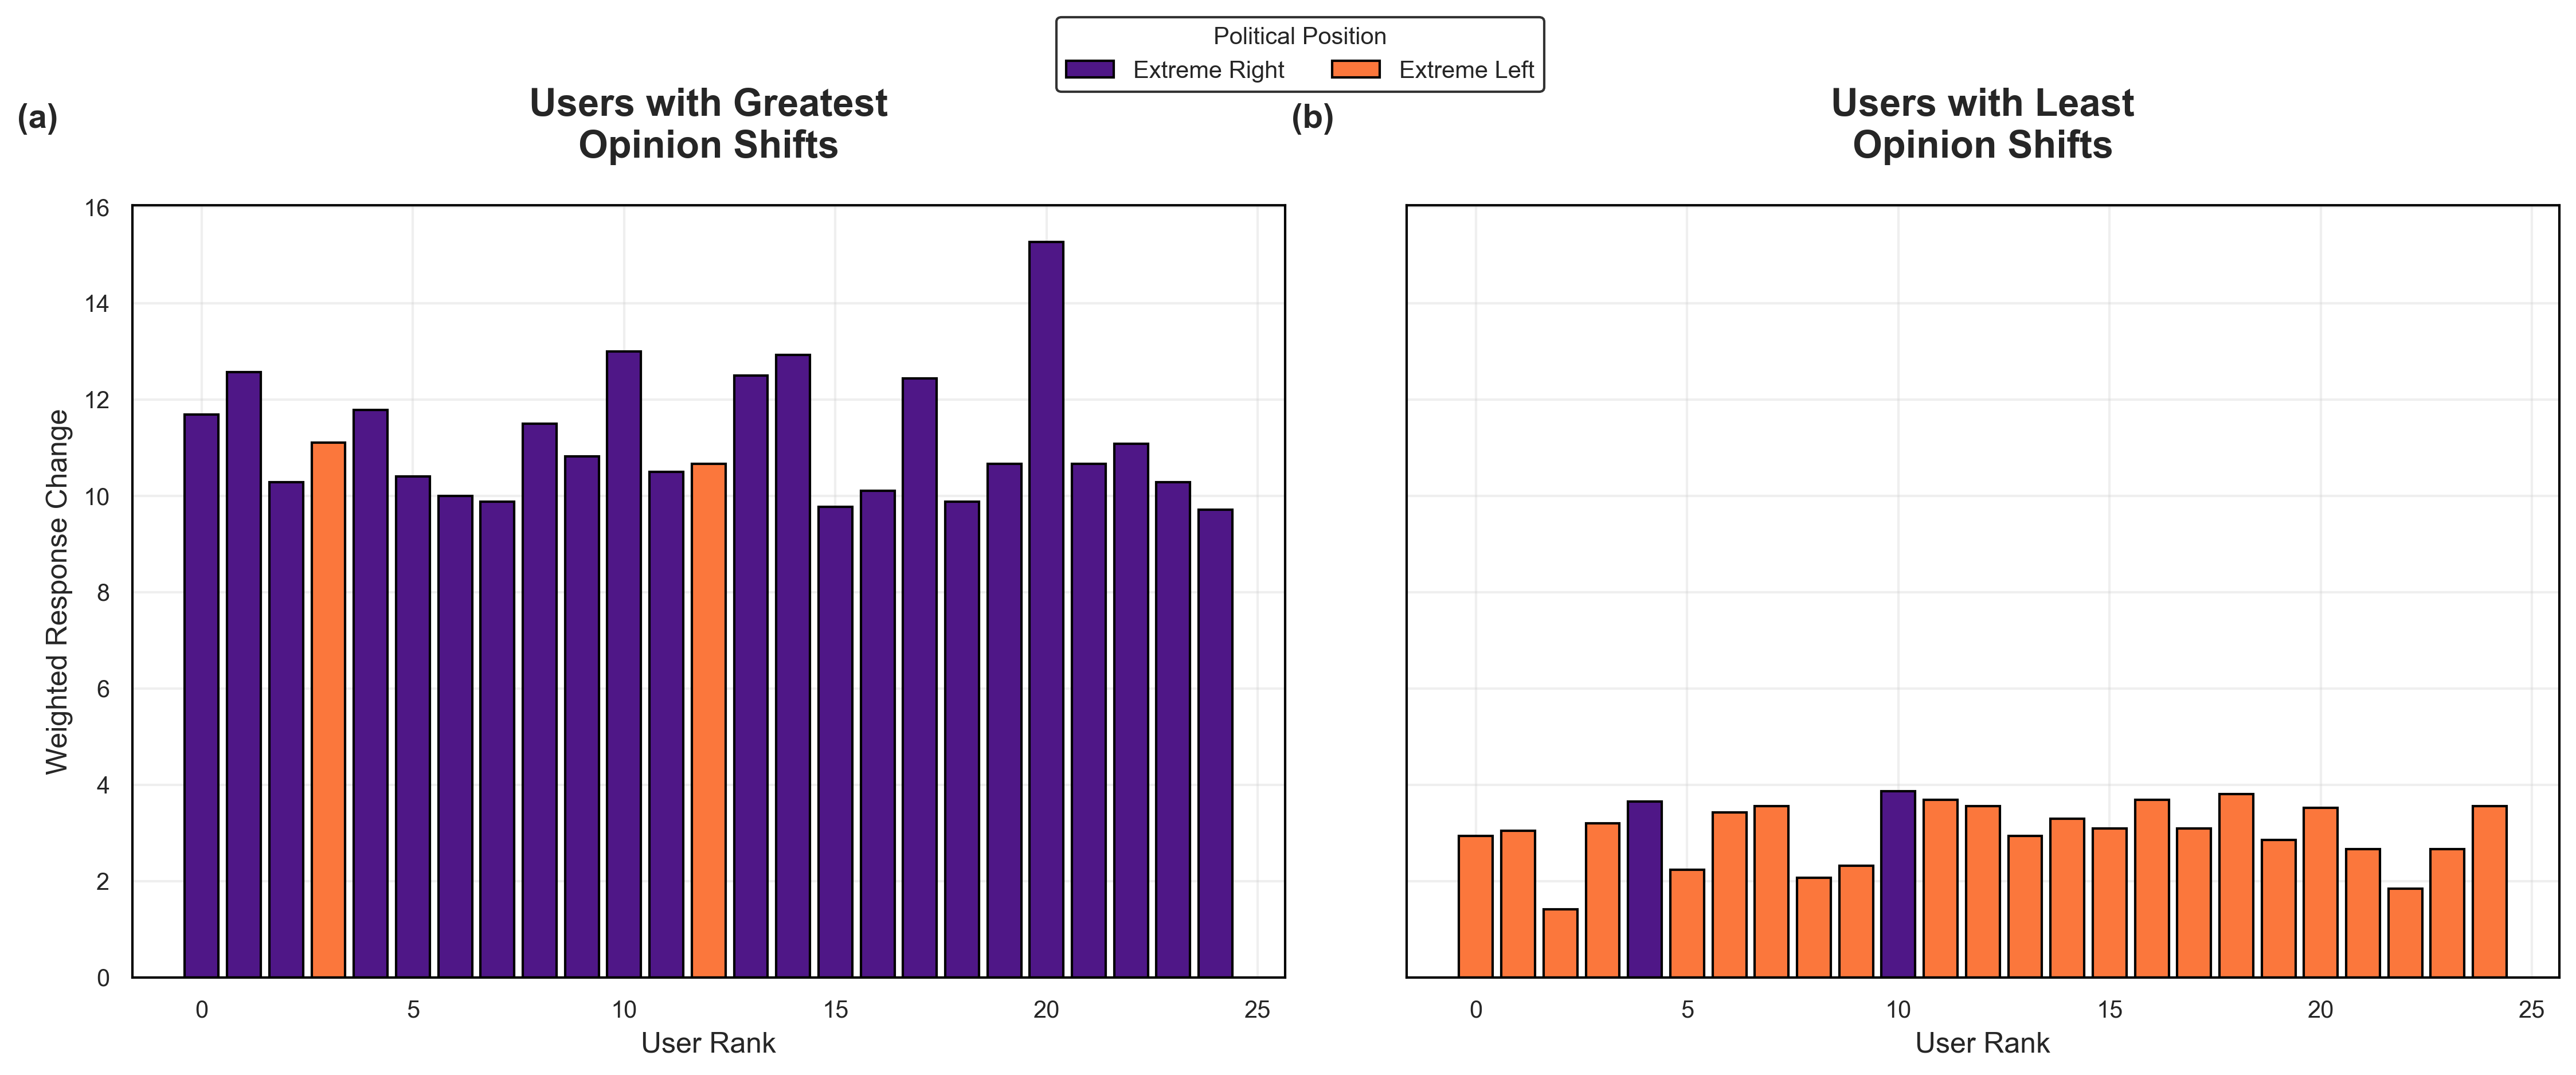

In [55]:
def plot_user_response_changes(user_data, merged_responses_with_reliability):
    """
    Creates a publication-ready visualization comparing the top and bottom users 
    by their weighted response changes, colored by political position.
    
    Parameters:
    - user_data: DataFrame containing user demographic information
    - merged_responses_with_reliability: DataFrame containing response changes and reliability scores
    """
    # Set the publication style
    PublicationStyle.set_style()
    
    # 1. Calculate absolute weighted response changes
    merged_responses_with_reliability['weighted_response_change'] = (
        merged_responses_with_reliability['response_change'].abs() * 
        merged_responses_with_reliability['reliability_score']
    )

    # 2. Aggregate response changes per user
    user_response_changes = (
        merged_responses_with_reliability.groupby('user_id')['weighted_response_change']
        .sum()
        .reset_index()
    )

    # 3. Sort users by their total weighted response change
    user_response_changes_sorted = user_response_changes.sort_values(
        by='weighted_response_change', 
        ascending=False
    )

    # 4. Define the top and bottom users
    top_user_ids = user_response_changes_sorted['user_id'].head(25)
    bottom_user_ids = user_response_changes_sorted['user_id'].tail(25)

    # 5. Filter demographic data for the top and bottom users
    user_data_top_changes = user_data[user_data["user"].isin(top_user_ids)]
    user_data_bottom_changes = user_data[user_data["user"].isin(bottom_user_ids)]

    # 6. Merge response changes with demographic data to get political stance
    top_users = user_data_top_changes.merge(
        user_response_changes, 
        left_on='user', 
        right_on='user_id'
    )
    bottom_users = user_data_bottom_changes.merge(
        user_response_changes, 
        left_on='user', 
        right_on='user_id'
    )

    # Define color mapping for political positions using PublicationStyle colors
    color_map = {
        'Extreme Right': PublicationStyle.MAIN_COLORS['primary'],
        'Extreme Left': PublicationStyle.MAIN_COLORS['secondary'],
    }

    # Assign colors based on political position
    top_users['Color'] = top_users['Where would you place your own political position?'].map(color_map)
    bottom_users['Color'] = bottom_users['Where would you place your own political position?'].map(color_map)

    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Plot for Top Users with Greatest Opinion Shifts
    ax1.bar(range(len(top_users)), 
            top_users['weighted_response_change'], 
            color=top_users['Color'],
            edgecolor='black',
            linewidth=1)
    
    # Plot for Bottom Users with Least Opinion Shifts
    ax2.bar(range(len(bottom_users)), 
            bottom_users['weighted_response_change'], 
            color=bottom_users['Color'],
            edgecolor='black',
            linewidth=1)

    # Format axes using PublicationStyle
    PublicationStyle.format_axis(
        ax1,
        title='Users with Greatest\nOpinion Shifts',
        xlabel='User Rank',
        ylabel='Weighted Response Change'
    )
    
    PublicationStyle.format_axis(
        ax2,
        title='Users with Least\nOpinion Shifts',
        xlabel='User Rank'
    )

    # Add subplot labels
    PublicationStyle.add_figure_labels(fig, ['a', 'b'])

    # Create legend
    legend_elements = [plt.Rectangle((0,0), 1, 1, 
                                   facecolor=color, 
                                   edgecolor='black',
                                   label=label) 
                      for label, color in color_map.items()]
    
    fig.legend(handles=legend_elements,
              title='Political Position',
              loc='upper center',
              bbox_to_anchor=(0.5, 1.05),
              ncol=2,
              frameon=True,
              edgecolor='black')

    # Adjust layout
    plt.tight_layout()
    
    return fig, (ax1, ax2)

# Create and save the figure
fig, axes = plot_user_response_changes(user_data, merged_responses_with_reliability)
PublicationStyle.save_figure(fig, 'user_response_changes.png')

In [56]:
import json

# Path to your Jupyter notebook
notebook_path = 'final_analysis.ipynb'

# Load the notebook
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = json.load(f)

# Extract outputs from code cells
outputs = []
for cell in notebook['cells']:
    if cell['cell_type'] == 'code':
        for output in cell.get('outputs', []):
            output_type = output.get('output_type')
            
            if output_type == 'stream':
                # Only include 'stdout' outputs
                if output.get('name') == 'stdout':
                    text = output.get('text', '')
                    outputs.append(text)
            
            elif output_type in ('execute_result', 'display_data'):
                data = output.get('data', {})
                # Only include 'text/plain' data
                if 'text/plain' in data:
                    text = data['text/plain']
                    # If text is a list, join it into a single string
                    if isinstance(text, list):
                        text = ''.join(text)
                    outputs.append(text)

# Clean up and print the outputs
for output in outputs:
    # Ensure the output is a string
    if isinstance(output, list):
        output = ''.join(output)  # Join list elements into a single string
    if not isinstance(output, str):
        continue  # Skip outputs that are not strings
    # Decode escape sequences and strip unnecessary whitespace
    try:
        output = output.encode('utf-8').decode('unicode_escape').strip()
    except Exception:
        pass  # If decoding fails, leave the output as is
    print(output)


Malformed JSON detected: Extra data: line 178 column 2 (char 5656)
Attempting to fix...
user_id question_code   bias          selected_option  0  IDUS103408       F1A10_1   left  Disagree to some extent   
1  IDUS103408       F1A10_1  right         Completely agree   
2  IDUS103408          F2A6   left          quite concerned   
3  IDUS103408          F2A6  right           very concerned   
4  IDUS103408          F2A7   left           very concerned   

                                            question numeric_response  0    I feel like I am treated fairly by politicians.                5   
1    I feel like I am treated fairly by politicians.                1   
2  To what degree does this concern you: The fact...                4   
3  To what degree does this concern you: The fact...                5   
4  To what degree does this concern you: The situ...                5   

  political_stance  
0    Extreme Right  
1    Extreme Right  
2    Extreme Right  
3    Extreme Right  